<a href="https://colab.research.google.com/github/menotti/ld/blob/main/Livro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Instala√ß√µes (_executar antes de qualquer outro exemplo_)
!pip install git+https://github.com/lesc-ufv/cad4u/ &> /dev/null
!git clone https://github.com/lesc-ufv/cad4u/ &> /dev/null
%load_ext plugin
!sudo apt update &> /dev/null
!sudo apt install imagemagick pdf2svg texlive-latex-extra &> /dev/null
!pip install git+https://github.com/mkrphys/ipython-tikzmagic.git &> /dev/null
%load_ext tikzmagic
#!pip install schemdraw[matplotlib]==0.14 &> /dev/null
!pip install schemdraw[svgmath]  &> /dev/null
!pip install truth-table-generator &> /dev/null

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets.widgets.widget_string import Label
from IPython.display import display

import random
import ttg

import schemdraw
from schemdraw import elements as elm
from schemdraw import logic
from schemdraw import flow
from schemdraw.parsing import logicparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def questao_aleatorio_lista_dropdown(l,cabecalho=""):
  x = random.randrange(len(l))
  print(cabecalho+l[x][0]+"?")

  r = ["Selecione"]
  for i in l:
    r.append(i[1])

  def op(resposta):
    if (resposta== l[x][1]):
      return "Correto !"
    else:
      return "Tente novamente !"

  interact(op,resposta=r)


<font color='red'>Esta √© uma vers√£o preliminar do livro. Apesar de completa, ela ainda n√£o est√£o revisada. Esperamos que possa aproveitar o conte√∫do e nos fornecer <i>feedback</i> na forma de coment√°rios nas respectivas c√©lulas.</font>

# Introdu√ß√£o √† L√≥gica Digital com Verilog

## Professores: [Ricardo dos Santos Ferreira - UFV](mailto:ricardo@ufv.br) e [Ricardo Menotti - UFSCar](mailto:menotti@ufscar.br)



Neste livro vamos tratar especificamente de Circuitos Digitais, sem nos preocupar com a convers√£o de/para anal√≥gico. Vamos usar a linguagem de descri√ß√£o de hardware (HDL) Verilog para implementar e testar os circuitos usando simula√ß√µes. N√£o √© necess√°rio ter qualquer tipo de hardware espec√≠fico para usar livro, apenas um computador conectado √† Internet. Estamos planejando um vers√£o baseada em um kit did√°tico de FPGAs, no qual todas as pr√°ticas poder√£o ser feitas em laborat√≥rio. Se voc√™ tem interesse em comercializar um kit de baixo custo com o livro, entre em contato pelos e-mails acima.

## Informa√ß√£o anal√≥gica e digital

Os sistemas digitais s√£o a base dos dispositivos eletr√¥nicos modernos que usamos em nosso cotidiano, tais como computadores, *smartphones* e eletrodom√©sticos em geral. Com o advento da Internet das Coisas, eles passaram tamb√©m a serem embarcados em ve√≠culos e em diversos pontos das casas e cidades em geral, formando o conceito de Cidades Inteligentes.

No entanto, a maioria dos fen√¥menos que notamos ao nosso redor tem caracter√≠sticas anal√≥gicas e precisam ser digitalizadas para serem processadas. Este processo tamb√©m pode ser chamado de discretiza√ß√£o e, apesar da desvantagem de se perder a precis√£o ou continuidade da informa√ß√£o, apresenta a vantagem de a tornar mais tolerante aos ru√≠dos e mais f√°cil de manipular e armazenar. A figura a seguir mostra o exemplo de uma informa√ß√£o anal√≥gica (linha pontilhada) e sua discretiza√ß√£o para armazenamento e/ou processamento digital.

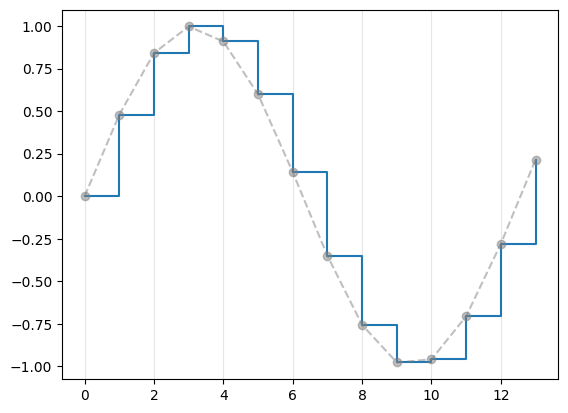

In [2]:
#@title
x = np.arange(14)
y = np.sin(x / 2)

plt.step(x, y, where='post', label='post')
plt.plot(x, y, 'o--', color='grey', alpha=0.5)

plt.grid(axis='x', color='0.9')
plt.show()

## Vari√°veis l√≥gicas

Para os sistemas digitais, a menor unidade de informa√ß√£o √© o **bit** (acr√¥nimo para ***binary digit***) que pode assumir valor **0** ou **1**. Usaremos diagramas de Venn para representar vari√°veis e fun√ß√µes l√≥gicas, tamb√©m chamadas de booleanas (a seguir detalharemos o termo). Dizemos que uma vari√°vel tem o n√≠vel l√≥gico **0** ou **baixo** quando tem o valor **falso** e que tem o n√≠vel l√≥gico **1** ou **alto** quando tem o valor **verdadeiro**. No par de diagramas de Venn a seguir representamos $x=1$ e $y=0$, respectivamente. Usamos uma barra superior para demonstar a nega√ß√£o de uma vari√°vel, ou seja, seu inverso. Portanto, neste caso, $\bar{x}=0$ e $\bar{y}=1$.

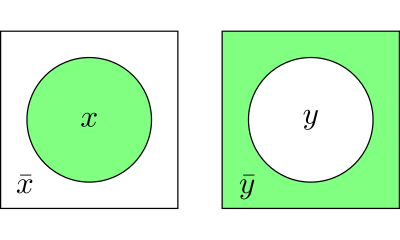

In [3]:
#@title
%%tikz -S test_output.tikz -f svg

\filldraw[fill=white] (-1,-1) rectangle (1,1);
\node[fill=green!50,draw,circle,label=below left:$\bar{x}$,minimum size=40pt] at (0,0) {$x$};

\filldraw[fill=green!50] (1.5,-1) rectangle (3.5,1);
\node[fill=white,draw,circle,label=below left:$\bar{y}$,minimum size=40pt] at (2.5,0) {$y$};

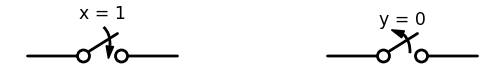

In [4]:
#@title
with schemdraw.Drawing() as d:
    d += elm.Switch(action='close').label('x = 1')
    d += elm.Gap(label=' ')
    d += elm.Switch(action='open').label('y = 0')

## Implementa√ß√£o em Verilog

**Verilog** √© uma **linguagem de descri√ß√£o de hardware (HDL)** e ser√° adotada neste livro para implementa√ß√£o e testes dos circuitos digitais. Apesar de sua sintaxe lembrar a da linguagem C em alguns aspectos, Verilog n√£o √© uma linguagem de programa√ß√£o. Trata-se de outro paradigma, pois enquanto um programa em uma linguagem imperativa como C remete a uma sequ√™ncia de instru√ß√µes (carater temporal), uma linguagem de descri√ß√£o de hardware descreve componentes e liga√ß√µes entre eles (carater espacial). Um projeto digital em Verilog possui um ou mais m√≥dulos. A seguir est√° a descri√ß√£o de um m√≥dulo com uma entrada que √© apenas propagada para sua sa√≠da. O comando de c√©lula `%%print_verilog` √© usado para desenhar o circuito e pode ser √∫til para conferir a sintaxe da linguagem, que ser√° ensinada a medida que avan√ßamos.

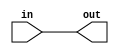

In [126]:
%%print_verilog

module foo(input in, output out);
  // isso √© um coment√°rio
  assign out = in;
endmodule

## Fun√ß√µes l√≥gicas

As vari√°veis l√≥gicas podem ser usadas como entradas nas fun√ß√µes l√≥gicas, gerando novas vari√°veis. As fun√ß√µes b√°sicas s√£o **AND**, **OR** e **NOT**, como veremos a seguir.

### Fun√ß√£o **AND** (E)

A fun√ß√£o l√≥gica **AND** resulta em uma sa√≠da verdadeira quando **todas suas entradas s√£o verdadeiras**. Ela pode ser representada pelo s√≠mbolo $\&$, por um ponto, (e.g. $a.b$) ou sua representa√ß√£o pode ser simplesmente omitida. A seguir √© listada a tabela verdade com todas as combina√ß√µes poss√≠veis entre duas vari√°veis l√≥gicas $a$ e $b$. Note que a tabela tem $2^n$ linhas, onde $n$ √© o n√∫mero de entradas, e que ela est√° ordenada pelos valores das vari√°veis de entrada $a$ e $b$.

$a$|$b$|$a\&b$
---|---|---
 0 | 0 | 0
 0 | 1 | 0
 1 | 0 | 0
 1 | 1 | 1

Nos diagramas de Venn, a fun√ß√£o **AND** √© calculada com a opera√ß√£o de ***intersec√ß√£o*** entre as vari√°veis. No diagrama a seguir √© apresentada a opera√ß√£o **AND** entre as vari√°veis $a$ e $b$. Note que, assim como a tabela verdade, o diagrama tem tem $2^n$ regi√µes, onde $n$ √© o n√∫mero de vari√°veis.

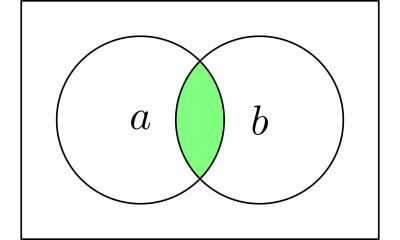

In [6]:
#@title
%%tikz -S test_output.tikz -f svg
\filldraw[fill=white] (-1,-1) rectangle (2,1);
\begin{scope}
  \clip (0,0) circle (20pt);
  \filldraw[green!50] (1,0) circle (20pt);
\end{scope}
\node[draw,circle,minimum size=40pt] at (0,0) {$a$};
\node[draw,circle,minimum size=40pt] at (1,0) {$b$};

A fun√ß√£o l√≥gica **AND** pode ser melhor compreendida pela liga√ß√£o de duas ou mais chaves em s√©rie, ou seja, sua sa√≠da ser√° verdadeira quando ***todas as chaves estiverem ligadas***. A implementa√ß√£o desta fun√ß√£o em um circuito √© feita por meio de sua respectiva **porta l√≥gica**, cuja representa√ß√£o gr√°fica √© a seguinte:

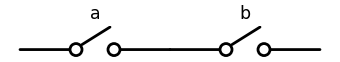

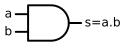

In [7]:
#@title
with schemdraw.Drawing() as d:
    d += elm.Switch().label('a')
    d += elm.Switch().label('b')

from schemdraw.parsing import logicparse
logicparse('a and b', outlabel='s=a.b')

Por fim, cabe ressaltar que esta fun√ß√£o √© N-√°ria, onde o n√∫mero de entradas √© maior ou igual a 2. A seguir est√£o as diferentes representa√ß√µes da fun√ß√£o **AND** na forma tern√°ria.

$a$|$b$|$c$|$\mbox{$a$.$b$.$c$}$
---|---|---|---
 0 | 0 | 0 | 0
 0 | 0 | 1 | 0
 0 | 1 | 0 | 0
 0 | 1 | 1 | 0
 1 | 0 | 0 | 0
 1 | 0 | 1 | 0
 1 | 1 | 0 | 0
 1 | 1 | 1 | 1

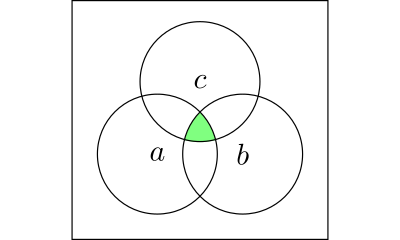

In [8]:
#@title
%%tikz -S test_output.tikz -f svg
\filldraw[fill=white] (-1,-1) rectangle (2,1.8);
\begin{scope}
  \clip (0,0) circle (20pt);
  \clip (1,0) circle (20pt);
  \filldraw[green!50] (0.5,0.85) circle (20pt);
\end{scope}
\node[draw,circle,minimum size=40pt] at (0,0) {$a$};
\node[draw,circle,minimum size=40pt] at (1,0) {$b$};
\node[draw,circle,minimum size=40pt] at (0.5,0.85) {$c$};

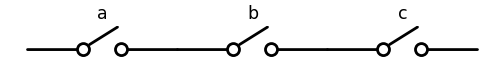

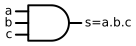

In [9]:
#@title
from schemdraw import elements as elm

with schemdraw.Drawing() as d:
    d += elm.Switch().label('a')
    d += elm.Switch().label('b')
    d += elm.Switch().label('c')

from schemdraw.parsing import logicparse
logicparse('a and b and c', outlabel='s=a.b.c')

Para implementar uma fun√ß√£o l√≥gica AND em Verilog podemos usar seu operador (`&`) entre os operandos em uma atribui√ß√£o cont√≠nua (`assign`) ou instanciar uma primitiva b√°sica `and` que pode ter duas ou mais entradas. Note que, por conter um n√∫mero vari√°vel de entradas, a primeira porta das primitivas b√°sicas √© sempre a sa√≠da. Vejamos sua implementa√ß√£o em Verilog (o par√¢metro `-n and3.v` usado na c√©lula, indica que vamos salvar o arquivo com este nome para usar posteriormente):

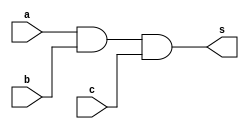

In [10]:
%%print_verilog -n and3.v

module and3(
  input a, b, c,
  output s);
  // atribui√ß√£o cont√≠nua usando o operador &
  assign s = a & b & c;
  // alternativa em Verilog Estrutural (instanciando a primitiva b√°sica)
  // and (s, a, b, c);
endmodule

Vejamos sua simula√ß√£o a seguir. Para isso, vamos escrever um ***test bench*** que fornece todas as entradas poss√≠veis, j√° que neste caso s√£o apenas $2^3$. Um ***test bench*** √© um m√≥dulo que instancia outro m√≥dulo a ser testado, normalmente com o nome de `dut` (*design under test*) ou `uut` (*unit under test*) e fornece est√≠mulos a ele. O teste pode tamb√©m verificar automaticamente se as sa√≠das obtidas s√£o as esperadas, mas por enquanto vamos fazer isso visualmente do diagrama de formas de onda (*waveform*) que geraremos com o comando de c√©lula `%%wavedrom`. Podemos notar as seguintes particularidades:

  1. O arquivo que cont√©m o m√≥dulo a ser testado (`dut`) √© inclu√≠do (linha 2);
  1. O m√≥dulo `tb_and3` n√£o tem portas, pois ele mesmo gera os est√≠mulos (linha 4);
  1. As entradas devem ser declaradas como `reg`, pois vamos atribuir valores a elas ao longo do teste (linha 5);
  1. As sa√≠das devem ser declaradas como `wire`, pois apenas conduzem o valores obtido do `dut` (linha 6);
  1. O `dut` √© instanciado, usamos a mesma ordem das portas da declara√ß√£o original do m√≥dulo (linha 7);
  1. Um bloco `initial` √© disparado uma √∫nica vez no in√≠cio da simula√ß√£o, `begin/end` delimitam seu alcance (linhas 9-22);
  1. A fun√ß√£o `$dumpvars` √© usada para gerar um arquivo `.vcd` com a sa√≠da da simula√ß√£o (linha 11);
  1. O comando `#5` indica um atraso antes de atribuir os valores √†s entradas, por isso no in√≠cio da simula√ß√£o elas aparecem hachuradas (linhas 12-19);
  1. Todos os valores poss√≠veis para a fun√ß√£o s√£o informados na mesma ordem da tabela verdade (linhas 12-19);
  1. A fun√ß√£o `$finish` termina a simula√ß√£o;

VCD info: dumpfile dump.vcd opened for output.



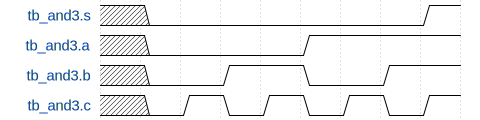

In [127]:
%%wavedrom
`include "and3.v"

module tb_and3;
  reg a, b, c;
  wire s;
  and3 dut(a, b, c, s);

  initial
  begin
    $dumpvars(0);
    #5 a=0; b=0; c=0;
    #5 a=0; b=0; c=1;
    #5 a=0; b=1; c=0;
    #5 a=0; b=1; c=1;
    #5 a=1; b=0; c=0;
    #5 a=1; b=0; c=1;
    #5 a=1; b=1; c=0;
    #5 a=1; b=1; c=1;
    $finish;
  end
endmodule

<h3>Fun√ß√£o <b>OR</b> (OU)</h3>

A fun√ß√£o l√≥gica **OR** resulta em uma sa√≠da verdadeira quando **ao menos uma de suas entradas √© verdadeira**. Ela pode ser representada pelo s√≠mbolo  $+$ ou $|$. A seguir √© listada a tabela verdade com todas as combina√ß√µes poss√≠veis entre duas vari√°veis l√≥gicas $a$ e $b$. Note que a tabela tem $2^n$ linhas, onde $n$ √© o n√∫mero de entradas, e que ela est√° ordenada pelos valores das vari√°veis de entrada $a$ e $b$.

$a$|$b$|$\mbox{$a$+$b$}$
---|---|---
 0 | 0 | 0
 0 | 1 | 1
 1 | 0 | 1
 1 | 1 | 1

Nos diagramas de Venn, a fun√ß√£o **OR** √© calculada com a opera√ß√£o de ***uni√£o*** entre as vari√°veis. No diagrama a seguir √© apresentada a opera√ß√£o **OR** entre as vari√°veis $a$ e $b$. Note que, assim como a tabela verdade, o diagrama tem tem $2^n$ regi√µes, onde $n$ √© o n√∫mero de vari√°veis.


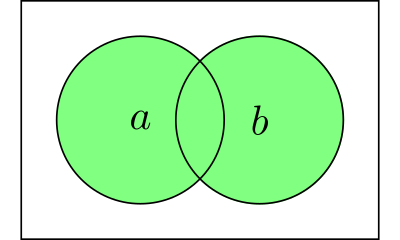

In [12]:
#@title
%%tikz -S test_output.tikz -f svg
\filldraw[fill=white] (-1,-1) rectangle (2,1);
\filldraw[green!50] (1,0) circle (20pt); % fundo B verde
\node[fill=green!50,draw,circle,minimum size=40pt] at (0,0) {$a$}; % A sobrescrevendo B
\node[draw,circle,minimum size=40pt] at (1,0) {$b$}; % B sem preenchimento para repor a linha

A fun√ß√£o l√≥gica **OR** pode ser melhor compreendida pela liga√ß√£o de duas ou mais chaves em paralelo, ou seja, sua sa√≠da ser√° verdadeira quando ***qualquer uma das chaves estiver ligada***. A representa√ß√£o gr√°fica da respectiva **porta l√≥gica** √© a seguinte:

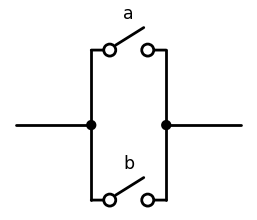

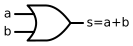

In [13]:
#@title
with schemdraw.Drawing() as d:
    d.config(unit=1.5)
    d += elm.Line().dot()
    d.push()
    d += elm.Line().up()
    d += elm.Switch().right().label('a')
    d += elm.Line().down()
    d.pop()
    d += elm.Line().down()
    d += elm.Switch().right().label('b')
    d += elm.Line().up().dot()
    d += elm.Line().right()

from schemdraw.parsing import logicparse
logicparse('a or b', outlabel='s=a+b')

Por fim, cabe ressaltar que esta fun√ß√£o √© tamb√©m N-√°ria, onde o n√∫mero de entradas √© maior ou igual a 2. A seguir est√£o as diferentes representa√ß√µes da fun√ß√£o **OR** na forma tern√°ria.

$a$|$b$|$c$|$\mbox{$a$+$b$+$c$}$
---|---|---|:-:
 0 | 0 | 0 | 0
 0 | 0 | 1 | 1
 0 | 1 | 0 | 1
 0 | 1 | 1 | 1
 1 | 0 | 0 | 1
 1 | 0 | 1 | 1
 1 | 1 | 0 | 1
 1 | 1 | 1 | 1

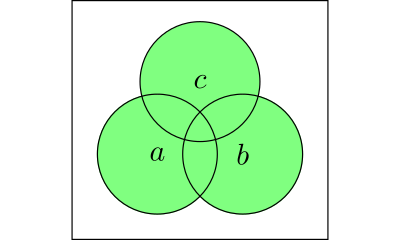

In [14]:
#@title
%%tikz -S test_output.tikz -f svg
\filldraw[fill=white] (-1,-1) rectangle (2,1.8);
\filldraw[green!50] (0,0) circle (20pt); % fundo verde A
\filldraw[green!50] (1,0) circle (20pt); % fundo verde B
\node[fill=green!50,draw,circle,minimum size=40pt] at (0.5,0.85) {$c$}; % C sobrescrevendo ambos
\node[draw,circle,minimum size=40pt] at (1,0) {$b$}; % B sem preechimento para repor a linha
\node[draw,circle,minimum size=40pt] at (0,0) {$a$}; % A sem preechimento para repor a linha

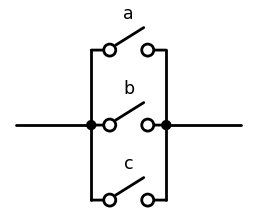

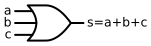

In [15]:
#@title
with schemdraw.Drawing() as d:
    d.config(unit=1.5)
    d += elm.Line().dot()
    d.push()
    d.push()
    d += elm.Line().up()
    d += elm.Switch().right().label('a')
    d += elm.Line().down()
    d.pop()
    d += elm.Switch().label('b')
    d.pop()
    d += elm.Line().down()
    d += elm.Switch().right().label('c')
    d += elm.Line().up().dot()
    d += elm.Line().right()

from schemdraw.parsing import logicparse
logicparse('a or b or c', outlabel='s=a+b+c')

O operador l√≥gico OR em Verilog √© denotado pelo caracter `|`. Vamos aproveitar a ocasi√£o para aprender dois novos conceitos em Verilog. O primeiro √© o de barramento (*bus*). No exemplo a seguir construimos uma porta OR de tr√™s entradas, no entanto, declaramos uma √∫nica porta de entrada com 3 fios. Os colchetes com o intervalo s√£o usados na declara√ß√£o antes do nome da porta para especificar a largura `[2:0]`. Eles tamb√©m s√£o usados para acessar uma parte do barramento (e. g. `[1:0]`) ou cada fio individualmente. O segundo conceito apresentado √© que os operadores l√≥gicos podem ser usados na forma de redu√ß√£o em um barramento. Na linha 9 escrevemos `|a`, o que quer dizer OR entre todos os bits de `a`.

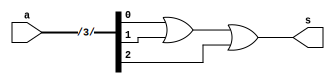

In [16]:
%%print_verilog -n or3.v

module or3(
  input [2:0] a,
  output s);
  // atribui√ß√£o usando o operador |
  assign s = a[0] | a[1] | a[2];
  // atribui√ß√£o usando o operador de redu√ß√£o |
  // assign s = |a;
  // estrutural
  // or G(s,a[0],a[1],a[2]);
endmodule

Vamos testar este m√≥dulo de forma um pouco diferente, usando o comando de c√©lula `%%verilog`, para aprender duas novas fun√ß√µes de console da linguagem. O ***test bench*** usado √© praticamente o mesmo da fun√ß√£o AND com as seguintes diferen√ßas:
  1. Usamos as mesmas vari√°veis de entrada/sa√≠da (linhas 5-6), mas ao instanciar o `dut` concatenamos as vari√°veis `{a, b, c}` para obter um barramento com 3 fios, conforme a entrada esperada;
  1. N√£o precisamos da fun√ß√£o `$dumpvars` j√° que n√£o vamos plotar o diagrama de formas de onda;
  1. Usamos a fun√ß√£o `$display` para imprimir um cabe√ßalho na console (linha 11);
  1. Usamos a fun√ß√£o `$monitor` para imprimir as vari√°veis sempre que alguma delas mudar de valor (linha 12);
  1. Removemos o atraso da primeira linha para que as entradas j√° comecem com valor definidos ao inv√©s de `x` (linha 13).

In [17]:
%%verilog
`include "or3.v"

module tb_or3;
  reg a, b, c;
  wire s;
  or3 dut({a, b, c}, s);

  initial
  begin
    $display("a|b|c||s\n-+-+-++-");
    $monitor("%b|%b|%b||%b", a, b, c, s);
       a=0; b=0; c=0;
    #5 a=0; b=0; c=1;
    #5 a=0; b=1; c=0;
    #5 a=0; b=1; c=1;
    #5 a=1; b=0; c=0;
    #5 a=1; b=0; c=1;
    #5 a=1; b=1; c=0;
    #5 a=1; b=1; c=1;
    $finish;
  end
endmodule

a|b|c||s
-+-+-++-
0|0|0||0
0|0|1||1
0|1|0||1
0|1|1||1
1|0|0||1
1|0|1||1
1|1|0||1
1|1|1||1



<h3>Fun√ß√£o <b>NOT</b> (N√ÉO)</h3>

A fun√ß√£o l√≥gica **NOT** possui uma √∫nica entrada ou operando (fun√ß√£o un√°ria) e resulta no inverso ou complemento da sua entrada. Ela pode ser representada pelo s√≠mbolo  $\sim$ ou $!$ antes da vari√°vel, pelo s√≠mbolo $'$ ap√≥s ela, ou ainda por um barra sobre o que se deseja negar/inverter. Portanto, sua tabela verdade tem apenas duas possibilidades:

$a$|$\bar{a}$
---|---
 0 | 1
 1 | 0

Supondo que deseja-se obter o inverso da fun√ß√£o $a+b$, podemos escrever $\sim(a+b)$ ou $!(a+b)$ ou $(a+b)'$ ou ainda $\overline{a+b}$, neste caso, sem a necessidade de par√™nteses.

Como veremos a seguir, se aplicamos esta fun√ß√£o em um diagrama de Venn invertemos suas regi√µes, assim como acontece em uma tabela verdade (invertemos a coluna inteira). Tamb√©m veremos, mais adiante, que inverter a sa√≠da de uma fun√ß√£o nem sempre equivale a inverter suas entradas.

A representa√ß√£o gr√°fica desta fun√ß√£o como **porta l√≥gica** √© apresentada a seguir.

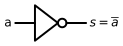

In [18]:
#@title
logicparse('not a', outlabel='$s=\overline{a}$')

Quando aplicada a entrada ou sa√≠da de outra porta l√≥gica no circuito pode ser abreviada, incluindo somente a $\circ$ (bolinha).

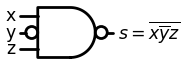

In [19]:
#@title
with schemdraw.Drawing() as d:
    d += logic.Nand(inputs=3, inputnots=[2]).label('x', loc='in1').label('y', loc='in2').label('z', loc='in3').label('$s=\overline{x\overline{y}z}$', loc='out')

Em Verilog podemos usar tanto `!` quanto `~` para o operador NOT. Podemos declarar sinais internos usando a palavra `wire` e fazer liga√ß√µes com eles.

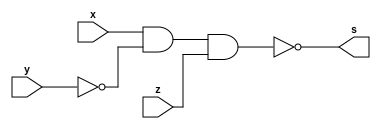

In [20]:
%%print_verilog -n not_xnyz.v

module not_xnyz(
  input x, y, z,
  output s);
  // declaramos um fio e o atribuimos
  wire not_y;
  assign not_y = !y;
  // atribui√ß√£o usando o operador ~
  assign s = ~(x & not_y & z);
endmodule

Vamos usar praticamente o mesmo ***test bench*** com esta fun√ß√£o, mas note que ela tem entradas com nomes diferentes. Podemos instanciar o m√≥dulo normalmente (`dut`), a liga√ß√£o √© feita pela posi√ß√£o, n√£o importam os nomes (linha 7). Ou podemos usar uma nota√ß√£o alternativa, na qual escolhemos explicitamente quais portas ser√£o ligadas em quais sinais (linha 8). Nesta segunda nota√ß√£o usamos um `.` seguido do nome original da porta (interno) e escevemos a seguir entre par√™nteses o nome do sinal (externo) a ser ligado nesta porta. Nela as portas podem ser ligadas em qualquer ordem, inclusive podemos omitir portas que n√£o desejarmos ligar. Note que usamos um nome de inst√¢ncia diferente (`uut`) j√° que este n√£o pode se repetir. Note tamb√©m que os dois m√≥dulos compartilham as mesmas entradas, mas precisamos de sa√≠das distintas para eles, sen√£o causar√≠amos um curto-circuito entre as sa√≠das.

In [21]:
%%verilog
`include "not_xnyz.v"

module tb_not_xnyz;
  reg a, b, c;
  wire s, t;
  not_xnyz dut(a, b, c, s);
  not_xnyz uut(.s(t), .x(a), .y(b), .z(c));

  initial
  begin
    $display("x|y|z||s|t\n-+-+-++-+-");
    $monitor("%b|%b|%b||%b|%b", a, b, c, s, t);
       a=0; b=0; c=0;
    #5 a=0; b=0; c=1;
    #5 a=0; b=1; c=0;
    #5 a=0; b=1; c=1;
    #5 a=1; b=0; c=0;
    #5 a=1; b=0; c=1;
    #5 a=1; b=1; c=0;
    #5 a=1; b=1; c=1;
    $finish;
  end
endmodule

x|y|z||s|t
-+-+-++-+-
0|0|0||1|1
0|0|1||1|1
0|1|0||1|1
0|1|1||1|1
1|0|0||1|1
1|0|1||0|0
1|1|0||1|1
1|1|1||1|1



<h3>Demais fun√ß√µes l√≥gicas (XOR, NAND, NOR e XNOR)</h3>

<h4>Portas l√≥gicas universais</h4>

Al√©m das portas l√≥gicas relativas √†s fun√ß√µes **NOT**, **AND** e **OR**, consideradas primitivas b√°sicas, h√° tamb√©m as varia√ß√µes **NAND** e **NOR**, nega√ß√µes das duas √∫ltimas. Elas s√£o chamadas portas universais, pois a partir delas podemos construir as outras tr√™s, como veremos adiante. A seguir √© apresentada uma tabela verdade com as suas respectivas sa√≠das para duas entradas (compare com as tabelas originais das fun√ß√µes **AND** e **OR**):

$a$|$b$|$\overline{\mbox{$a$.$b$}}$|$\overline{\mbox{$a$+$b$}}$
---|---|---|---
 0 | 0 | 1 | 1
 0 | 1 | 1 | 0
 1 | 0 | 1 | 0
 1 | 1 | 0 | 0

Suas portas l√≥gicas s√£o representadas das seguintes formas:

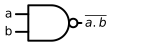

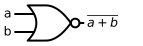

In [22]:
#@title
d = logicparse('a nand b', outlabel='$\overline{a.b}$')
d += elm.Gap(label=' ')

e = logicparse('a nor b', outlabel='$\overline{a+b}$')
e += elm.Gap(label=' ')

display(d, e)

As portas universais s√£o √∫teis aos fabricantes de semicondutores, pois assim s√≥ precisam fabricar um √∫nico tipo de porta l√≥gica e podem us√°-las para obter as demais. A seguir est√° a constru√ß√£o das primitivas **NOT**, **AND** e **OR** a partir das portas universais **NAND** e **NOR**:

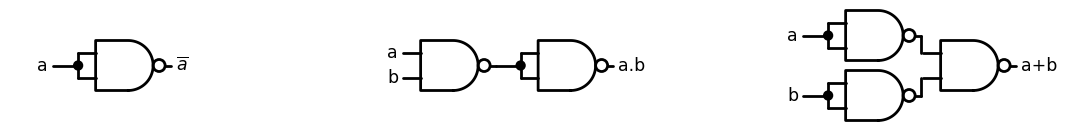

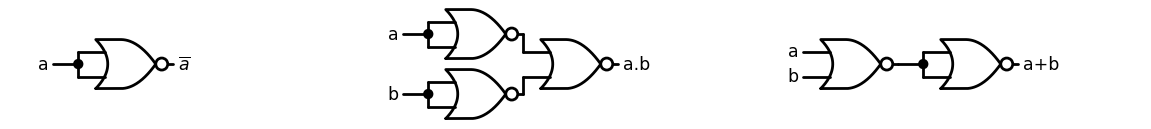

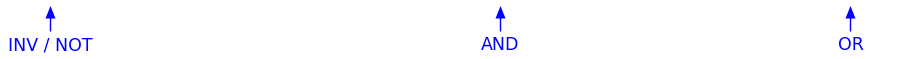

In [23]:
#@title
with schemdraw.Drawing() as d:
    # not
    d.config(unit=0.5)
    d += elm.Line().dot().label('a', loc='left')
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += logic.Nand().label('$\overline{a}$', loc='right')
    # and
    d.here = (7,0)
    d += logic.Nand().label('a', loc='in1').label('b', loc='in2')
    d += elm.Line().dot()
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += logic.Nand().label('a.b', loc='right')
    d += elm.Gap(label=' ').length(5)
    # or
    d.here = (15,-0.6)
    d += elm.Line().dot().label('b', loc='left')
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += (p1 := logic.Nand())
    d.push()
    d += elm.Line().up().length(0.35)
    d.pop()
    d.here = (15,0.6)
    d += elm.Line().dot().label('a', loc='left')
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += (p2 := logic.Nand())
    d.push()
    d += elm.Line().down().length(0.35)
    d.pop()
    d.here = (17.4,0)
    d += logic.Nand().label('a+b', loc='right')

with schemdraw.Drawing() as d:
    # not
    d.config(unit=0.5)
    d += elm.Line().dot().label('a', loc='left')
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += logic.Nor().label('$\overline{a}$', loc='right')
    # or
    d.here = (15,0)
    d += logic.Nor().label('a', loc='in1').label('b', loc='in2')
    d += elm.Line().dot()
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += logic.Nor().label('a+b', loc='right')
    d += elm.Gap(label=' ').length(5)
    # and
    d.here = (7,-0.6)
    d += elm.Line().dot().label('b', loc='left')
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += (p1 := logic.Nor())
    d.push()
    d += elm.Line().up().length(0.35)
    d.pop()
    d.here = (7,0.6)
    d += elm.Line().dot().label('a', loc='left')
    d.push()
    d.push()
    d += elm.Line().up().length(0.25)
    d.pop()
    d += elm.Line().down().length(0.25)
    d.pop()
    d += (p2 := logic.Nor())
    d.push()
    d += elm.Line().down().length(0.35)
    d.pop()
    d.here = (9.4,0)
    d += logic.Nor().label('a.b', loc='right')

with schemdraw.Drawing() as d:
    # not
    d += elm.Annotate().label('INV / NOT').delta(dx=0, dy=-0.5).linewidth(1).color('blue')
    # and
    d.here = (9,0)
    d += elm.Annotate().label('AND').delta(dx=0, dy=-0.5).linewidth(1).color('blue')
    # or
    d.here = (16,0)
    d += elm.Annotate().label('OR').delta(dx=0, dy=-0.5).linewidth(1).color('blue')


Embora nossa ferramenta n√£o use os s√≠mbolos pr√≥prios dessas portas para contruir o desenho do circuito, ela reconhece as primitivas b√°sicas `nand` e `nor` da linguagem Verilog. No exemplo a seguir usamos tamb√©m o operador de concatena√ß√£o `{}` para unir dois fios e gerar um barramento.

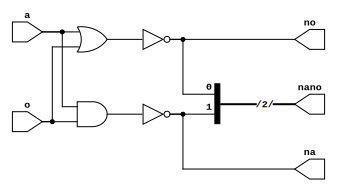

In [24]:
%%print_verilog -n nandnor.v

module nandnor(
  input a, o,
  output na, no,
  output [1:0] nano);
  nand (na, a, o);
  nor (no, a, o);
  assign nano = {na,no};
endmodule

Escreva um ***test bench*** para esta fun√ß√£o na c√©lula abaixo, combinando os conceitos aprendidos para plotar a forma de onda e tamb√©m para imprimir na console, compare sua sa√≠da com a do gabarito logo abaixo. Note que ele usa vetores para a sa√≠da `nano`, ent√£o os valores s√£o plotados em hexadecimal.

In [ ]:
%%wavedrom
`include "nandnor.v"

// escreva seu test bench aqui

VCD info: dumpfile dump.vcd opened for output.
a|o||na|no|nano
-+-++--+--+----
x|x|| x| x|  x
0|0|| 1| 1|  3
0|1|| 1| 0|  2
1|0|| 1| 0|  2
1|1|| 0| 0|  0



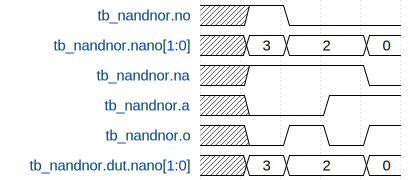

In [26]:
#@title
%%wavedrom
`include "nandnor.v"

module tb_nandnor;
  reg a, o;
  wire na, no;
  wire [1:0] nano;
  nandnor dut(a, o, na, no, nano);

  initial
  begin
    $dumpvars(0);
    $display("a|o||na|no|nano\n-+-++--+--+----");
    $monitor("%b|%b||%2b|%2b|%3d", a, o, na, no, nano);
    #5 a=0; o=0;
    #5 a=0; o=1;
    #5 a=1; o=0;
    #5 a=1; o=1;
    $finish;
  end
endmodule

<h4>Portas l√≥gicas aritm√©ticas</h4>

A fun√ß√£o l√≥gica **XOR** (OU exclusivo), representada pelos s√≠mbolos $\oplus$ ou $\underline{\lor}$ e sua complementar **XNOR** s√£o  chamadas portas artim√©ticas. Por defini√ß√£o, a sa√≠da da fun√ß√£o l√≥gica **XOR** √© verdadeira ***se e somente se apenas uma das entradas forem verdadeiras***\*. A partir desta defini√ß√£o, podemos obter sua tabela verdade:

$a$|$b$|$a$ $\oplus$ $b$
---|---|:-:
 0 | 0 | 0
 0 | 1 | 1
 1 | 0 | 1
 1 | 1 | 0

 A representa√ß√£o gr√°fica das portas l√≥gicas XOR e XNOR s√£o as seguintes:

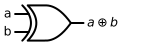

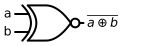

In [27]:
#@title
d = logicparse('a xor b', outlabel='$a \oplus b$')
d += elm.Gap(label=' ')

e = logicparse('a xnor b', outlabel='$\overline{a \oplus b}$')
e += elm.Gap(label=' ')

display(d, e)

A porta **XOR**, quando constru√≠da com mais de duas entradas, pode ser interpretada de duas formas distintas:

1. Conforme a defini√ß√£o anterior\*;
2. Como uma geradora de paridade √≠mpar, ou seja, sua sa√≠da ser√° verdadeira quando o n√∫mero de entradas verdadeiras for √≠mpar.

O mesmo acontece com a porta **XNOR**, por√©m com o inverso das sa√≠das nos dois casos.

A primeira interpreta√ß√£o est√° mais ligada ao rigor matem√°tico e n√£o √© seguida pelas linguagens de descri√ß√£o de hardware e seus simuladores, que costumam implementar portas de v√°rias entradas pela cascata de portas de duas entradas, resultando nos geradores de paridade mencionados.

Estranhamente nossa ferramenta de desenho tem s√≠mbolos pr√≥prios para essas duas portas l√≥gicas.

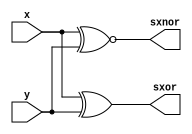

In [28]:
%%print_verilog

module exnor(
  input x, y,
  output sxor, sxnor);
  assign sxor = x ^ y;
  assign sxnor = x ~^ y;
endmodule

<h2>Gere uma tabela verdade com n entradas para as fun√ß√µes l√≥gicas e observe cada uma delas para ver se compreendeu:</h2>

In [29]:
#@title
def n_bits_table(n,op):
  if ( int(n) > 7 ):
    print("A tabela cresce exponencialmente, use valores pequenos de n")
    return
  vars = []
  eq = ""
  pre = ""
  suf = ""
  if op== 'nand' or op== 'nor':
    pre = "not("
    op = op[1:]
    suf = ")"
  eq = pre
  for i in range(int(n)):
    vars.append("a"+str(i))
    eq += " a"+str(i)+" "+op
  vars.reverse()
  eq = eq[:-3]
  eq += suf
  leq = []
  leq.append(eq)
  table = ttg.Truths(vars,leq)
# table.as_pandas().style.set_properties(**{'text-align':'center'}).hide_index()
  pd = table.as_pandas()
  pd = pd.reindex(index=pd.index[::-1])
  l = []
  for i in range(pd.shape[0]):
    l.append(i)
  pd['linha'] = l
  pd = pd.set_index('linha')
  print (pd.to_string(justify='center'))

print("Selecione a opera√ß√£o l√≥gica e digite um valor para n")
dummy = interact(n_bits_table,n="3",op=['and','or','xor','nand','nor'])


Selecione a opera√ß√£o l√≥gica e digite um valor para n


interactive(children=(Text(value='3', description='n'), Dropdown(description='op', options=('and', 'or', 'xor'‚Ä¶

## Formas de Representa√ß√£o

Como j√° vimos, uma fun√ß√£o l√≥gica ou Booleana pode ter diversas formas de representa√ß√£o: equa√ß√£o, tabela verdade, portas l√≥gicas e circuitos com chaves em s√©rie e paralelo. Existem outras formas que veremos a seguir.

Cada representa√ß√£o tem vantagens e desvantagens para especifica√ß√£o e manipula√ß√£o. Por exemplo, a tabela verdade √© a espefica√ß√£o completa da fun√ß√£o. A tabela pode ser usada para verificar a equival√™ncia de duas fun√ß√µes.  Por√©m o n√∫mero de linhas cresce exponencialmente com o n√∫mero de entradas. Uma tabela com $n$ vari√°veis ter√° $2^n$ linhas.

Uma equa√ß√£o pode ser uma forma mais compacta que a tabela. Al√©m disso, permite usar √°lgebra booleana para manipul√°-la e simplific√°-la.

Para exemplificar os conceitos aprendidos at√© agora, vamos considerar a fun√ß√£o l√≥gica $f$ dada (qual foi o crit√©rio para obter esta fun√ß√£o n√£o vem ao caso agora) pela tabela a seguir:

 a | b | c ||$f$
---|---|---||---
 0 | 0 | 0 || 0
 0 | 0 | 1 || 0
 0 | 1 | 0 || 0
 0 | 1 | 1 || 0
 1 | 0 | 0 || 1
 1 | 0 | 1 || 1
 1 | 1 | 0 || 1
 1 | 1 | 1 || 0

A partir desta tabela, podemos obter o diagrama de Venn correspondente:







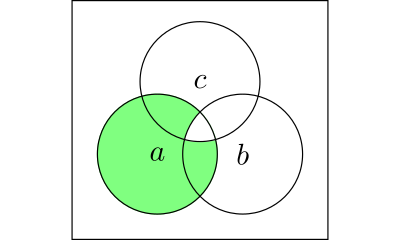

In [30]:
#@title
%%tikz -S test_output.tikz -f svg
\filldraw[fill=white] (-1,-1) rectangle (2,1.8);
\filldraw[green!50] (0,0) circle (20pt);
\begin{scope}
  \clip (0,0) circle (20pt);
  \clip (1,0) circle (20pt);
  \filldraw[white] (0.5,0.85) circle (20pt);
\end{scope}
\node[draw,circle,minimum size=40pt] at (0,0) {$a$};
\node[draw,circle,minimum size=40pt] at (1,0) {$b$};
\node[draw,circle,minimum size=40pt] at (0.5,0.85) {$c$};

Note que h√° uma correspond√™ncia exata entre as duas representa√ß√µes, pois cada linha da tabela verdade tem uma √°rea correspondente no diagrama de Venn e vice-versa.

Se quisermos uma express√£o poss√≠vel para esta fun√ß√£o l√≥gica, podemos olhar para suas sa√≠das verdadeiras e fazer uma uni√£o entre elas (veremos como isso se chama mais adiante). Obtemos a express√£o $a\bar{b}\bar{c}+a\bar{b}c+ab\bar{c}$, que corresponde ao circuito:

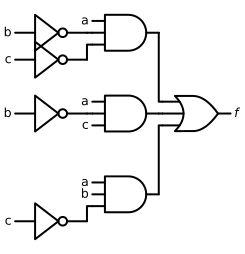

In [31]:
#@title
logicparse('a and not b and not c or a and not b and c or a and b and not c', outlabel='$f$')

No entanto, esta n√£o √© a √∫nica forma de implementar esta fun√ß√£o l√≥gica e, se observarmos a tabela verdade atentamente, podemos concluir que as express√µes $a(\bar{b}+\bar{c})$ e $a\bar{b}+a\bar{c}$ apresentam exatamente a mesma sa√≠das e seus circuitos correspondentes s√£o muito mais simples:

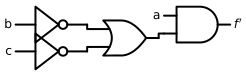

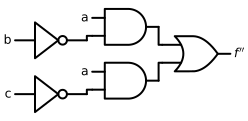

In [32]:
#@title
x=logicparse('a and (not b or not c)', outlabel="$f'$")
y=logicparse('a and not b or a and not c', outlabel="$f''$")
display(x,y)

Podemos usar Diagramas de Venn ou Tabelas Verdade para conferir se a fun√ß√µes s√£o realmente equivalentes. No caso dos diagramas, pegamos cada uma das vari√°veis separadamente, em sua forma original ou negada, e as combinamos por meio da uni√£o (OR) ou intersec√ß√£o (AND) das √°reas at√© obter a fun√ß√£o resultante. Embora os diagramas intermedi√°rios possam ser diferentes, o resultante deve ser exatamente igual ao que apresentamos no in√≠cio desta se√ß√£o. Usando a Tabela Verdade o processo √© similar, vamos adicionando colunas para os termos da express√£o at√© obter a express√£o final:

a|b|c||$f$||$\bar{b}$|$\bar{c}$|$\mbox{$\bar{b}$+$\bar{c}$}$|$\mbox{$a(\bar{b}$+$\bar{c}$)}$|$a\bar{b}$|$a\bar{c}$|$a\bar{b}+a\bar{c}$|
-|-|-||------------||---|---|:-:|:-:|:-:|:-:|:-:|
0|0|0||$\textbf{0}$||1|1|1|$\textbf{0}$|0|0|$\textbf{0}$|
0|0|1||$\textbf{0}$||1|0|1|$\textbf{0}$|0|0|$\textbf{0}$|
0|1|0||$\textbf{0}$||0|1|1|$\textbf{0}$|0|0|$\textbf{0}$|
0|1|1||$\textbf{0}$||0|0|0|$\textbf{0}$|0|0|$\textbf{0}$|
1|0|0||$\textbf{1}$||1|1|1|$\textbf{1}$|1|1|$\textbf{1}$|
1|0|1||$\textbf{1}$||1|0|1|$\textbf{1}$|1|0|$\textbf{1}$|
1|1|0||$\textbf{1}$||0|1|1|$\textbf{1}$|0|1|$\textbf{1}$|
1|1|1||$\textbf{0}$||0|0|0|$\textbf{0}$|0|0|$\textbf{0}$|

Vejamos suas implementa√ß√µes a seguir para provar tamb√©m a equivalencia:

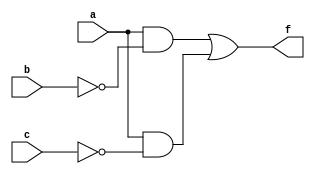

In [33]:
%%print_verilog -n fabc.v

module fabc(input a, b, c, output f);
  assign f = (a & ~b & ~c) | (a & ~b & c) | (a & b & ~c);
endmodule

module fabc1(input a, b, c, output f);
  assign f = a & (~b | ~c);
endmodule

module fabc2(input a, b, c, output f);
  assign f = (a & ~b) | (a & ~c);
endmodule

Em nosso teste, vamos usar um arquivo texto (`values.tv`) contendo o que chamamos de **vetores de teste** (*tv = test vectors*). Nele colocamos os valores em bin√°rio ou hexadecimal de acordo com a tabela verdade da fun√ß√£o. As tr√™s primeiras colunas correspondem √†s entradas `a`, `b` e `c` e a √∫ltima coluna √© a sa√≠da esperada, ou seja, $\sum m(4,5,6)$. O caracter `_` √© ignorado neste tipo de arquivo e foi usado apenas para separar as entradas da sa√≠da esperada.

In [34]:
%%writefile values.tv
000_0
001_0
010_0
011_0
100_1
101_1
110_1
111_0


Writing values.tv


Por conter um arquivo externo com os est√≠mulos e as sa√≠das esperadas, o teste a seguir tem algumas novas particularidades:
  1. Al√©m das entradas, declaramos um `reg` para a sa√≠da esperada `e` (linha 5);
  1. Para carregar os valores do arquivo, declaramos um vetor de barramentos, algo como uma matriz, chamada `values` (linha 7). Nesta declara√ß√£o temos um primeiro √≠ndice antes do nome `[3:0]` que especifica a largura do arquivo que vamos ler. O segundo √≠ndice, que fica depois do nome `[0:7]`, indica o n√∫mero de linhas do arquivo e tem o seu intervalo especificado em ordem crescente (ao contr√°rio da largura);
  1. Declaramos um vari√°vel inteira, que em Verilog tem 32 bits, para percorrer os casos de teste (linha 8);
  1. Instanciamos as tr√™s fun√ß√µes, note que cada uma precisa de um nome de inst√¢ncia diferente (linhas 10-12);
  1. Usamos a fun√ß√£o `$readmemb` para carregar o conte√∫do do arquivo para o vetor de testes (linha 17);
  1. Usamos um bloco de repeti√ß√£o `for` para:

      a) Carregar as entradas das fun√ß√µes e a sa√≠da esperada do vetor de testes (linhas 20-23);    
      b) Aguardar `#5`;  
      c) Verificar se a sa√≠da de cada uma das fun√ß√µes corresponde √† sa√≠da esperada (linhas 25-30).

N√≥s criamos este arquivo externo de vetor de testes especialmente para informar as sa√≠das esperadas, pois as entradas poderiam ser obtidas diretamente a partir dos bits da vari√°vel `i`, conforme os coment√°rios no c√≥digo:

VCD info: dumpfile dump.vcd opened for output.



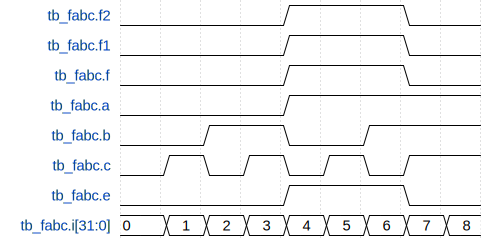

In [35]:
%%wavedrom
`include "fabc.v"

module tb_fabc;
  reg a, b, c, e;
  wire f, f1, f2;
  reg [3:0] values [0:7];
  integer i;

  fabc  dut (a, b, c, f);
  fabc1 dut1(a, b, c, f1);
  fabc2 dut2(a, b, c, f2);

  initial
  begin
    $dumpvars(1);
    $readmemb("values.tv", values);
    for (i=0; i<8; i=i+1)
    begin
      a = values[i][3]; // o mesmo que i[2];
      b = values[i][2]; // o mesmo que i[1];
      c = values[i][1]; // o mesmo que i[0];
      e = values[i][0];
      #5;
      if (f != e)
        $display("Erro no vetor %0d da fun√ß√£o fabc, esperado %b, obtido %b!", i, e, f);
      if (f1 != e)
        $display("Erro no vetor %0d da fun√ß√£o fabc1, esperado %b, obtido %b!", i, e, f);
      if (f2 != e)
        $display("Erro no vetor %0d da fun√ß√£o fabc2, esperado %b, obtido %b!", i, e, f);
    end
    $finish;
  end
endmodule

## Formas can√¥nicas (*mintermos* e *maxtermos*)

Chamamos de **forma can√¥nica** da fun√ß√£o l√≥gica aquela que tem todos termos completos (com todas as vari√°veis). Ela pode ser gerada pela soma dos produtos (**SOP**), realizando um **somat√≥rio dos *mintermos***  (saidas 1) ou pelo produto das somas (**POS**), realizando o **produto dos *maxtermos*** (saidas 0). Vejamos a lista completa desses termos para uma fun√ß√£o de tr√™s entradas:

\#|a|b|c||*mintermo*|*maxtermo*|
-|-|-|-||:-:|:-:|
0|0|0|0||$\bar{a}\bar{b}\bar{c}$|$\mbox{$a$+$b$+$c$}$|
1|0|0|1||$\bar{a}\bar{b}c$      |$\mbox{$a$+$b$+$\bar{c}$}$|
2|0|1|0||$\bar{a}b\bar{c}$      |$\mbox{$a$+$\bar{b}$+$c$}$|
3|0|1|1||$\bar{a}bc$            |$\mbox{$a$+$\bar{b}$+$\bar{c}$}$|
4|1|0|0||$a\bar{b}\bar{c}$      |$\mbox{$\bar{a}$+$b$+$c$}$|
5|1|0|1||$a\bar{b}c$            |$\mbox{$\bar{a}$+$b$+$\bar{c}$}$|
6|1|1|0||$ab\bar{c}$            |$\mbox{$\bar{a}$+$\bar{b}$+$c$}$|
7|1|1|1||$abc$                  |$\mbox{$\bar{a}$+$\bar{b}$+$\bar{c}$}$|

Voltando √† nossa fun√ß√£o do exemplo anterior $a\bar{b}\bar{c}+a\bar{b}c+ab\bar{c}$, notamos que ela est√° na forma can√¥nica de SOP e podemos escrev√™-la assim: $f(a,b,c) = \sum m(4,5,6)$, ou seja, uma soma (OR) das sa√≠das **1**. Tamb√©m podemos escrev√™-la na forma can√¥nica de POS como $(a+b+c)(a+b+\bar{c})(a+\bar{b}+c)(a+\bar{b}+\bar{c})(\bar{a}+\bar{b}+\bar{c})$ ou assim: $f(a,b,c) = \Pi M(0,1,2,3,7)$ que significa o produto (AND) das sa√≠das **0**.



## Minimiza√ß√£o de fun√ß√µes l√≥gicas

A partir da fun√ß√£o do exemplo anterior, pudemos notar que a forma can√¥nica n√£o √© a que apresenta o menor custo de implementa√ß√£o e que consegimos representar a mesma fun√ß√£o com um n√∫mero menor de portas l√≥gicas. A seguir veremos algumas formas de simplifica√ß√£o de fun√ß√µes l√≥gicas.



### √Ålgebra Booleana

George Boole, um matem√°tico ingl√™s, introduziu em 1847 o sistema alg√©brico que mais tarde receberia o seu nome (**√Ålgebra de Boole**). A partir das fun√ß√µes l√≥gicas b√°sica j√° abordadas:

* OU (OR)
  - 0 + 0 = 0
  - 0 + 1 = 1
  - 1 + 0 = 1
  - 1 + 1 = 1 $\dagger$
* E (AND)
  - 0 . 0 = 0
  - 0 . 1 = 0
  - 1 . 0 = 0
  - 1 . 1 = 1
* N√ÉO (NOT)
  - ~0 = 1
  - ~1 = 0

podemos inferir alguns dos seus teoremas fundamentais:

* Idempotente
  - a + a = a $\dagger$
  - a . a = a $\dagger$
* Absorvente
  - a + 1 = 1 $\dagger$
  - a . 0 = 0
* Neutro
  - a + 0 = a
  - a . 1 = a
* Complementar
  - a + ~a = 1
  - a . ~a = 0
* Dupla nega√ß√£o
  - ~ (~a) = a

e tamb√©m alguns axiomas:

* Comutatividade
  - a + b = b + a
  - a . b = b . a
* Associatividade
  - (a + b) + c = a + (b + c)
  - (a . b) . c = a . (b . c)
* Absortividade
  - a + (a . b) = a $\dagger$
  - a . (a + b) = a $\dagger$
* Distributividade
  - a + (b . c) = (a + b) . (a + c) $\dagger$
  - a . (b + c) = (a . b) + (a . c)
* De Morgan
  - ~a + ~b = ~(a . b)
  - ~a . ~b = ~(a + b)

$\dagger$ note que estas propriedades n√£o s√£o v√°lidas na √°lgebra convencional.

### Manipula√ß√£o alg√©brica de fun√ß√µes l√≥gicas

Podemos usar a √Ålgebra Booleana para simplificar express√µes l√≥gicas. Voltando ao nosso exemplo, podemos partir da express√£o original, na forma can√¥nica:

$a\bar{b}\bar{c}+a\bar{b}c+ab\bar{c}$

colocando $a$ em evid√™ncia a partir da **distributividade** temos

$a(\bar{b}\bar{c}+\bar{b}c+b\bar{c})$

replicamos o termo $\bar{b}\bar{c}$ usando a **idempotente** e temos

$a(\bar{b}\bar{c}+\bar{b}\bar{c}+\bar{b}c+b\bar{c})$

trocamos a ordem dos termos usando a **comutatividade** temos

$a(\bar{b}\bar{c}+\bar{b}c+\bar{b}\bar{c}+b\bar{c})$

trocamos a ordem das vari√°veis dos dois √∫ltimos termos usando **comutatividade** e temos

$a(\bar{b}\bar{c}+\bar{b}c+\bar{c}\bar{b}+\bar{c}b)$

usando novamente a **distributividade** dentro dos par√™nteses temos

$a(\bar{b}[\bar{c}+c]+\bar{c}[\bar{b}+b])$

a partir da **complementar** temos

$a(\bar{b}.1+\bar{c}.1)$

finalmente a partir do elemento **neutro** temos

$a(\bar{b}+\bar{c})$

que √© justamente uma das fun√ß√µes equivalentes do nosso exemplo anterior, j√° demonstrado na tabela verdade. A outra fun√ß√£o equivalente tamb√©m listada na mesma tabela pode ser obtida usando a **distributividade** para obter

$a\bar{b}+a\bar{c}$

Embora a manipula√ß√£o alg√©brica seja uma alternativa vi√°vel para simplificar express√µes, nem sempre a ordem das transforma√ß√µes √© evidente, pois a t√©cnica requer um pouco de pr√°tica. Para demonstrar que duas fun√ß√µes s√£o equivalente temos a mesma dificuldade, mas neste caso podemos levar ambos os lados para a forma can√¥nica, ordenar os termos e eliminar os repetidos para facilitar a prova.


Se voc√™ quiser fazer mais manipula√ß√µes com a √°lgebra Booleana usando alguns pacotes em Python, [visite este Colab](https://colab.research.google.com/drive/1y31hX5Wq2WycFEMu-wza-aKWvCQWlSQw?usp=sharing).



### Mapas de Karnaugh

Os **Mapas de Karnaugh** s√£o representa√ß√µes espaciais das fun√ß√µes l√≥gicas que facilitam identificar vari√°veis irrelevantes nos termos e simplific√°-los.

Nos mapas de Karnaugh, quando temos duas vari√°veis em uma dimens√£o, as duas √∫ltimas colunas s√£o invertidas, para que possamos notar as vizinhan√ßas corretamente. Al√©m disso, a primeira e a √∫ltima coluna s√£o consideradas vizinhas, como se o mapa formasse um cilindo. Assim, a ordem dos *mintermos* em um mapa de tr√™s vari√°veis √© a seguinte:


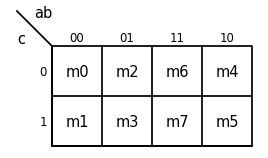

In [36]:
#@title
logic.Kmap(names='abc',
           truthtable=[('000', 'm0'),
                       ('001', 'm1'),
                       ('010', 'm2'),
                       ('011', 'm3'),
                       ('100', 'm4'),
                       ('101', 'm5'),
                       ('110', 'm6'),
                       ('111', 'm7')])

Vamos usar novamente nossa fun√ß√£o $f(a,b,c) = \sum m(4,5,6)$ para demonstrar sua simplifica√ß√£o em um mapa de 3 vari√°veis. Preenchendo a sa√≠da da tabela verdade no mapa temos:

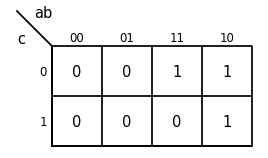

In [37]:
#@title
logic.Kmap(names='abc',
           truthtable=[('100', '1'),
                       ('101', '1'),
                       ('110', '1')])

Agora vamos listar alguns conceitos importantes para poder usar os Mapas de Karnaugh efetivamente:

*   **Implicante**: conjunto cont√≠guo de $2^n$ mintermos;
*   **Implicante primo**: aquele que n√£o pode ser expandido;
*   **Implicante primo essencial**: aquele que tem ao menos um mintermo que n√£o faz parte de nenhum outro implicante;
*   **Cobertura**: conjunto de implicantes que define o valor 1 para a fun√ß√£o.



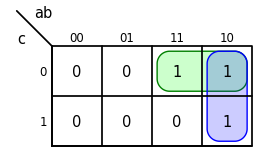

In [38]:
#@title
logic.Kmap(names='abc',
           truthtable=[('100', '1'),
                       ('101', '1'),
                       ('110', '1')],
           groups={'1.0': {'color' : 'green', 'fill': '#00ff0033'},
                   '10.': {'color' : 'blue', 'fill': '#0000ff33'}})

$\color{green}{a\bar{b}}+\color{blue}{a\bar{c}}$

Cada implicante no mapa corresponde a um termo da nossa fun√ß√£o. Se ele s√≥ tem um mintermo, logo tem todas as vari√°veis. Se ele tem dois mintermos, verificamos qual a vari√°vel que muda de um para outro e a eliminamos. Assim, a cada expans√£o de um implicante uma vari√°vel √© eliminada.

Para minimizar a fun√ß√£o usando um Mapa de Karnaugh, preenchemos suas sa√≠das no mapa, de acordo com a posi√ß√£o correta de cada mintermo/maxtermo. Depois encontramos os **implicantes primos essenciais** e verificamos se eles oferecem a **cobertura da fun√ß√£o**. Se necess√°rio, incluimos **implicantes primos n√£o essenciais** at√© obter a cobertura da fun√ß√£o.

O mesmo procedimento pode ser realizado para obter um **produto das somas** m√≠nimo, **selecionando os maxtermos** ao inv√©s dos mintermos e segundo os mesmos passos. Neste caso, os termos extra√≠do s√£o de soma e t√™m as vari√°veis invertidas.

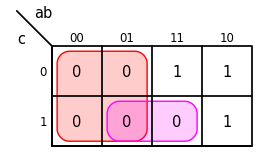

In [39]:
#@title
logic.Kmap(names='abc',
           truthtable=[('100', '1'),
                       ('101', '1'),
                       ('110', '1')],
           groups={'0..': {'color' : 'red', 'fill': '#ff000033'},
                   '.11': {'color' : 'magenta', 'fill': '#ff00ff33'}})

$\color{red}{a}.\color{magenta}{(\bar{b}+\bar{c})}$

## Fun√ß√µes com especifica√ß√µes incompletas (*don't care*)

Em alguma situa√ß√µes, podemos especificar fun√ß√µes l√≥gicas em que a sa√≠da n√£o importa para determinadas entradas. Pense, por exemplo, em um port√£o de correr com sensores de final de curso dos dois lados. Eles nunca seriam acionados ao mesmo tempo, j√° que o port√£o chegar√° ao final do trilho de um lado ou do outro em determinado momento, mas nunca aos dois lados ao mesmo tempo.

Voltando a nossa fun√ß√£o inicial, imagine que queremos garantir que ela seja 1 para os mesmos mintermos 4, 5 e 6, e 0 para os demais, por√©m a sa√≠da para as entradas em que ($b=1, c=1$) n√£o nos importa, j√° que sabemos que elas nunca acontecem. Especificamos a fun√ß√£o assim $f(a,b,c) = \sum m(4,5,6)+d(3,7)$

No Mapa de Karnaugh usamos a letra `d` neste mintermo, que se torna um curinga, ou seja, pode ou n√£o ser usado de acordo com a conveni√™ncia.

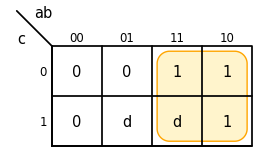

In [40]:
#@title
logic.Kmap(names='abc',
           truthtable=[('100', '1'),
                       ('101', '1'),
                       ('110', '1'),
                       ('011', 'd'),
                       ('111', 'd')],
           groups={'1..': {'color' : 'orange', 'fill': '#ffcc0033'}})


## Exerc√≠cios de fixa√ß√£o

### Para cada uma das fun√ß√µes a seguir, forne√ßa:

- Sua tabela verdade com as colunas passo a passo;
- Seu diagrama de Venn final, obtido a partir dos respectivos diagramas de cada termo;
- Seu circuito correspondente;
- Sua forma m√≠nima em SOP ou POS;
- Seu circuito correspondente (ap√≥s simplifica√ß√£o);
- Suas implementa√ß√µes em Verilog;
- Um *test bench* que compare suas implementa√ß√µes.

1. $f(x,y,z)=\sum m(0,1,4,5)$
2. $f(x,y,z)=\sum m(0,1,2,3,4,6)$
5. $f(x,y,z)=\sum m(0,1,2,6)+D(3,4)$
3. $f(x,y,z)=\Pi M(0,1,4,5)$
4. $f(x,y,z)=\Pi M(0,1,2,4,5,7)$
6. $f(x,y,z)=\Pi M(0,1,2,4)+D(3,5,7)$

Voc√™ pode usar a c√©lula abaixo para corrigir parte dos exerc√≠cios, basta digitar a fun√ß√£o l√≥gica que obteve e conferir a tabela verdade (*se tiver d√∫vidas, confira na m√£o, pois a ferramenta usada tem problemas de associatividade*). Se preferir, voc√™ pode tamb√©m usar este [Colab com tabelas verdade](https://colab.research.google.com/drive/1zQVrOKWSwL47gXALfVCIzidrcG3vXqq3?usp=sharing).

In [41]:
#@title
from IPython.display import Markdown
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd

def dm(s):
  display(Markdown(s))

def eqn_bits_table(n,eq):
  if ( int(n) > 7 ):
    print("A tabela cresce exponencialmente, use valores pequenos de n")
    return
  vars = []
  for i in range(int(n)):
    vars.append("a"+str(i))

  vars.reverse()
  leq = []
  leq.append(eq)
  table = ttg.Truths(vars,leq)
# table.as_pandas().style.set_properties(**{'text-align':'center'}).hide_index()
  pd = table.as_pandas()
  pd = pd.reindex(index=pd.index[::-1])
  l = []
  for i in range(pd.shape[0]):
    l.append(i)
  pd['linha'] = l
  pd = pd.set_index('linha')
  print (pd.to_string(justify='center'))

dm('## Gerando a tabela para uma equa√ß√£o com N vari√°veis')

dm("Escreva uma equa√ß√£o com n vari√°veis")
dm("Exemplo n=3, equacao a0 or a1 and a2")

dummy = interact(eqn_bits_table,n="3",eq="a0 or a1 and a2")


## Gerando a tabela para uma equa√ß√£o com N vari√°veis

Escreva uma equa√ß√£o com n vari√°veis

Exemplo n=3, equacao a0 or a1 and a2

interactive(children=(Text(value='3', description='n'), Text(value='a0 or a1 and a2', description='eq'), Outpu‚Ä¶

# Sistemas de Numera√ß√£o

Estamos acostumados com o sistema decimal para contar coisas e fazer opera√ß√µes matem√°ticas. Os computadores, como j√° vimos, trabalham com o sistema bin√°rio (base dois). Algumas linguagens computacionais compreendem base oito e dezesseis, pois s√£o pot√™ncias de dois e podem ser representadas facilmente por conjuntos de bits. Vejamos a seguir como os sistemas de numera√ß√£o funcionam, como converter numeros entre eles e como realizar opera√ß√µes aritm√©ticas nos computadores.

### Sistema Decimal
Um n√∫mero **decimal** √© representado com a nota√ß√£o posicional, onde cada d√≠gito tem um peso em pot√™ncia de 10.

Por exemplo, $x=251 = $ **2**  $\cdot 10^2 + $ **5**  $\cdot 10^1 +$ **1** $\cdot 10^0$.

Posi√ß√£o | 2 | 1 | 0
--|--|--|--
Pot√™ncia | $10^2$ | $10^1$ | $10^0$
numero | $\boxed{2}$ | $\boxed{5}$  | $\boxed{1}$

### Sistema Bin√°rio

Em bin√°rio temos apenas 2 d√≠gitos **0** e **1**. Podemos representar qualquer n√∫mero na nota√ß√£o posicional com pot√™ncias de 2.

Posi√ß√£o | 4| 3 |2 | 1 | 0
--|--|--|--|--|--
Pot√™ncia | $2^4$| $2^3$| $2^2$ | $2^1$ | $2^0$
numero | $\boxed{1}$ | $\boxed{0}$  | $\boxed{1}$ | $\boxed{0}$  | $\boxed{0}$
bits | $b_4$ | $b_3$ | $b_2$ | $b_1$| $b_0$


<h3>Convers√£o de Bin√°rio para Decimal e vice-versa</h3>

Para converter, multiplicamos cada d√≠gito bin√°rio pela sua pot√™ncia de 2 e somamos.

Um n√∫mero bin√°rio com $n$ bits ter√° o valor em decimal = $ \sum_{i}^{n-1} b_i \cdot 2^i = b_{n-1} \cdot 2^{n-1}+ \ldots + b_{1} \cdot 2^{1}+b_{0} \cdot 2^{0}$.


Por exemplo:

Posi√ß√£o | 4| 3 |2 | 1 | 0
--|--|--|--|--|--
Pot√™ncia | $2^4$| $2^3$| $2^2$ | $2^1$ | $2^0$
numero | $\boxed{1}$ | $\boxed{0}$  | $\boxed{1}$ | $\boxed{0}$  | $\boxed{0}$
bits | $b_4$ | $b_3$ | $b_2$ | $b_1$| $b_0$
| 16 | 8 | 4 | 2 | 1
decimal = 20 = | 1*16+ | 0+ | 1*4 +| 0+ | 0


<h4>Convers√£o de Decimal para Bin√°rio</h4>

A convers√£o de Decimal em bin√°rio pode ser feita pelo m√©todo da divis√£o. A cada divis√£o, descobrimos um d√≠gito bin√°rio:

$D = b_{n-1} \cdot 2^{n-1}+ \ldots + b_{1} \cdot 2^{1}+b_{0} \cdot 2^{0}$

$D/2 = b_{n-1} \cdot 2^{n-2}+ \ldots + b_{1} \cdot 2^{0}, \mbox{resto da divis√£o} = b_{0}$

$D/2/2 = b_{n-2} \cdot 2^{n-3}+ \ldots + b_{2} \cdot 2^{0}, \mbox{resto da divis√£o} = b_{1}$

$\ldots$

A tabela abaixo ilustra a convers√£o do n√∫mero 26. Lembre-se que √© a divis√£o **inteira** e seu resto.

D | Divisao | Resto | Bit
--|--|--|--
26 | 13 | $\boxed{0}$ | $b_0$
13 | 6  | $\boxed{1}$ | $b_1$
6  | 3 | $\boxed{0}$ | $b_2$
3 | 1 | $\boxed{1}$ | $b_3$
1 | 0 | $\boxed{1}$ | $b_4$

Portanto D em bin√°rio ser√° a sequ√™ncia gerada pelo resto das divis√£o na ordem invertida (da √∫ltima linha para a primeira).

$D = \frac{b_4}{\boxed{1}} \frac{b_3}{\boxed{1}} \frac{b_2}{\boxed{0}} \frac{b_1}{\boxed{1}} \frac{b_0}{\boxed{0}} = 26_{decimal}$







In [42]:
#@title
def dm(s):
  display(Markdown(s))

from ipywidgets import interact, interactive, fixed, interact_manual
def bin2dec(Decimal,Binario):
  try:
    decimal = int(Decimal)
    binario = int(Binario, 2)
    if (decimal == binario):
      dm("Conversao correta!")
    else:
      dm("O valor n√£o corresponde, favor refazer.")
  except:
    dm("Formato incorreto!")

dm('## Execute a c√©lula para verificar a correspond√™ncia de n√∫meros em  Decimal e Binario. Modifique os valores.')

dm("Digite um valor em decimal e seu equivalente em bin√°rio")
dummy = interact(bin2dec, Decimal="269",Binario='100001101');

## Execute a c√©lula para verificar a correspond√™ncia de n√∫meros em  Decimal e Binario. Modifique os valores.

Digite um valor em decimal e seu equivalente em bin√°rio

interactive(children=(Text(value='269', description='Decimal'), Text(value='100001101', description='Binario')‚Ä¶

In [43]:
#@title
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import random
from IPython.display import display, Markdown, Latex

def questao_aleatorio_lista_dropdown(l,cabecalho=""):
  x = random.randrange(len(l))
  display(Markdown("###"+cabecalho+l[x][0]+"?"))

  r = ["Selecione"]
  for i in l:
    r.append(i[1])

  def op(resposta):
    if (resposta== l[x][1]):
      return "Correto !"
    else:
      return "Tente novamente !"

  interact(op,resposta=r)


cabecalho = "Escolha a op√ß√£o correta para converter decimal em bin√°rio para o n√∫mero "

import random

L = []
for i in range(5):
  l = random.randint(4,8)
  s= ""
  for j in range(l):
    b = random.randint(0,1)
    s+= str(b)
  item = [str(int(s,2)),s]
  L.append(item)

dm('## A cada execu√ß√£o desta c√©lula ela gera um exerc√≠cio com auto-corre√ß√£o')

questao_aleatorio_lista_dropdown(L,cabecalho)

## A cada execu√ß√£o desta c√©lula ela gera um exerc√≠cio com auto-corre√ß√£o

###Escolha a op√ß√£o correta para converter decimal em bin√°rio para o n√∫mero 72?

interactive(children=(Dropdown(description='resposta', options=('Selecione', '0101', '1101', '010101', '100100‚Ä¶

<h3>Hexadecimal e Bin√°rio</h3>


A base hexadecimal (ou 16) √© muito usado por ser bem f√°cil de converter de bin√°rio para hexadecimal e vice-versa. O n√∫mero tem pesos com pot√™ncia de 16. Por exemplo, o n√∫mero $123_{hexadecimal} = 1 \cdot 16^2 + 2 \cdot  16^1 + 3 \cdot 16^0 = 256 + 32 + 3 = 291_{decimal}$.

Como precisamos de 16 d√≠gitos, al√©m dos 10 d√≠gitos de $0,\ldots,9$, se utiliza as letras $a,\ldots,f$ para os valores de $10,\ldots,15$, respectivamente.

A tabela abaixo mostra a equival√™ncia bin√°rio, decimal e hexadecimal de $0, \ldots, 15$.

bin√°rio | 0000 | 0001 | 0010 | 0011 | 0100 | 0101 | 0110 | 0111 | 1000 | 1001 | 1010 | 1011 | 1100 | 1101 | 1110 | 1111
--|       :--:| :--:| :--:| :--:| :--:| :--:| :--:|:--:| :--:| :--: |  :--:| :--:| :--:| :--:| :--:| :--:
hexadecimal | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | **a** | **b** | **c** | **d** | **e** |**f**
decimal | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15

<h4>Converter de Bin√°rio para Hexadecimal</h4>

Basta agrupar os bits de 4 em 4 e completar com zero, o agrupamento mais a esquerda. Depois converter cada grupo de 4 bits no d√≠gito hexadecimal. A convers√£o inversa transforma cada d√≠gito hexadecimal em um grupo de 4 bits bin√°rio.

Exemplo:

$D = \color{black}{\text{10}} \color{blue}{\text{1101}}\color{darkblue}{\text{0011}}$

$D = \boxed{10}\boxed{1101}\boxed{0011}$

$D = \frac{\boxed{0010}}{2}\frac{\boxed{1101}}{d}\frac{\boxed{0011}}{3}=2d3_{hexadecimal}$




In [44]:
#@title
cabecalho = "Escolha a op√ß√£o correta para converter hexadecimal em bin√°rio para o n√∫mero "

import random

L = []
for i in range(5):
  l = random.randint(400,1200)
  s= hex(l)
  b = bin(l)
  item = [s,b]
  L.append(item)

dm('## A cada execu√ß√£o desta c√©lula ela gera um exerc√≠cio com auto-corre√ß√£o')

questao_aleatorio_lista_dropdown(L,cabecalho)

## A cada execu√ß√£o desta c√©lula ela gera um exerc√≠cio com auto-corre√ß√£o

###Escolha a op√ß√£o correta para converter hexadecimal em bin√°rio para o n√∫mero 0x3be?

interactive(children=(Dropdown(description='resposta', options=('Selecione', '0b10000101011', '0b1011100001', ‚Ä¶

### Representa√ß√£o em Verilog

Em Verilog podemos usar bin√°rio, octal, decimal e hexadecimal. Pode ser com ou sem sinal. Podemos usar float tamb√©m, mas falaremos disso mais tarde.

Qualquer n√∫mero precisa ter definido a quantidade de bits que ser√° alocada. Por exemplo, o n√∫mero 5 com 4 bits em bin√°rio ser√° $\boxed{0}\boxed{1}\boxed{0}\boxed{1}$.

Ele pode ser declarado de v√°rias formas, por exemplo:
```verilog
wire [3:0] num;
assign num = 4'b0101;  // binario 4 bits
```
onde **4** √© n√∫mero de bits e **b** diz para interpretar os n√∫meros seguintes como bin√°rio.

Vejamos outro exemplo:
```verilog
wire [3:0] num;
assign num = 4'b10;  // numero 2 decimal, 10 em bin√°rio
```

ser√° o n√∫mero 2 com 4 bits = $\boxed{0}\boxed{0}\boxed{1}\boxed{0}$.
que √© diferente de
```verilog
wire [3:0] num;
assign num = 4'd10;  // numero 10 decimal, 1010 em bin√°rio
```
que diz que √© para usar 4 bits mas o **d** diz para interpretar o numero **10** como um numero decimal. Portanto ser√°  $\boxed{1}\boxed{0}\boxed{1}\boxed{0}=10_{decimal}$

J√° em hexadecimal, usaremos a letra **h**, por exemplo:
```verilog
wire [6:0] num;
assign num = 7'h10;  // numero 10 hexacimal, 001 0000 em bin√°rio, 16 decimal
```
que diz que √© para usar 7 bits e o **h** diz para interpretar o numero **10** como um numero hexacimal. Portanto ser√°  $\boxed{0}\boxed{0}\boxed{1} \mbox{ }\boxed{0}\boxed{0}\boxed{0}\boxed{0}=16_{decimal}$


Exemplos que geram muita confus√£o s√£o
```verilog
assign a = 1'b0;  // a=0
assign b = 1'b1;  // b=1
assign c = 1'd0;  // c=0
assign d = 1'd1;  // d=1
```

Ent√£o guarde a nota√ß√£o: $\frac{\mbox{w}}{\boxed{3'}}\frac{\mbox{B}}{\boxed{d}}\frac{\mbox{n}}{\boxed{5}}$


Para saber mais, voc√™ pode usar este [Colab com v√°rios exerc√≠cios de sistema de numera√ß√£o](https://colab.research.google.com/drive/1U654FtCg5_ZEtmObc8SZIfZl4vk2pxDS?usp=sharing) ou este outro [Colab com v√°rios exerc√≠cios com pot√™ncias de 2 e codifica√ß√£o bin√°ria](https://colab.research.google.com/drive/1TfEfRBnuUE460h_Oct4zSMh4G63yCGZr?usp=sharing).

## Aritm√©tica Bin√°ria

Vejamos agora como os n√∫meros s√£o manipulados nos computadores usando Aritm√©tica Bin√°ria.

### N√∫meros sem Sinal

Suponha o exemplo da soma de 3+3 em bin√°rio, como ilustrado abaixo:

$ \begin{array}{cccc}
& b_2 & b_1 & b_0 \\
+ & 0 & 1 & 1 \\
& 0 & 1 & 1 \\
& - & - & - \\
& ? & ? & ?  \end{array} $

A soma em bin√°rio √© semelhante a soma em decimal, mas como a base √© 2, portanto teremos 4 possibilidades e apenas a √∫ltima (1+1) ter√° vai-um:

$ \begin{array}{ccccccccc}
     &   &   &   &   &   & & 1 & \leftarrow \\
    & 0 &  & 0 &  & 1 &  & & 1 \\
   + & 0 & + & 1 & + & 0 & + & & 1 \\
    & - &  & - &  & - &  & - & - \\
    & 0 & & 1 & & 1 & & 1 & 0
 \end{array} $

para soma 3+3 que √© 6 em decimal, teremos em bin√°rio:


$ \begin{array}{ccrr}
\mbox{vai-um} & 1 & \leftarrow 1 & \leftarrow ~~ \\
+ & 0 & 1 & 1 \\
& 0 & 1 & 1 \\
& - & - & - \\
& 1 & 1 & 0  \end{array} $

observe que temos no bit $b_1$ a soma de 1 + 1 + 1 que tem o resultado 1 e vai-um.



In [45]:
#@title
from ipywidgets import interact, interactive, fixed, interact_manual
def bin2dec(A,B,A_bin,B_bin,Soma_Bin):
  abin = int(A_bin,2)
  bbin = int(B_bin,2)
  soma = int(A)+int(B)
  if ( abin+bbin == int(A)+int(B) and (abin+bbin == int(Soma_Bin,2) )):
    print("Conversao correta e a soma = ",soma)
  else:
    print("Os valores n√£o correspondem, favor refazer.")

dm('## Execute a c√©lula para verificar a correspond√™ncia dos valores em binario e sua soma')
print("Modifique os valores de A e B em decimal e seus equivalentes em bin√°rio A, B e A+B")
interact(bin2dec, A="12", A_bin="1100", B="6",B_bin="110",Soma_Bin="10010");

## Execute a c√©lula para verificar a correspond√™ncia dos valores em binario e sua soma

Modifique os valores de A e B em decimal e seus equivalentes em bin√°rio A, B e A+B


interactive(children=(Text(value='12', description='A'), Text(value='6', description='B'), Text(value='1100', ‚Ä¶

In [46]:
#@title
cabecalho = "Escolha a op√ß√£o correta para somar de 2 numeros binarios "

import random

L = []
for i in range(5):
  a = random.randint(4,20)
  b = random.randint(4,20)
  ba = bin(a)
  bb = bin(b)
  Len = len(ba)
  if ( Len < len(bb)):
    ba = "0"*(len(bb)-len(ba))+ba[2:]
    bb = bb[2:]
  else:
    bb = "0"*(len(ba)-len(bb))+bb[2:]
    ba = ba[2:]
  s = "\n &nbsp; "+ba+"<br>"+"\\+"+bb+"<br>----------"
  r = bin(a+b)
  item = [s,r[2:]]
  L.append(item)

dm('## Teste seus conhecimentos, cada execu√ß√£o gera um novo exerc√≠cio')

questao_aleatorio_lista_dropdown(L,cabecalho)

## Teste seus conhecimentos, cada execu√ß√£o gera um novo exerc√≠cio

###Escolha a op√ß√£o correta para somar de 2 numeros binarios 
 &nbsp; 1001<br>\+0101<br>----------?

interactive(children=(Dropdown(description='resposta', options=('Selecione', '10011', '10000', '10000', '10101‚Ä¶

<h3>Complemento de dois</h3>

<h4>Sinal e magnitude</h4>

Em decimal, um n√∫mero negativo √© precedido por  um sinal, por exemplo $+2$ e $-2$ para representar o n√∫mero $2$ positivo e negativo.

Em bin√°rio podemos usar o mesmo padr√£o, colocando um "bit" a mais para representar o sinal. Supondo sinal=0 para positivos e o sinal=1 para negativos, para um n√∫mero de 2 bits com sinal $ \boxed{s}\boxed{b_1}\boxed{b_0}$, teriamos $ \color{red}{\text{+}}2 = \boxed{\color{red}{\text{0}}}\boxed{1}\boxed{0}$ e $ \color{red}{\text{-}}2 = \boxed{\color{red}{\text{1}}}\boxed{1}\boxed{0}$.

Entretanto, esta representa√ß√£o n√£o √© sim√©trica em rela√ß√£o ao zero e possui duas representa√ß√µes para o n√∫mero zero.

<h4>Complemento de dois</h4>

O complemento de dois √© uma codifica√ß√£o bin√°ria de forma que problemas matem√°ticos comuns se tornem muito simples de implementar. A convers√£o de um n√∫mero positivo em negativo (e vice-versa) √© feita invertendo todos os bits do n√∫mero e adicionando um. O complemento de dois √© particularmente √∫til para opera√ß√µes aritm√©ticas, pois permite realizar opera√ß√µes como adi√ß√£o e subtra√ß√£o usando apenas opera√ß√µes bit a bit sem se preocupar com o sinal.

<h4>Convers√£o de sinal</h4>

Para um n√∫mero de 2 bits com sinal, teremos 3 bits: 1 bit sinal + 2 bits para representar o n√∫mero ($ \boxed{s}\boxed{b_1}\boxed{b_0}$).

Suponha o n√∫mero 2,  temos $ \color{red}{\text{+}}2 = \boxed{\color{red}{\text{0}}}\boxed{1}\boxed{0}$ para o n√∫mero positivo. Igual a representa√ß√£o que j√° estamos usando com um bit de sinal mais a esquerda. O sinal=0 √© o padr√£o para n√∫mero positivo.

Para transformar para negativo, temos que inverter e somar um, portanto
 $ \color{red}{\text{-}}2 = Inverter(\boxed{\color{red}{\text{0}}}\boxed{1}\boxed{0})+1 = \boxed{\color{red}{\text{1}}}\boxed{0}\boxed{1}+1= \boxed{\color{red}{\text{1}}}\boxed{1}\boxed{0} =  \color{red}{\text{-}}2 $.

> *Existe um truque para facilitar o procedimento, basta copiar o n√∫mero da direita para a esquerda at√© encontrar o primeiro 1 e depois copiar os demais n√∫meros invertidos.*

A tabela abaixo mostra todos os n√∫meros que podem ser codificados com complemento de 2 em 3 bits, sendo um bit para o sinal:

Decimal | Complemento de 2
---|---
$ \color{red}{\text{+}}0$ | $\boxed{\color{red}{\text{0}}}\boxed{0}\boxed{0}$
$ \color{red}{\text{+}}1$ | $\boxed{\color{red}{\text{0}}}\boxed{0}\boxed{1}$
$ \color{red}{\text{+}}2$ | $\boxed{\color{red}{\text{0}}}\boxed{1}\boxed{0}$
$ \color{red}{\text{+}}3$ | $\boxed{\color{red}{\text{0}}}\boxed{1}\boxed{1}$
$ \color{red}{\text{-}}4$ | $\boxed{\color{red}{\text{1}}}\boxed{0}\boxed{0}$
$ \color{red}{\text{-}}3$ | $\boxed{\color{red}{\text{1}}}\boxed{0}\boxed{1}$
$ \color{red}{\text{-}}2$ | $\boxed{\color{red}{\text{1}}}\boxed{1}\boxed{0}$
$ \color{red}{\text{-}}1$ | $\boxed{\color{red}{\text{1}}}\boxed{1}\boxed{1}$

<h4>N√∫meros com mais bits</h4>

Se quisermos representar um n√∫mero positivo com mais bits, basta adicionar **zeros** a esquerda. Por exemplo, o n√∫mero +2 com 5 bits ser√° $ \color{red}{\text{+}}2 = \boxed{\color{red}{\text{0}}}\boxed{0}\boxed{0}\boxed{1}\boxed{0}$. Teremos 1 bit de sinal e 4 bits para representar o n√∫mero. Ent√£o podemos representar de $0,+1,\ldots,+15$ com 5 bits (sendo um bit de sinal) para os n√∫meros positivos.

Para converter em complemento de 2, usamos o mesmo procedimento de inverter e somar 1, teremos $ \color{red}{\text{-}}2 = Inverter(\boxed{\color{red}{\text{0}}}\boxed{0}\boxed{0}\boxed{1}\boxed{0})+1 = \boxed{\color{red}{\text{1}}}\boxed{1}\boxed{1}\boxed{0}\boxed{1}+1= \boxed{\color{red}{\text{1}}}\boxed{1}\boxed{1}\boxed{1}\boxed{0} =  \color{red}{\text{-}}2 $.

A tabela abaixo mostra alguns n√∫meros que podem ser codificados com complemento de 2 em 5 bits, sendo um bit para o sinal

Decimal | Complemento de 2
--:|:-:
$ \color{red}{\text{+}}0$ | $\boxed{\color{red}{\text{0}}}\boxed{0}\boxed{0}\boxed{0}\boxed{0}$
$ \color{red}{\text{+}}1$ | $\boxed{\color{red}{\text{0}}}\boxed{0}\boxed{0}\boxed{0}\boxed{1}$
$\ldots$ | $\ldots$
$ \color{red}{\text{+}}15$ | $\boxed{\color{red}{\text{0}}}\boxed{1}\boxed{1}\boxed{1}\boxed{1}$
$ \color{red}{\text{-}}16$ | $\boxed{\color{red}{\text{1}}}\boxed{0}\boxed{0}\boxed{0}\boxed{0}$
$ \color{red}{\text{-}}15$ | $\boxed{\color{red}{\text{1}}}\boxed{0}\boxed{0}\boxed{0}\boxed{1}$
$\ldots$ | $\ldots$
$ \color{red}{\text{-}}2$ | $\boxed{\color{red}{\text{1}}}\boxed{1}\boxed{1}\boxed{1}\boxed{0}$
$ \color{red}{\text{-}}1$ | $\boxed{\color{red}{\text{1}}}\boxed{1}\boxed{1}\boxed{1}\boxed{1}$


Ou seja, com $n$ bits (incluindo o sinal) √© poss√≠vel codificar de $-2^{n-1}, \ldots, -1, 0, +1, \ldots +2^{n-1}-1$. Para n=5, podemos representar de -16 a +15.

Observe que o n√∫mero -1 sempre ter√° todos os bits ligados. Temos 1 n√∫mero negativo a mais, pois o zero est√° usando um c√≥digo da parte positiva.


In [47]:
#@title
from ipywidgets import interact, interactive, fixed, interact_manual
def complemento2(positivo,negativo):
  overflow = 15
  decimal = int(positivo,2)
  negnum = bin((decimal^overflow)+1)
  if ( negativo == negnum[2:]):
    print("Conversao correta !")
  else:
    print("O valor n√£o corresponde, favor refazer.")

dm('## Escreva o n√∫mero positivo e negativo com complemento de 2 com 4 bits.')

print("Modifique o valor em bin√°rio e seu complemento de 2 (4 bits)")
interact(complemento2, positivo="0110",negativo='1010');

## Escreva o n√∫mero positivo e negativo com complemento de 2 com 4 bits.

Modifique o valor em bin√°rio e seu complemento de 2 (4 bits)


interactive(children=(Text(value='0110', description='positivo'), Text(value='1010', description='negativo'), ‚Ä¶

In [48]:
#@title

from ipywidgets import interact, interactive, fixed, interact_manual
def complemento2(numero_bits,positivo,negativo):
  print("**")
  overflow = 2**int(numero_bits)-1
  decimal = int(positivo,2)
  negnum = bin((decimal^overflow)+1)
  if ( negativo == negnum[2:]):
    print("Conversao correta !")
  else:
    print("O valor n√£o corresponde, favor refazer.")


dm('## Agora com N bits')
print("Selecione o n√∫mero de bits da representa√ß√£o \n Um valor em bin√°rio e seu complemento de 2")
interact(complemento2, numero_bits=4, positivo="0110", negativo='1010');

## Agora com N bits

Selecione o n√∫mero de bits da representa√ß√£o 
 Um valor em bin√°rio e seu complemento de 2


interactive(children=(IntSlider(value=4, description='numero_bits', max=12, min=-4), Text(value='0110', descri‚Ä¶

<h3>Aritm√©tica com complemento de 2</h3>

A grande vantagem da representa√ß√£o em complemento de 2 √© que podemos realizar opera√ß√µes de soma sem se preocupar com o sinal dos operandos. Vamos considerar 3 bits para codifica√ß√£o, incluindo sinal. Vamos fazer a opera√ß√£o +1 + (-2) = -1.

$ \begin{array}{ccccc}
& \color{red}{\text{s}} & b_1 & b_0 & Decimal\\
+ & \color{red}{\text{0}} & 0 & 1 & +1\\
& \color{red}{\text{1}} & 1 & 0 & -2 \\
& - & - & - & - \\
& ? & ? & ?  & -1\end{array} $

Ent√£o teremos

$ \begin{array}{ccccc}
\mbox{vai-um} & 0 & 0 &  & Decimal\\
+ & \color{red}{\text{0}} & 0 & 1 & +1 \\
& \color{red}{\text{1}} & 1 & 0 & -2\\
& - & - & - & - \\
& \color{red}{\text{1}} & 1 & 1  & -1 \end{array} $

<h4>+x + (-x) = 0 ?</h4>

Sempre que somarmos o n√∫mero e seu complemento teremos o resultado 0. Por exemplo:

$ \begin{array}{ccccc}
\mbox{vai-um} & 1 & \leftarrow &  & Decimal\\
+ & \color{red}{\text{0}} & 1 & 0 & +2 \\
& \color{red}{\text{1}} & 1 & 0 & -2\\
& - & - & - & - \\
& \color{red}{\text{0}} & 0 & 0  & 0 \end{array} $

Observe que n√£o consideramos o vai-um do bit de sinal, pois  a codifica√ß√£o √© limitada a 3 bits, neste exemplo.

Outro exemplo:

$ \begin{array}{ccccc}
\mbox{vai-um} & 1 & \leftarrow 1 & \leftarrow & Decimal\\
+ & \color{red}{\text{0}} & 0 & 1 & +1 \\
& \color{red}{\text{1}} & 1 & 1 & -1\\
& - & - & - & - \\
& \color{red}{\text{0}} & 0 & 0  & 0 \end{array} $

<h4>Overflow</h4>

Chamamos *overflow* quando ocorre um estouro da capacidade de representa√ß√£o, o que s√≥ ocorre quando somamos n√∫meros com o mesmo sinal. A forma mais simples de detect√°-lo √© fazer um ou exclusivo (XOR) entre os dois √∫ltimos vai um, pois se eles forem diferentes ocorreu o problema.

No exemplo a seguir, vamos usar 4 bits, o que nos d√° um campo de representa√ß√£o entre -8 e 7. Qualquer resultado fora deste intervalo ter√° os dois √∫ltimos vai um diferentes, indicando *overflow*.

$ \begin{array}{rrrrrc}
\color{red}{0} & \leftarrow \color{red}{1} & \leftarrow 0 & \leftarrow 0 & \leftarrow ~~ & Decimal\\
& 0 & 1 & 0 & 0 & +4 \\
& +0 & 1 & 0 & 0 & +4 \\
& - & - & - & - \\
& 1 & 0 & 0  & 0 & \color{red}{-8}\end{array} $

Note que o √∫ltimo vai um √© 0, mas como √© diferente do anterior, acusa o problema. Agora usando negativos:

$ \begin{array}{rrrrrc}
\color{red}{1} & \leftarrow \color{red}{0} & \leftarrow 0 & \leftarrow 0 & \leftarrow ~~ & Decimal\\
& 1 & 0 & 0  & 0 & \color{red}{-8} \\
& +1 & 1 & 1 & 1 & -1 \\
& - & - & - & - \\
& 0 & 1 & 1 & 1 & \color{red}{+7} \\
\end{array} $

Resumindo, se somamos dois n√∫meros com o mesmo sinal e o resultado tem sinal diferente ocorreu *overlflow*. No hardware √© mais f√°cil comparar os dois √∫ltimos vai um para detectar isso do que comparar os sinais das entradas e da sa√≠da.

In [49]:
#@title

from ipywidgets import interact, interactive, fixed, interact_manual
def somacomplemento2(a,b,soma):
  na = int(a,2)
  nb = int(b,2)
  s = na+nb
  bs = bin(s)
  bs = bs[2:]
  if (len(bs) < 4):
    bs = "0"*(4-len(bs))+bs
  bs = bs[-4:]
  if ( bs == soma):
     print("Conversao correta !")
  else:
    print("O valor n√£o corresponde, favor refazer.")

dm('## Usando n√∫meros de 4 bits, escreva n√∫meros A e B e sua soma')

print("Modifique A, B e a soma em complemento 2\nOs n√∫meros podem ser positivos ou negativos.")
interact(somacomplemento2, a="0110",b='1010', soma='0000');

## Usando n√∫meros de 4 bits, escreva n√∫meros A e B e sua soma

Modifique A, B e a soma em complemento 2
Os n√∫meros podem ser positivos ou negativos.


interactive(children=(Text(value='0110', description='a'), Text(value='1010', description='b'), Text(value='00‚Ä¶

## Circuitos Aritm√©ticos

### Meio somador (*half adder*)

Vamos descrever a seguir alguns circuitos artim√©ticos b√°sicos, come√ßando pelo meio somador. Ele √© assim chamado porque √© capaz de somar dois bits (`a` e `b`), gerar o resultado da soma (`s`) e o vai-um (`c` = *carry*), mas n√£o √© capaz de receber o vem-um da soma anterior, ou seja, n√£o pode ser encadeado para formar um somador de v√°rios bits.

a | b || c | s
--|---||---|---
0|0||0|0
0|1||0|1
1|0||0|1
1|1||1|0


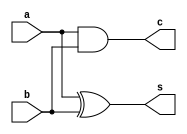

In [50]:
%%print_verilog -n half_adder.v

module half_adder(
    input a, b,
    output s, c);

    assign s = a ^ b;
    assign c = a & b;
endmodule

<h2>Somador completo (<i>full adder</i>)</h2>

Um somador completo pode ser combinado com outros para realizar a soma de v√°rios bits, conforme [explicado anteriormente](#scrollTo=Aritm_tica_Bin_ria). Para isso adicionamos uma porta de entrada ($c_{in}$) para receber um bit adicional da soma anterior:

a | b | $c_{in}$ || $c_{out}$ | s
--|--|:-:||:-:|---
0|0|0||0|0
0|0|1||0|1
0|1|0||0|1
0|1|1||1|0
1|0|0||0|1
1|0|1||1|0
1|1|0||1|0
1|1|1||1|1

Ele pode ser implementado a partir de dois meio somadores e uma porta OR adicional como a seguir. Aproveitamos a ocasi√£o para explicar outra forma de especificar hardware em Verilog. O m√≥dulo `half_adder` est√° descrito em uma forma que podemos chamar **funcional** (ou **dataflow**) , ou seja, cada sa√≠da √© uma fun√ß√£o direta das entradas. J√° o m√≥dulo `full_adder` est√° escrito na forma **estrutural**, que √© quando criamos um m√≥dulo de forma hier√°rquica, instanciando m√≥dulos menores ou primitivas b√°sicas (note o comando que inclui o m√≥dulo definido anteriormente `include "half_adder.v"`).

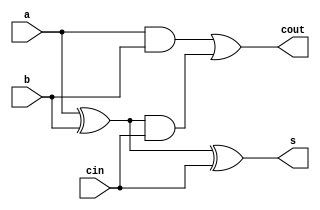

In [51]:
%%print_verilog -n full_adder.v
`include "half_adder.v"

module full_adder(
    input a, b, cin,
    output s, cout);

    wire c0, c1, s0; // podem ser omitidas j√° que possuem um √∫nico bit

    half_adder m0(a, b, s0, c0);
    half_adder m1(s0, cin, s, c1);
    or (cout, c0, c1);
endmodule

Na simula√ß√£o a seguir usamos os bits da pr√≥pria vari√°vel de itera√ß√£o `i` para fornecer os est√≠mulos em todas as combina√ß√µes poss√≠veis:

VCD info: dumpfile dump.vcd opened for output.
i                        ...3210||a|b|c||c|s
00000000000000000000000000000000||0|0|0||0|0
00000000000000000000000000000001||0|0|1||0|1
00000000000000000000000000000010||0|1|0||0|1
00000000000000000000000000000011||0|1|1||1|0
00000000000000000000000000000100||1|0|0||0|1
00000000000000000000000000000101||1|0|1||1|0
00000000000000000000000000000110||1|1|0||1|0
00000000000000000000000000000111||1|1|1||1|1
00000000000000000000000000001000||1|1|1||1|1



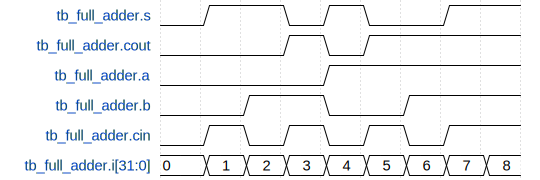

In [52]:
%%wavedrom
`include "full_adder.v"

module tb_full_adder;
  reg a, b, cin;
  wire s, cout;
  integer i;

  full_adder dut(a, b, cin, s, cout);

  initial
  begin
    $dumpvars(1);
    $display("i                        ...3210||a|b|c||c|s");
    $monitor("%3b||%b|%b|%b||%b|%b", i, a, b, cin, cout, s);
    for (i=0; i<8; i=i+1)
    begin
      cin = i[0];
        b = i[1];
        a = i[2];
      #5;
    end
    $finish;
  end
endmodule

<h2>Somador <i>ripple-carry</i></h2>

Um somador *ripple-carry* √© a forma mais simples de realizar uma soma de v√°rios bits. Ele √© construido a partir de v√°rios somadores complentos encadeados.

A seguir est√° o c√≥digo Verilog e o respectivo circuito para um somador de 4 bits. Note que o caminho de propaga√ß√£o do sinal que vai de `cin` at√© `cout` √© longo e vai aumentando a cada novo somador adicionado, esta √© a sua desvantagem. A vantagem √© a simplicidade, pois o circuito √© uniforme, bastando um somador completo identico para cada novo bit.

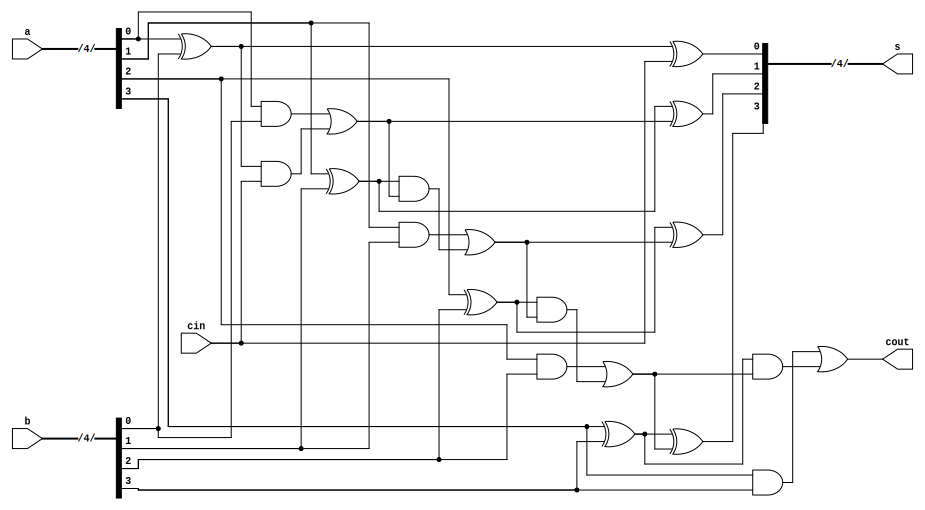

In [53]:
%%print_verilog -n adder4.v
`include "full_adder.v"

module adder4(
    input [3:0] a, b,
    input cin,
    output [3:0] s,
    output cout);

    wire [4:0] c;

    assign c[0] = cin;
    full_adder a0(a[0], b[0], c[0], s[0], c[1]);
    full_adder a1(a[1], b[1], c[1], s[1], c[2]);
    full_adder a2(a[2], b[2], c[2], s[2], c[3]);
    full_adder a3(a[3], b[3], c[3], s[3], c[4]);
    assign cout = c[4];
endmodule

No *test bench* a seguir usamos a mesma estrat√©gia de atribuir partes do contador da itera√ß√£o para as entadas, por√©m $2^9$ resultaria em 512 casos de teste, ent√£o estamos fazendo o incremento a cada 25 para reduzir o n√∫mero de casos. Declaramos a sa√≠da `s` com um bit a mais e concatenamos o vai-um (`cout`) neste √∫ltimo bit para termos o n√∫mero correto no resultado. No monitor informamos `%d` para obter os resultados em decimal, mas na simula√ß√£o eles aparecem em hexadecimal.  

VCD info: dumpfile dump.vcd opened for output.
 a +  b + cin = {cout,s}
 0 +  0 +   1 =       1
 0 + 13 +   0 =      13
 1 +  9 +   1 =      11
 2 +  6 +   0 =       8
 3 +  2 +   1 =       6
 3 + 15 +   0 =      18
 4 + 11 +   1 =      16
 5 +  8 +   0 =      13
 6 +  4 +   1 =      11
 7 +  1 +   0 =       8
 7 + 13 +   1 =      21
 8 + 10 +   0 =      18
 9 +  6 +   1 =      16
10 +  3 +   0 =      13
10 + 15 +   1 =      26
11 + 12 +   0 =      23
12 +  8 +   1 =      21
13 +  5 +   0 =      18
14 +  1 +   1 =      16
14 + 14 +   0 =      28
15 + 10 +   1 =      26



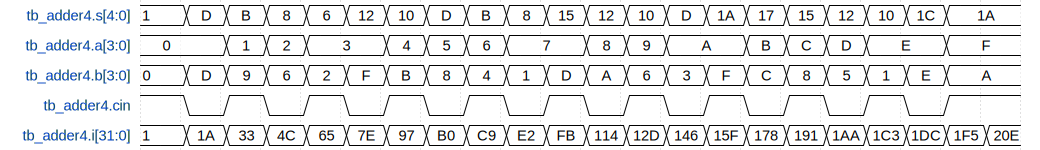

In [54]:
%%wavedrom
`include "adder4.v"

module tb_adder4;
  reg [3:0] a, b;
  reg cin;
  wire [4:0] s;
  integer i, j;

  adder4 dut(a, b, cin, s[3:0], s[4]);

  initial
  begin
    $dumpvars(1);
    $display(" a +  b + cin = {cout,s}");
    $monitor("%d + %d + %3b = %7d", a, b, cin, s);
    for (i=1; i<512; i=i+25)
    begin
      cin = i[0];
        b = i[4:1];
        a = i[8:5];
      #5;
    end
    $finish;
  end
endmodule

Para resolver o problema de atraso a cada bit adicionado √© poss√≠vel construir um circuito que antecipa o vai-um e d√° o resultado mais r√°pido (*carry lookahead*), mas ele cresce a cada novo bit adicionado. Esta solu√ß√£o n√£o ser√° abordada aqui, voc√™ pode pesquis√°-la por contra pr√≥pria e testar nas c√©lulas abaixo, trocando o c√≥digo da implementa√ß√£o.

<h3>M√≥dulos parametrizados</h3>

Vamos aproveitar a ocasi√£o para introduzir o conceito de par√¢metros em Verilog. Podemos definir um m√≥dulo, cujas propriedades s√£o pametriz√°veis, por exemplo, a largura de suas portas. Assim, quando ele for instanciado, podemos us√°-lo com o valor padr√£o dos par√¢metros ou modificar em cada inst√¢ncia para obter um m√≥dulo personalizado.

No trecho de c√≥digo a seguir as portas `a`, `b` e `s` do somandor ter√£o sua largura definida de acordo com o par√¢metro `width` declarado logo abaixo:

```verilog
module N_bits_adder(
    input [width-1:0] a, b,
    input cin,
    output [width-1:0] s,
    output cout);

    parameter width = 8; //largura padr√£o
    ...
```

Depois declaramos um fio `c` com um bit a mais e a vari√°vel de gera√ß√£o `i`.

```verilog
    wire [width:0] c;
    genvar i;
```

Dentro de um bloco `generate`/`endgenerate` usamos o comando `for` para instanciar cada um dos somadores, usando o fio `c` para propagar os vai-uns.

```verilog
    generate
        for (i=0; i<width; i=i+1)
            full_adder bit(a[i], b[i], c[i], s[i], c[i+1]);
    endgenerate
```

Cada bit do fio `c` foi ligado nas duas pontas, exceto o primeiro e o √∫ltimo, ent√£o tratamos isso fora do bloco.

```verilog

    assign c[0] = cin;
    assign cout = c[width];
```

O c√≥digo completo est√° a seguir:

In [55]:
%%verilog -n N_bits_adder.v
`include "full_adder.v"

module N_bits_adder(
    input [width-1:0] a, b,
    input cin,
    output [width-1:0] s,
    output cout);

    parameter width = 8; //largura padr√£o

    wire [width:0] c;
    genvar i;

    generate
        for (i=0; i<width; i=i+1)
            full_adder bit(a[i], b[i], c[i], s[i], c[i+1]);
    endgenerate

    assign c[0] = cin;
    assign cout = c[width];
endmodule


Assim conseguimos construir um somador de largura vari√°vel, bastando mudar o valor de `width` quando ele for instanciado. Isso pode ser feito de duas formas.

* Na forma mais compacta, usamos um bloco `#()` e colocamos os par√¢metros dentro, separando por v√≠rgula se houver mais de um:

```verilog
    N_bits_adder #(4) dut4 (a[3:0], b[3:0], cin, s[3:0], c);
```

* Na forma mais expl√≠cita, usamos o comando `defparam` para indicar cada valor individualmente:

```verilog
    defparam dut2.width = 2;
    N_bits_adder dut2 (a[5:4], b[5:4], c, s[5:4], cout);
```



Para demonstrar o conceito, vamos construir um somador de 6 bits a partir destas 2 instancias do somador parametriz√°vel `N_bits_adder`.

* A primeira vai somar os 4 bits menos significativos:
* A segunda vai somar os 2 bits mais significativos:

Elas est√£o encadeadas pelo sinal de vai-um (`c`).

In [56]:
%%verilog -n adder6bits.v
`include "N_bits_adder.v"

module adder6bits(
    input [5:0] a, b,
    input cin,
    output [5:0] s,
    output cout);

    wire c;

    N_bits_adder #(4) dut4 (a[3:0], b[3:0], cin, s[3:0], c);

    defparam dut2.width = 2;
    N_bits_adder dut2 (a[5:4], b[5:4], c, s[5:4], cout);
endmodule

A estrutura deste m√≥dulo n√£o faz muito sentido, uma vez que poderiamos ter instanciado o nosso somador gen√©rico com 6 bits uma √∫nica vez, mas j√° que o fizemos, vamos testar para provar que ele funciona:

In [57]:
%%verilog
`include "adder6bits.v"

module tb_adder6bits;
  reg [5:0] a, b;
  reg cin;
  wire [6:0] s;
  integer i, j;

  adder6bits dut(a, b, cin, s[5:0], s[6]);

  initial
  begin
    $dumpvars(1);
    $display(" a +  b + cin = {cout,s}");
    $monitor("%d + %d + %3b = %7d", a, b, cin, s);
    for (i=0; i<1<<13; i=i+1333)
    begin
      cin = i[0];
        b = i[6:1];
        a = i[12:7];
      #5;
    end
    $finish;
  end
endmodule

VCD info: dumpfile dump.vcd opened for output.
 a +  b + cin = {cout,s}
 0 +  0 +   0 =       0
10 + 26 +   1 =      37
20 + 53 +   0 =      73
31 + 15 +   1 =      47
41 + 42 +   0 =      83
52 +  4 +   1 =      57
62 + 31 +   0 =      93



A pr√≥pria linguagem Verilog possui operadores aritm√©ticos, ent√£o √© poss√≠vel construir um somador apenas usando este operador. Note que √© poss√≠vel usar o operador de concatena√ß√£o `{}` do lado esquerdo da express√£o de atribui√ß√£o para pegar o bit excedente no `cout`.

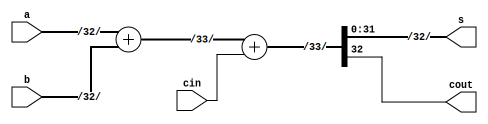

In [58]:
%%print_verilog

module adder(
    input [N-1:0] a, b,
    input cin,
    output [N-1:0] s,
    output cout);
    parameter N = 32;
    assign {cout, s} = a + b + cin;
endmodule

# Circuitos combinacionais t√≠picos

Agora que j√° sabemos as formas de representa√ß√£o e manipula√ß√£o de circuitos digitais, vamos conhecer alguns **circuitos combinacionais** t√≠picos e suas respectivas constru√ß√µes em Verilog. Estes s√£o chamados combinacionais porque suas sa√≠das dependem exclusivamente das combina√ß√µes de entradas, ou seja, sempre que uma determinada entrada √© apresentada a sa√≠da correspondente a ela √© a mesma. Posteriormente, veremos que **circuitos sequenciais** podem apresentar sa√≠das diferentes com a mesma entrada, pois dependem tamb√©m de um estado interno provido por elementos de mem√≥ria.



## Multiplexador

Depois das portas l√≥gicas b√°sica, talvez seja o multiplexador (mux) o circuito mais conhecido e mais √∫til. Resumidamente ele √© capaz de escolher entre duas (ou mais) entradas a partir de uma linha de sele√ß√£o. Na tabela a seguir demonstramos o funcionamento de um mux de duas entradas de dados e uma de sele√ß√£o. Note que a sa√≠da $f$ correponde √† entrada $x_0$ quando $Sel=0$ e que quando $Sel=1$ a entrada $x_1$ √© direcionada para a sa√≠da.

$Sel$|$x_0$|$x_1$|$f$
:-:|:-:|:-:|:-:
 0 | **0** | 0 | **0** |
 0 | **0** | 1 | **0** |
 0 | **1** | 0 | **1** |
 0 | **1** | 1 | **1** |
 1 | 0 | **0** | **0** |
 1 | 0 | **1** | **1** |
 1 | 1 | **0** | **0** |
 1 | 1 | **1** | **1** |

 Uma tabela resumida pode ser a seguinte:

 $Sel$|$f$
 :-:|:-:
 0|$x_0$
 1|$x_1$

A implementa√ß√£o mais direta deste circuito pode ser obtida a partir da express√£o $f =  x_1 Sel + x_0\overline{Sel}$ demonstrada a seguir em Verilog.

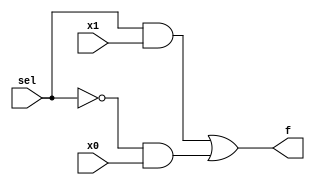

In [59]:
%%print_verilog -n mux2.v

module mux2(
  input sel, x0, x1,
  output f);
  assign f = sel & x1 | ~sel & x0;
endmodule

Em sua simula√ß√£o a seguir, podemos ver que a sa√≠da `f` copia a entrada `x0` inicialmente, enquanto `sel` est√° embaixo. J√° na segunda metade da simula√ß√£o, enquanto `sel` √© acionado, a sa√≠da `f` fica igual a entrada `x1`.

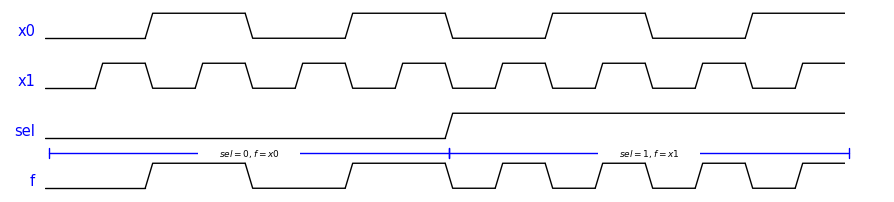

In [60]:
#@title
from schemdraw import logic
logic.TimingDiagram(
    {'signal': [
        {'name': 'x0', 'wave': '0.1.0.1.0.1.0.1.'},
        {'name': 'x1', 'wave': '0101010101010101'},
        {'name': 'sel','wave': '0.......1.......'},
        {'name': 'f',  'wave': '0.1.0.1.01010101'},
    ],
     'edge': ['[3^:0]+[3^:8] $sel=0, f=x0$',
              '[3^:8]+[3^:16] $sel=1, f=x1$',
             ]
    }, ygap=.5, grid=False)

Outra forma usada para gerar multiplexadores √© usando o operador tern√°rio da linguagem,  que possou tr√™s partes:
`condi√ß√£o ? verdadeiro : falso`. Ele pode ser lido na forma: se condi√ß√£o, ent√£o verdadeiro, sen√£o falso. Notem que neste caso a ferramenta gr√°fica substitui sua representa√ß√£o por um trap√©zio, que √© a forma mais comum de representar um multiplexador. Nesta forma simplificada de representar um mux as entradas s√£o colocadas do lado maior, a sa√≠da do lado menor e o controle na lateral.

Podemos combinar multiplexadores menores para obter outro com um n√∫mero maior de entradas. Eles devem ser organizados em camadas e devemos estar atentos √†s combina√ß√µes da sele√ß√£o do controle, principalmente se o n√∫mero de entradas de dados n√£o for uma pot√™ncia de dois.

A anima√ß√£o abaixo ilustra o funcionamento com a sele√ß√£o variando da entrada 0 at√© a entrada 3. O bit $sel_0$ seleciona o primeiro n√≠vel entre os pares $x_0,x_1$ e $x_2,x_3$. O  bit $sel_1$ ir√° selecionar o mux de cima (0 ou 1) ou o mux de baixo (2 ou 3). Voc√™ pode testar visualmente este e outros exemplos [seguindo este link](https://github.dev/menotti/ld/digitaljs/).

![](https://github.com/menotti/ld/blob/main/figs/mux4.gif?raw=true)

A seguir o c√≥digo Verilog usando operadores tern√°rios aninhados:

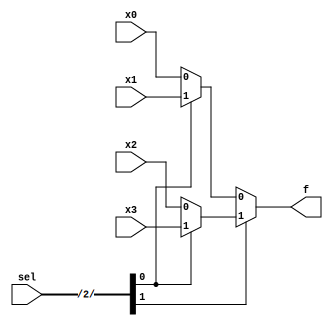

In [61]:
%%print_verilog

module mux4(
  input [1:0] sel,
  input x0, x1, x2, x3,
  output f);
  assign f = sel[1] ? (sel[0] ? x3 : x2) : (sel[0] ? x1 : x0);
endmodule

Da mesma forma, sua representa√ß√£o pode ser simplificada em uma √∫nica forma trapezoidal com todas as entradas juntas.

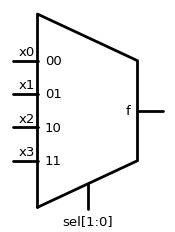

In [62]:
#@title
import schemdraw
from schemdraw import elements as elm

elm.Multiplexer(
    pins=[elm.IcPin(name='11', side='L', pin='x3'),
          elm.IcPin(name='10', side='L', pin='x2'),
          elm.IcPin(name='01', side='L', pin='x1'),
          elm.IcPin(name='00', side='L', pin='x0'),
          elm.IcPin(name='f', side='R'),
          elm.IcPin(side='B')],edgepadH=-.5).label('sel[1:0]', 'bottom', fontsize=11)

<h3>Exerc√≠cio</h3>

No bloco de c√≥digo abaixo, implementamos um mux de tr√™s entradas (a, b e c) de acordo com a seguinte tabela:

s0|s1|f
:-:|:-:|:-:
0|0|a
0|1|b
1|x|c

Ele foi implementado na forma funcional (`mux3f`) com operadores tern√°rios aninhados (linha 11). Observe sua simula√ß√£o na sequ√™ncia do c√≥digo, ela est√° na mesma ordem da tabela acima. Implemente uma vers√£o estrutural (`mux3e`), a partir de dois `mux2` fornecidos. Para isso, preencha as portas correspondentes nas instancias das linhas 5 e 6. Depois execute a c√©lula e veja se ele se comporta da mesma maneira, ou seja `tb_mux3.fe` = `tb_mux3.ff` .

VCD info: dumpfile dump.vcd opened for output.



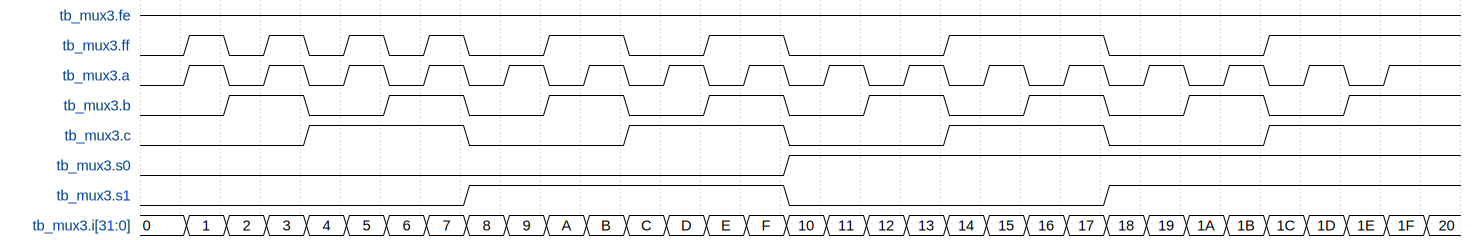

In [63]:
%%wavedrom
`include "mux2.v"

module mux3e(input a, b, c, s0, s1, output f);
  // implemente sua vers√£o estrutural:
  mux2 interno(, , , );
  mux2 externo(, , , );
endmodule

module mux3f(input a, b, c, s0, s1, output f);
  // implementa√ß√£o funcional de refer√™ncia:
  assign f = s0 ? c : (s1 ? b : a);
endmodule

module tb_mux3;
  reg a, b, c, s0, s1;
  wire ff, fe;
  integer i;

  mux3f dutf(a, b, c, s0, s1, ff);
  mux3e dute(a, b, c, s0, s1, fe);

  initial
  begin
    $dumpvars(1);
    for (i=0; i<32; i=i+1)
    begin
       a = i[0];
       b = i[1];
       c = i[2];
      s1 = i[3];
      s0 = i[4];
      #5;
    end
  end
endmodule

## Conversores de c√≥digo

Tamb√©m est√£o entre os circuitos combinacionais mais conhecidos os codificadores e decodificadores, chamados genericamente de conversores de c√≥digo.

### Decodificador

Vamos come√ßar com um decodificador simples, que recebe uma entrada codificada em 2 bits e a decodifica, ativando uma √∫nica sa√≠da ($y$), dependendo do c√≥digo na entrada ($w$), conforme a tabela a seguir:

|$w_1$|$w_0$||$y_3$|$y_2$|$y_1$|$y_0$|
|-----|-----||-----|-----|-----|-----|
| 0 | 0 || 0 | 0 | 0 | 1 |
| 0 | 1 || 0 | 0 | 1 | 0 |
| 1 | 0 || 0 | 1 | 0 | 0 |
| 1 | 1 || 1 | 0 | 0 | 0 |

Em sua implementa√ß√£o mais direta, podemos extrair a express√£o correspondente a cada sa√≠da $y$ a partir das entradas $w$:


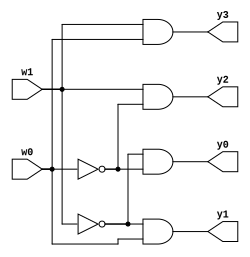

In [64]:
%%print_verilog -n dec2to4.v

module dec2to4(
  input w1, w0,
  output y3, y2, y1, y0);
  assign y0 = ~w1 & ~w0;
  assign y1 = ~w1 &  w0;
  assign y2 =  w1 & ~w0;
  assign y3 =  w1 &  w0;
endmodule

VCD info: dumpfile dump.vcd opened for output.



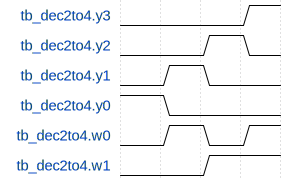

In [65]:
#@title
%%wavedrom
`include "dec2to4.v"

module tb_dec2to4;
  reg w1, w0;
  wire y3, y2, y1, y0;

  dec2to4 uut(w1, w0, y3, y2, y1, y0);

  initial begin
    $dumpvars(1);
       w1 = 0; w0 = 0;
    #5 w1 = 0; w0 = 1;
    #5 w1 = 1; w0 = 0;
    #5 w1 = 1; w0 = 1;
    #5 ;
  end
endmodule

Note que neste decodificador h√° sempre uma sa√≠da habilitada, pois todas as combina√ß√µes de entrada s√£o usadas. Podemos usar um sinal de habilita *(**En**able)* para que a sa√≠da s√≥ seja ativada enquanto ele estiver permitindo. Para isso, vamos usar um comando `case` que por sua vez s√≥ pode ser usado dentro de um bloco `always`. A lista que segue o in√≠cio do bloco `@(W, En)` √© chamada lista sensitiva e, como inclui todas as entradas, ainda gera um circuito combinacional. Usamos o operador de concatena√ß√£o `{En,W}` para comparar as entradas juntas e incluimos a op√ß√£o `default` que vai abrager todas as entradas em que o sinal habilita √© falso. Note ainda que n√£o precisamos usar um bloco `begin/end` no comando `always` j√° que ele s√≥ possui um √∫nico comando `case` que forma um bloco at√© o `endcase`.

A especifica√ß√£o comportamental √© muito √∫til, mas devemos tomar cuidado com espeficica√ß√µes incompletas que podem resultar em hardware completamente diferente do esperado. Por exemplo, experimente remover a op√ß√£o `default` do `case` (linha 14) e observe o circuito gerado. A ferramente precisa introduzir elementos de mem√≥ria (que veremos a seguir) para manter a sa√≠da anterior quando a entrada n√£o √© contemplada no `case`.

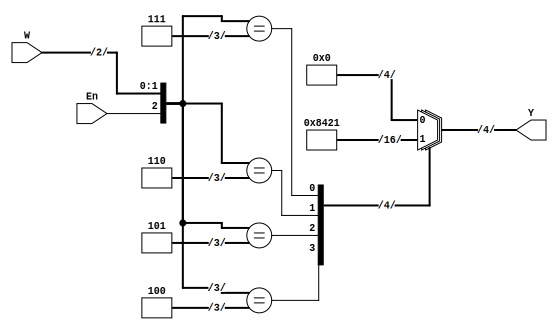

In [66]:
%%print_verilog -n dec2to4en.v

module dec2to4en (W, En, Y);
	input [1:0] W;
	input En;
	output reg [0:3] Y;

	always @(W, En)
		case ({En,W})
			3'b100: Y = 4'b1000;
			3'b101: Y = 4'b0100;
			3'b110: Y = 4'b0010;
			3'b111: Y = 4'b0001;
			default: Y = 4'b0000;
		endcase
endmodule

Para termos uma id√©ia melhor do circuito resultante, especificamos ele na forma funcional:

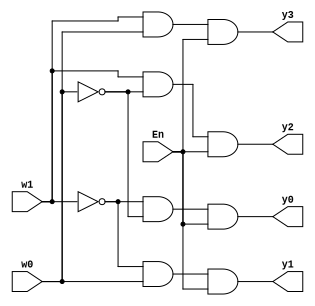

In [67]:
%%print_verilog

module dec2to4enW (
	input w1, w0, En,
	output y3, y2, y1, y0);

  assign y0 = ~w1 & ~w0 & En;
  assign y1 = ~w1 &  w0 & En;
  assign y2 =  w1 & ~w0 & En;
  assign y3 =  w1 &  w0 & En;
endmodule



 O circuito resultante parece bem mais complexo do que o anterior, mas as ferramentas de s√≠ntese s√£o capazes de simplific√°-lo internamente, tornando-o muito parecido com o anterior. A tabela a seguir demonstra o seu funcionamento:

 En| w0| w1|| y3| y2| y1| y0
:-:|:-:|:-:||:-:|:-:|:-:|:-:
 0 | x | x || 0 | 0 | 0 | 0
 1 | 0 | 0 || 0 | 0 | 0 | 1
 1 | 0 | 1 || 0 | 0 | 1 | 0
 1 | 1 | 0 || 0 | 1 | 0 | 0
 1 | 1 | 1 || 1 | 0 | 0 | 0

Vejamos sua simula√ß√£o usando usando usando barramentos:

VCD info: dumpfile dump.vcd opened for output.



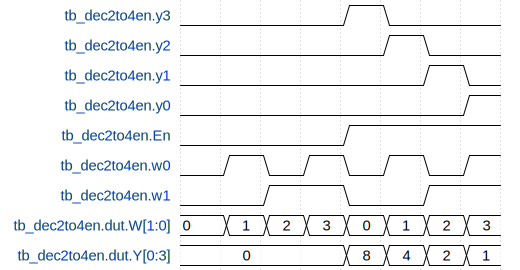

In [146]:
%%wavedrom
`include "dec2to4en.v"

module tb_dec2to4en;
	reg w1, w0, En;
	wire y3, y2, y1, y0;

  dec2to4en dut({w1,w0}, En, {y3, y2, y1, y0});

  initial begin
    $dumpvars(0);
       En = 0;
       w1 = 0; w0 = 0;
    #5 w1 = 0; w0 = 1;
    #5 w1 = 1; w0 = 0;
    #5 w1 = 1; w0 = 1;
    #5 En = 1;
       w1 = 0; w0 = 0;
    #5 w1 = 0; w0 = 1;
    #5 w1 = 1; w0 = 0;
    #5 w1 = 1; w0 = 1;
    #5;
  end
endmodule

 <h3>Codificador</h3>

 Um codificador faz exatamente o contr√°rio de um decodificador ü§ì, mas deixamos ele para depois porque h√° uma dificuldade adicional em seu projeto. Uma prioridade entre as entradas deve ser estabelecida, uma vez que cada uma delas aciona um c√≥digo na sa√≠da.

 Na implementa√ß√£o a seguir estabelecemos os bits mais significativos como priorit√°rios. Para isso, usamos o comando `casex`, capaz de fazer compara√ß√µes com *don't cares*. Quando o bit mais significativo √© `1`, n√£o importa o valor dos demais e o c√≥digo retornado √© o mais alto. No caso seguinte ele √© `0`, o bit seguinte √© `1` e os demais n√£o importam, assim fazemos sucessivamente at√© o √∫ltimo. Note que aqui tamb√©m √© necess√°rio incluir um `default` para o caso de nenhum bit de entrada ser apresentado. Usamos uma sa√≠da `valid_data` para indicar que ao menos uma entrada foi apresentada, j√° que o caso `default` deixa a ferramenta escolher livremente a sa√≠da `code` no caso contr√°rio.

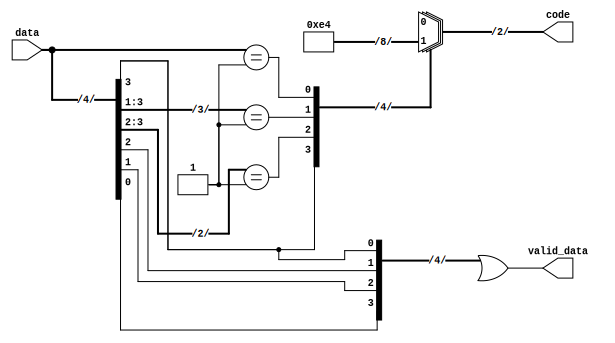

In [69]:
%%print_verilog -n priority_encoder.v

module priority_encoder (
  input [3:0] data,
  output reg [1:0] code,
  output valid_data);

  always @(data)
    casex (data)
      4'b1xxx : code=3;
      4'b01xx : code=2;
      4'b001x : code=1;
      4'b0001 : code=0;
      default : code=2'bx;
    endcase
  assign valid_data = |data; // Operador de redu√ß√£o
endmodule

No teste abaixo instanciamos nosso codificador e o testamos com todas as entradas poss√≠veis para ter certeza de que a prioridade funciona. Apesar da especifica√ß√£o comportamental ser mais f√°cil de escrever e compreender, ela pode gerar circuitos inesperados caso n√£o se especifique corretamente o hardware desejado. Al√©m disso, a express√£o para implementa√ß√£o funcional n√£o √© dif√≠cil de ser obtida, veja na linha 11 do nosso teste. Note que a √∫nica diferen√ßa nas sa√≠das √© o X para a entrada 0.

VCD info: dumpfile dump.vcd opened for output.



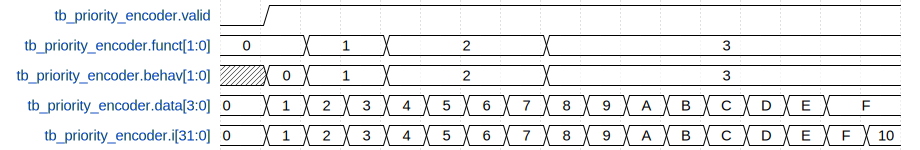

In [70]:
%%wavedrom
`include "priority_encoder.v"

module tb_priority_encoder;
  reg [3:0] data;
  wire [1:0] behav, funct;
  wire valid;
  integer i;

  priority_encoder dut(data, behav, valid);
  assign funct = {data[3] | data[2], ~data[3] & ~data[2] & data[1] | data[3]};

  initial
  begin
    $dumpvars(1);
    for (i=0; i<16; i=i+1)
    begin
      data = i; #5;
    end
  end
endmodule

Abaixo um exemplo com uma implementa√ß√£o funcional de um codificador de 8 bits para 3:

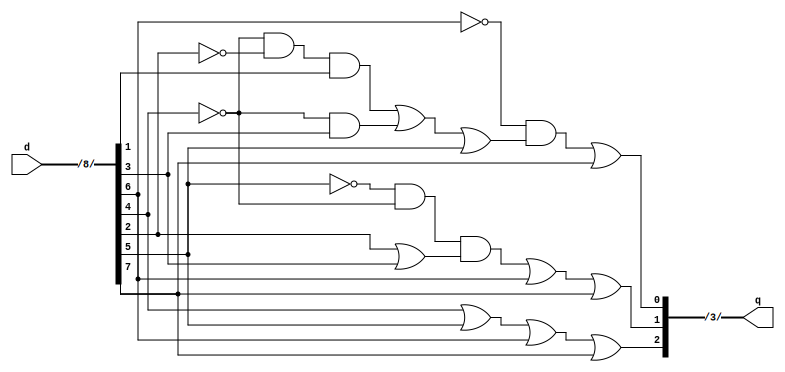

In [71]:
%%print_verilog
module encoder (
		input  [7:0] d, // definir as entradas
    output [2:0] q);  // definir as saidas

    assign q[0] = (~d[6] & (~d[4] & ~d[2] & d[1] | ~d[4] & d[3] | d[5])| d[7]);
    assign q[1] = (~d[5] & ~d[4] & (d[2] | d[3]) | d[6] |d[7]);
    assign q[2] = (d[4] | d[5] | d[6] | d[7]);
endmodule

Abaixo a simula√ß√£o do circuito acima:

In [72]:
#@title

head = """
module encoder(
		input  [7:0]d, // definir as entradas
    output [2:0] q  // definir as saidas
    );
assign q[0]=(~d[6] & (~d[4] & ~d[2] & d[1] | ~d[4] & d[3] | d[5])| d[7]);
assign q[1]=(~d[5] & ~d[4] & (d[2] | d[3]) | d[6] |d[7]);
assign q[2]=(d[4] | d[5] | d[6] | d[7]);
endmodule




module logic_testbench();  // Esta parte do codigo √© para gerar os 16 valores
reg [7:0] A;
wire [2:0] z;
integer k;
	encoder p(A,z);
	initial begin
		$display("A 76543210 | z ");
		$monitor("  %8b | %d", A,  z);
"""


tail ="""
    #1;
		$finish;
	end

endmodule
"""
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact
import subprocess

def geraverilog(A7,A6,A5,A4,A3,A2,A1,A0):
    # Fun√ß√£o que recebe os valores dos sliders e faz algo com eles
    clear_output()  # Limpa a sa√≠da anterior
    # Adicione aqui a l√≥gica para gerar o Verilog
    f = open("test_comp.v","w")
    f.write(head)
    to_string = lambda value: "1" if value else "0"
    s = "A[7] = "+to_string(A7)+"; "
    s += "A[6] = "+to_string(A6)+"; "
    s += "A[5] = "+to_string(A5)+"; "
    s += "A[4] = "+to_string(A4)+";"
    s += "A[3] = "+to_string(A3)+"; "
    s += "A[2] = "+to_string(A2)+"; "
    s += "A[1] = "+to_string(A1)+"; "
    s += "A[0] = "+to_string(A0)+";\n"
    f.write(s)
    f.write(tail)
    f.close()
    command = f"iverilog test_comp.v"
    output = subprocess.check_output(command, shell=True)
    command = f"./a.out"
    output = subprocess.check_output(command, shell=True)
    output_lines = output.decode('utf-8').split('\n')
    for line in output_lines:
      print(line)

# Cria√ß√£o dos sliders
a7 = widgets.Checkbox(description='A7:', value=False)
a6 = widgets.Checkbox(description='A6:', value=False)
a5 = widgets.Checkbox(description='A5:', value=False)
a4 = widgets.Checkbox(description='A4:', value=False)
a3 = widgets.Checkbox(description='A3:', value=False)
a2 = widgets.Checkbox(description='A2:', value=False)
a1 = widgets.Checkbox(description='A1:', value=False)
a0 = widgets.Checkbox(description='A0:', value=False)

# Vincula a fun√ß√£o geraverilog ao interact
dummy = interact(geraverilog, A7=a7,A6=a6,A5=a5,A4=a4,A3=a3,A2=a2,A1=a1,A0=a0)



interactive(children=(Checkbox(value=False, description='A7:'), Checkbox(value=False, description='A6:'), Chec‚Ä¶

Codificadores e decodificadores s√£o os conversores de c√≥digo mais comuns, mas existem muitos outros poss√≠veis de serem construidos de acordo com as necessidades de cada sistema digital. Voc√™ certamente j√° viu um equipamento (antigo?) com um display de sete segmentos como o da figura a seguir (execute a c√©lula abaixo e deslize o comando para ver os digitos todos):

In [73]:
#@title
import schemdraw
import ipywidgets as widgets
from ipywidgets import interact
from schemdraw import elements as elm

def geradig(A):
  h=hex(A)[2]
  print('Hexadecimal:', h)
  display(elm.SevenSegment(segcolor='green', tilt=0, digit=h))

slider_A = widgets.IntSlider(min=0, max=15, description='Decimal:')
dummy = interact(geradig, A=slider_A)

interactive(children=(IntSlider(value=0, description='Decimal:', max=15), Output()), _dom_classes=('widget-int‚Ä¶

Cada d√≠gito deste componente possui um segmento de LED independente que pode estar ou n√£o aceso de acordo com um c√≥digo de entrada. Mais uma vez vamos usar o comando `case`, pois facilita a constru√ß√£o do circuito, uma vez que ter√≠amos que calcular as express√µes para cada um dos sete segmentos separadamente. A implementa√ß√£o a seguir s√≥ funciona para os d√≠gitos de 0 a 9, mas voc√™ pode complet√°-la para funcionar com hexadecimal (adicionando A, b, C, d, E, F). Depois, √© s√≥ executar as c√©lulas abaixo para gravar o arquivo e simular novamente.

In [74]:
%%verilog -n disp7seg.v
module disp7seg (
  input [3:0] dig,
  output reg [6:0] segs);

  always@(dig)
    case (dig)   // abcdefg
      0 : segs = 7'b1111110;
      1 : segs = 7'b0110000;
      2 : segs = 7'b1101101;
      3 : segs = 7'b1111001;
      4 : segs = 7'b0110011;
      5 : segs = 7'b1011011;
      6 : segs = 7'b1011111;
      7 : segs = 7'b1110000;
      8 : segs = 7'b1111111;
      9 : segs = 7'b1111011;
      // complete para os d√≠gito de A..F
      default : segs = 7'b0000000;
    endcase
endmodule

VCD info: dumpfile dump.vcd opened for output.



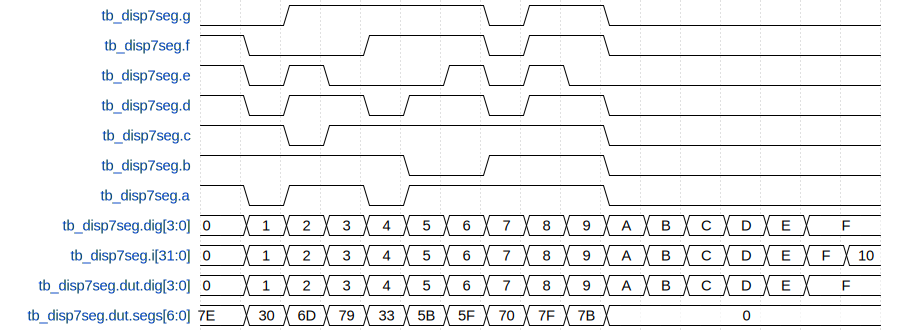

In [75]:
%%wavedrom
`include "disp7seg.v"

module tb_disp7seg;
  reg [3:0] dig;
  wire a,b,c,d,e,f,g;
  integer i;

  disp7seg dut(dig, {a,b,c,d,e,f,g});

  initial
  begin
    $dumpvars(0);
    for (i=0; i<16; i=i+1)
    begin
      dig = i; #5;
    end
  end
endmodule

O c√≥digo abaixo executa o decodificador em Verilog e mostra uma anima√ß√£o com caracteres ASCII em Verilog que emula a sa√≠da do display de 7 segmentos. Ela s√≥ foi emplementada at√© o d√≠gito 9, algumas c√©lulas atr√°s, mas voc√™ pode completar a implementa√ß√£o e executar novamente para ver se funciona.

In [76]:
#@title
head = """`include "disp7seg.v"

module logic_testbench();
reg [3:0] A;
wire [6:0] D;
integer k;
	disp7seg M(A,D);
	initial begin
		$display("A3A2A1A0 | abcdefg");
		$monitor("%b %b %b %b  | %7b", A[3],A[2],A[1],A[0], D);
"""


tail ="""
    #1;
    if (D[6]== 1'b1) $display(" _ ");
    if (D[1]== 1'b1 && D[5]== 1'b1 && D[0]== 1'b1) $display("|_|");
    else if (D[1]== 1'b1 && D[5]== 1'b1) $display("| |");
    else if (D[1]== 1'b1 && D[0]== 1'b1) $display("|_");
    else if (D[5]== 1'b1 && D[0]== 1'b1) $display(" _|");
    else if (D[5]== 1'b1 ) $display("  |");
    else if (D[1]== 1'b1 ) $display("|");
    else if (D[0]== 1'b1 ) $display(" _ ");
    if (D[2]== 1'b1 && D[4]== 1'b1 && D[3]== 1'b1) $display("|_|");
    else if (D[2]== 1'b1 && D[4]== 1'b1) $display("| |");
    else if (D[2]== 1'b1 && D[3]== 1'b1) $display("|_");
    else if (D[4]== 1'b1 && D[3]== 1'b1) $display(" _|");
    else if (D[4]== 1'b1 ) $display("  |");
    else if (D[2]== 1'b1 ) $display("|");
    else if (D[3]== 1'b1 ) $display(" _ ");

		$finish;
	end

endmodule
"""
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact
import subprocess

def geraverilog(A):
    # Fun√ß√£o que recebe os valores dos sliders e faz algo com eles
    clear_output()  # Limpa a sa√≠da anterior
    # Adicione aqui a l√≥gica para gerar o Verilog
    h=hex(A)[2]
    print('Hexadecimal:', h)
    f = open("test_comp.v","w")
    f.write(head)
    s = "A = "+str(A)+"; \n"
    f.write(s)
    f.write(tail)
    f.close()
    command = f"iverilog test_comp.v"
    output = subprocess.check_output(command, shell=True)
    command = f"./a.out"
    output = subprocess.check_output(command, shell=True)
    output_lines = output.decode('utf-8').split('\n')
    for line in output_lines:
      print(line)
    e = elm.SevenSegment(segcolor='green', digit=h, tilt=0)
    display(e)

# Cria√ß√£o dos sliders
slider_A = widgets.IntSlider(min=0, max=15, description='A')

# Vincula a fun√ß√£o geraverilog ao interact
dummy = interact(geraverilog, A=slider_A)




interactive(children=(IntSlider(value=0, description='A', max=15), Output()), _dom_classes=('widget-interact',‚Ä¶



## Comparadores

Iremos fazer a especifica√ß√£o do m√≥dulo b√°sico com tabela verdade, minimizar com mapas de Karnaugh e Don't Care.

* Comparador de n bits Esquerda para Direita
* Comparador de n bits Direita para Esquerda
* Comparador de n bits em √Ärvore



## [De]multiplexadores

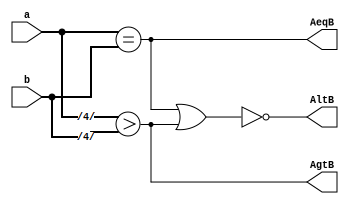

In [77]:
%%print_verilog

module comparador(
    input [3:0] a, b,
    output AeqB, AltB, AgtB);

    assign AeqB = a == b;
    assign AgtB = a > b;
    assign AltB = AeqB ~| AgtB; // a < b;
endmodule

## Unidade L√≥gica e Aritm√©tica

Para termos uma no√ß√£o de como a linguagem Verilog pode ser produtiva na especifica√ß√£o de hardware, vamos projetar uma Unidade L√≥gica e Aritm√©tica (ULA) compat√≠vel com o circuito 74F381, bastante conhecido. Ela tem entradas e sa√≠da de 4 bits e 3 opera√ß√µes, de acordo com a tabela a seguir:

Opera√ß√£o|Op[2:0]|Sa√≠da
:-----|:---:|:---:
Clear | 000|0000
B-A   | 001|B - A
A-B   | 010|A - B
ADD   | 011|A + B
XOR   | 100|A ^ B
OR    | 101|A \| B
AND   | 110|A & B
Preset| 111|1111

In [78]:
%%verilog -n alu.v
// 74F381 ALU
module alu (
  input [2:0] op,
  input [3:0] A, B,
  output reg [3:0] S);

  always @(op or A or B)
    case (op)
      0: S = 4'b0000;
      1: S = B - A;
      2: S = A - B;
      3: S = A + B;
      4: S = A ^ B;
      5: S = A | B;
      6: S = A & B;
      7: S = 4'b1111;
  endcase
endmodule

Vamos usar novamente um arquivo de vetor de testes, mas agora em hexadecimal. Nele temos um √∫nico caso de teste para cada opera√ß√£o da nossa ULA e a ordem das vari√°veis no arquivo √© a seguinte: `A_op_B_S`:

In [79]:
%%writefile values.tv
x_0_x_0
2_1_7_5
5_2_2_3
2_3_3_5
f_4_a_5
4_5_1_5
a_6_7_2
x_7_x_f

Overwriting values.tv


Vejamos algumas particularidades deste novo estilo de ***test bench***:
  1. Nosso arranjo de vetores foi declarado com mais linhas do que o arquivo (linha 9);
  1. Apesar de se tratar de um circuito combinacional, temos um rel√≥gio (`clk`) para sequenciar os testes, que gera uma onda quadrada (linha 22);
  1. A cada subida deste `clk` alimentamos as entradas do circuito e a sa√≠da esperada;
  1. Na descida do `clk` verificamos se a sa√≠da obtida confere com a esperada (linha 35);
  1. Incrementamos a vari√°vel de itera√ß√£o `i` dos testes, verificamos se chegamos ao fim, ou seja, se lemos um valor indefinido (`x`) e finalizamos o teste (linhas 37-39).

Observe sua simula√ß√£o realizando todas as opera√ß√µes. Voc√™ √© capaz de interpretar os valores informados e obtidos?

VCD info: dumpfile dump.vcd opened for output.
x_xxx_x_x
x_000_x_0
2_001_7_5
5_010_2_3
2_011_3_5
f_100_a_5
4_101_1_5
a_110_7_2
x_111_x_f



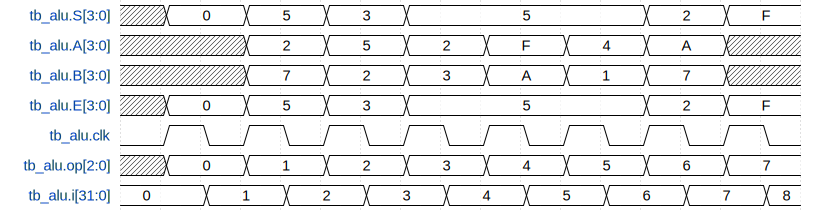

In [80]:
#@title
%%wavedrom
`include "alu.v"

module tb_alu;
  reg [2:0] op;
  reg [3:0] A, B, E;
  wire [3:0] S;
  reg [15:0] values [0:69];
  reg clk;
  integer i;

  alu dut(op, A, B, S);

  initial
  begin
    $monitor("%h_%3b_%h_%h", A, op, B, S);
    $dumpvars(1);
    $readmemh("values.tv", values);
    i = 0;
    clk = 1'b0;
    forever #5 clk = ~clk;
  end

  always@(posedge clk)
  begin
     A = values[i][15:12];
    op = values[i][10: 8];
     B = values[i][ 7: 4];
     E = values[i][ 3: 0];
  end

  always@(negedge clk)
  begin
    if (E !== S)
      $display("Erro no vetor %0d, opera√ß√£o %3b, esperado %b, obtido %b!", i, op, S, E);
    i = i + 1;
    if (values[i][0]===1'bx)
      $finish;
  end
endmodule

Experimente colocar novos casos de teste no arquivo, salve-o e execute novamente a simula√ß√£o para ver se compreendeu.

# Elementos de mem√≥ria

At√© agora, todos os circuitos que abordamos podem ser chamados de combinacionais. Isso porque suas sa√≠das s√≥ dependem da combina√ß√£o das entradas. Para dizer de outra forma, sempre que apresentamos a eles uma mesma entrada, ele ir√° resultar nas mesmas sa√≠das.

A partir de agora vamos introduzir elementos de mem√≥ria capazes de armazenar um estado interno no circuito. Isso faz com que ele n√£o dependa apenas das entradas, mas tamb√©m da ordem em que foram modificadas ao longo do tempo. Isso √© fundamental para os circuitos digitais, j√° que h√° c√°lculos complexos que precisam ser divididos em partes para serem realizados.

Os circuitos que cont√©m estes elementos s√£o chamados **circuitos sequenciais**, pois suas sa√≠das dependem da sequ√™ncia das entradas. As simula√ß√µes interativas costumam ajudar muito na compreens√£o destes, ent√£o recomendamos o uso de simuladores como o [DigitalJS](https://github.com/tilk/digitaljs) que est√° [dispon√≠vel online](https://digitaljs.tilk.eu) e tamb√©m como uma [extens√£o do VS Code](https://marketplace.visualstudio.com/items?itemName=yuyichao.digitaljs). Alguns exemplos interessantes de serem simulados podem ajudar na compreens√£o e est√£o dispon√≠veis [neste link](https://github.dev/menotti/ld/digitaljs/).



## Latch

O elemento de mem√≥ria mais b√°sico de ser contru√≠do √© o _latch_. Observe a tabela a seguir e o circuito que a implementa:

$S$|$R$|$Q$|$\overline{Q}$
-|-|:-:|:-:
0|0|$Q$(t-1)|$\overline{Q}$(t-1)
0|1|0|1
1|0|1|0
1|1|0|0



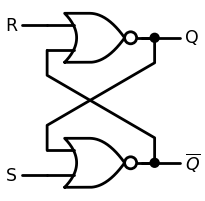

In [81]:
#@title
import schemdraw
from schemdraw import logic

with schemdraw.Drawing() as d:
    d += (g1 := logic.Nor())
    d.move_from(g1.in1, dy=-2.5)
    d += (g2 := logic.Nor().anchor('in1'))
    d += (g1out := logic.Line().right(.25).at(g1.out))
    d += logic.Wire('N', k=.5).at(g2.in1).to(g1out.end).dot()
    d += (g2out := logic.Line().right(.25).at(g2.out))
    d += logic.Wire('N', k=.5).at(g1.in2).to(g2out.end).dot()
    d += logic.Line().at(g1.in1).left(.5).label('R', 'left')
    d += logic.Line().at(g2.in2).left(.5).label('S', 'left')
    d += logic.Line().at(g1.out).right(.75).label('Q', 'right')
    d += logic.Line().at(g2.out).right(.75).label('$\overline{Q}$', 'right')


Neste circuito, usamos a entrada $S$ para armazenar 1 (*set*) e a entrada $R$ para armazenar 0 (*reset*), conforme as linhas centrais da tabela. A porta $Q$ apresenta o valor armazenado e a porta $\overline{Q}$ o seu inverso. Quando nenhuma das entradas √© acionada, os valores de $Q$ e $\overline{Q}$ s√£o mantidos. Quando as duas entradas s√£o acionadas ao mesmo tempo, temos um estado inconsistente e as sa√≠das se tornam ambas zero. Se as removemos ao mesmo tempo, temos uma condi√ß√£o de corrida que vai resultar em apenas uma das sa√≠das zero. Observe na anima√ß√£o abaixo que quando $S$ e $R$ n√£o est√£o ativados $Q$ guarda o √∫ltimo deles que foi acionado.

![](https://github.com/menotti/ld/blob/main/figs/latch.gif?raw=true)

Apesar de ser capaz de armazenar um bit, o *latch* acima n√£o √© muito √∫til. Vamos adicionar nele uma porta chamada ***enable***, para que possamos proteger ele de altera√ß√µes quando esta porta n√£o estiver ativa. Para isso, basta fazer um AND l√≥gico desta entrada com as outras duas, conforme o circuito a seguir.  

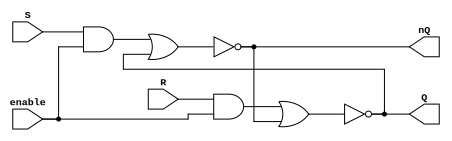

In [82]:
%%print_verilog -n latchSR.v

module latchSR(input enable, S, R, output Q, nQ);
  and (cS, S, enable);
  and (cR, R, enable);
  nor (Q, cR, nQ);
  nor (nQ, cS, Q);
endmodule

Observe na simula√ß√£o a seguir que $S$ e $R$ s√≥ t√™m efeito quando o sinal ***enable*** est√° ativo:

VCD info: dumpfile dump.vcd opened for output.



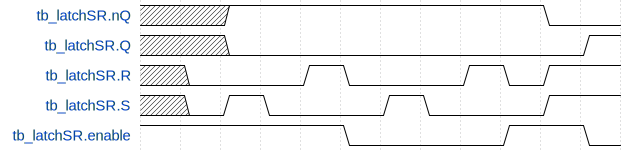

In [129]:
#@title
%%wavedrom
`include "latchSR.v"

module tb_latchSR;

  reg S, R, enable;
  wire Q, nQ;

  latchSR dut(S, R, enable, Q, nQ);

  initial
  begin
    $dumpvars(1);
    enable = 1;
    #5 S = 0; R = 0;
    #5 S = 1; R = 0;
    #5 S = 0; R = 0;
    #5 S = 0; R = 1;
    #5 S = 0; R = 0;
    enable = 0;
    #5 S = 1; R = 0;
    #5 S = 0; R = 0;
    #5 S = 0; R = 1;
    #5 S = 0; R = 0;
    enable = 1;
    #5 S = 1; R = 1;
    #5;
    enable = 0;
  end
endmodule

Isso n√£o impede de fazermos $S$ e $R$ ativos ao mesmo tempo, levando a um estado inconsistente em que $Q$ = $\overline{Q}$ = $0$. Veja esta condi√ß√£o no final da simula√ß√£o, o estado seguinte n√£o pode ser previsto, pois acontece uma condi√ß√£o de corrida quando o ***enable*** √© desligado.

Vamos aprimorar um pouco mais o nosso *latch*, incluindo uma porta $D$, fazendo ela acionar $S$ e sua nega√ß√£o acionar $R$. Assim, elas sempre ter√£o valores contr√°rios, mas estaremos sempre fazendo ***set*** ou ***reset***. Isso n√£o ser√° um problema, j√° que podemos bloquear as a√ß√µes desabilitando o ***enable***.

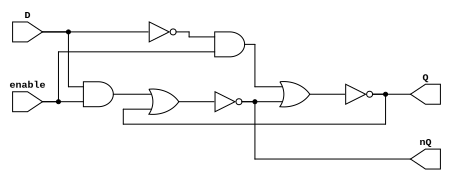

In [84]:
%%print_verilog

module latchD(input enable, D, output Q, nQ);
  and (cS, D, enable);
  and (cR, ~D, enable);
  nor (Q, cR, nQ);
  nor (nQ, cS, Q);
endmodule

Podemos tamb√©m especificar um *latch* simples usando Verilog comportamental. O s√≠mbolo usado no bloco gerado pela ferramenta indica que a entrada $D$ √© sens√≠vel ao n√≠vel de ***enable***.

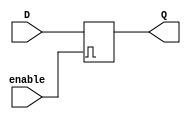

In [131]:
%%print_verilog -n latchD.v

module latchD(input enable, D, output reg Q);
  always @(D or enable)
    if (enable)
      Q = D;
endmodule

Observe sua simula√ß√£o a seguir:

VCD info: dumpfile dump.vcd opened for output.



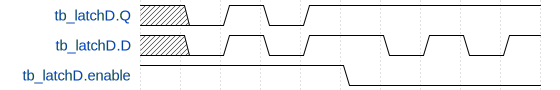

In [133]:
#@title
%%wavedrom
`include "latchD.v"

module tb_latchD;

  reg D, enable;
  wire Q;

  latchD dut(enable, D, Q);

  initial
  begin
    $dumpvars(1);
    enable = 1;
    #5 D = 0;
    #5 D = 1;
    #5 D = 0;
    #5 D = 1;
    #5;
    enable = 0;
    #5 D = 0;
    #5 D = 1;
    #5 D = 0;
    #5 D = 1;
  end
endmodule


## Flip-flop

Apesar dos *latches* serem capazes de armazenar valores em um circuito, eles podem causar condi√ß√µes de corrida indesejadas. Nos circuitos sequenciais, em geral, s√£o usados *flip-flops*, circuitos sens√≠veis √† borda ao inv√©s do n√≠vel. Eles podem ser obtidos por dois *latches* em s√©rie, com os sinais ***enable*** invertidos. Eles s√£o chamados mestre-escravo, pois quando o primeiro *latch* est√° habilitado (mestre) o segundo est√° desabilitado (escravo) e vice-versa. A combina√ß√£o da figura a seguir torna o circuito sens√≠vel √† borda de descida, pois neste exato momento o valor do mestre √© transferido para o escravo.

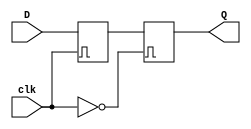

In [87]:
%%print_verilog
`include "latchD.v"

module FFD(input D, clk, output Q);
  latchD master(clk, D, iQ);
  latchD slave(~clk, iQ, Q);
endmodule

A forma mais comum de especificar circuitos sequenciais em Verilog comportamental √© fazendo as atribui√ß√µes de valores dentro de blocos `always@(posedge clk)`. Note que a entrada $D$ n√£o aparece na lista sensitiva do comando e que um s√≠mbolo > foi adicionado √† porta ***clk***, indicando que o circuito √© sens√≠vel √† borda de subida (posedge) ou descida (negedge).  

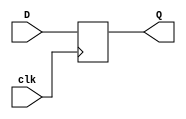

In [88]:
%%print_verilog -n FFD.v

module FFD(input clk, D, output reg Q);
  always@(posedge clk)
    Q = D;
endmodule

Veja sua simula√ß√£o a seguir. N√≥s mudamos as entradas propositalmente nas bordas de descida, para que fique claro que ela s√≥ propaga para a sa√≠da na borda de subida. Mudar a entrada junto com a borda de subida pode tornar a simula√ß√£o amb√≠gua, mas √© esperado que a entrada considerada seja a anterior.

VCD info: dumpfile dump.vcd opened for output.



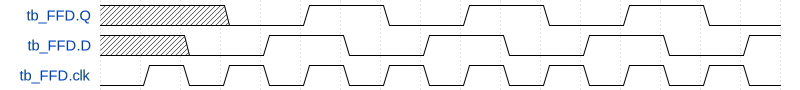

In [89]:
%%wavedrom
`include "FFD.v"

module tb_FFD;

  reg D, clk;
  wire Q;

  FFD dut(clk, D, Q);

  always
  begin
     clk = 0; #5 clk = 1; #5;
  end

  initial
  begin
    $dumpvars(1);
    #10 D = 0;
    #10 D = 1;
    #10 D = 0;
    #10 D = 1;
    #10 D = 0;
    #10 D = 1;
    #10 D = 0;
    #10 D = 1;
    $finish;
  end
endmodule



# Circuitos sequ√™nciais t√≠picos

Os flip-flops s√£o a base de constru√ß√£o dos circuitos sequenciais e, em geral, uma especifica√ß√£o Verilog que gera *latches* √© indesejada. Vejamos agora alguns circuitos sequ√™ncias t√≠picos e suas aplica√ß√µes.



## Registradores

Se um flip-flop pode armazenar um bit, um conjunto deles pode armazenar um byte, palavras, etc. Vejamos um implementa√ß√£o gen√©rica, que pode ser instanciada com v√°rios bits. Nesta especifica√ß√£o usamos um reset assincrono (`rst`), mas voc√™ pode torn√°-lo s√≠ncrono removendo ele da linha 8 e deixando apenas `posedge clk` (observe a diferen√ßa no circuito).


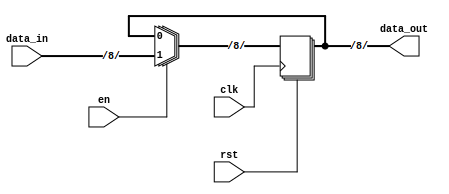

In [134]:
%%print_verilog -n regn.v

module regn #(parameter width = 8) (
  input clk, rst, en,
  input [width-1:0] data_in,
  output reg [width-1:0] data_out);

  always@(posedge clk or posedge rst)
    if (rst)
      data_out = 0;
    else
      if (en)
        data_out = data_in;
endmodule

Em sua simula√ß√£o notamos que ele tem um valor indefinido inicialmente, depois √© resetado na borda de subida e finalmente carregado com um valor de entrada apenas quando o sinal `en` est√° ativo no momento da subida do rel√≥gio. Experimente a simula√ß√£o com o `rst` ass√≠ncrono e depois s√≠ncrono.

VCD info: dumpfile dump.vcd opened for output.



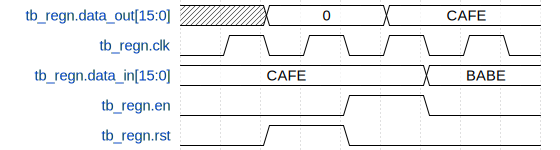

In [91]:
%%wavedrom
`include "regn.v"

module tb_regn;
  reg clk, rst, en;
  reg [15:0] data_in;
  wire [15:0] data_out;

  regn #(16) r16(clk, rst, en, data_in, data_out);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    clk = 0; en = 0; rst = 0; data_in = 16'hcafe;
    #10 rst = 1;
    #10 rst = 0; en = 1;
    #10 en = 0; data_in = 16'hbabe;
    #10 $finish;
  end

endmodule

Sem d√∫vidas nosso registrador com largura vari√°vel, reset s√≠ncrono ou ass√≠ncrono e sinal de habilita √© muito √∫til, mas a linguagem Verilog tem uma forma de declarar exatamente isso com uma palavra chave `reg` e seu contexto adequado.

O m√≥dulo a seguir √© capaz de gerar a sequ√™ncia de Fibonacci com apenas dois registradores (`a` e `b`). Na maioria das linguagens de programa√ß√£o n√≥s precisariamos de tr√™s vari√°veis para fazer isso, j√° que as instru√ß√µes s√£o executadas sequencialmente. Em Verilog, usando o operador de atribui√ß√£o `<=` nas linhas 16 e 17, dizemos que os dois registradores s√£o atualizados exatamente no mesmo instante, ou seja, na borda de subida do `clk`.

O operador de atribui√ß√£o `=>` √© chamado n√£o-bloqueante por tornar as atribui√ß√µes totalmente independentes entre si e, portanto, podem estar em qualquer ordem no c√≥digo. O operador `=` √© a vers√£o bloqueante, ou seja, ela faz com que as atribui√ß√µes posteriores dependam das anteriores quando usam a mesma vari√°vel. No nosso exemplo abaixo, a linha 17 usaria a nova vers√£o de `a` que foi atribuida na linha anterior, ou seja, o pr√≥prio `b`, tornando o c√≥digo ineficaz.

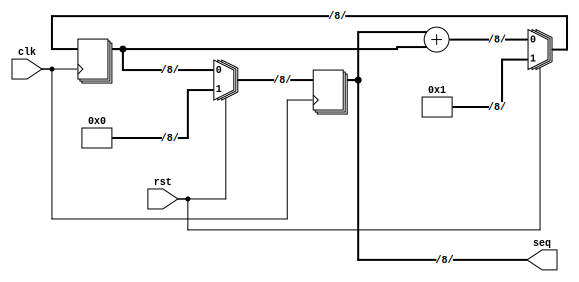

In [92]:
%%print_verilog -n fibo.v
module fibo(
  input clk, rst,
  output [7:0] seq);

  reg [7:0] a, b;

  always@(posedge clk)
    if (rst)
    begin
      a <= 0;
      b <= 1;
    end
    else
    begin
      a <= b; // experimente trocar por =
      b <= a + b; // experimente trocar por =
    end
  assign seq = a;
endmodule

Experimente alternar entre atribui√ß√µes bloqueantes (`<=`) e n√£o-bloqueantes (`=`), repita a gera√ß√£o do circuito acima e sua simula√ß√£o abaixo para ver o seu resultado. Mude o par√¢metro da fun√ß√£o `$dumpvars(0)` para mostrar os valores internos de `a` e `b`.

<h2>Exerc√≠cio</h2>

Tente implementar o mesmo circuito instanciando dois registradores do modelo [fornecido anteriormente](https://colab.research.google.com/drive/19Hx2VVszGURzVRCw6IQqC9SXse4hBxse?authuser=1#scrollTo=r_wAVKqVoTsV). Use o mesmo teste a seguir para comprovar o seu funcionamento.

VCD info: dumpfile dump.vcd opened for output.
  x
  0
  1
  2
  3
  5
  8
 13
 21
 34
 55
 89
144
233



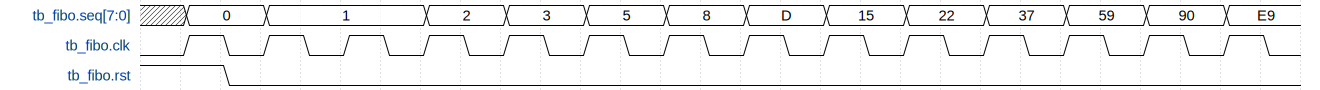

In [93]:
%%wavedrom
`include "fibo.v"

module tb_fibo;
  reg clk, rst;
  wire [7:0] seq;

  fibo uut(clk, rst, seq);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    $monitor("%d", seq);
    clk = 0; rst = 1;
    #10 rst = 0;
    #130 $finish;
  end
endmodule

Se voc√™ teve dificuldades em entender o exemplo anterior, vamos usar um mais simples primeiro. O m√≥dulo abaixo possui uma entrada `i`, um registrador intermedi√°rio `m` e um registrador na sa√≠da `o`. Tendo em conta que os registadores s√£o atualizados sempre no mesmo instante, na subida do `clk`, experimente as mudan√ßas a seguir no c√≥digo, primeiro individualmente e depois combina√ß√µes delas:
  * Troque `<=` por `=`;
  * Remova o `m` da sa√≠da;
  * Remova o `+1` da atribui√ß√£o;
  * Troque a ordem das atribui√ß√µes;

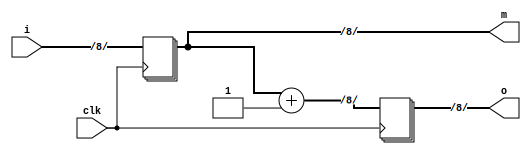

In [94]:
%%print_verilog
module nao_bloqueante(
  input clk,
  input [7:0] i,
  output [7:0] m,
  output reg[7:0] o);
  reg [7:0] m;
  always@(posedge clk)
  begin
    m <= i;
    o <= m+1;
  end
endmodule

## Contadores

Contadores s√£o bastante √∫teis nos circuitos digitais para contabilizar eventos e controlar temporiza√ß√µes. Eles podem ser gerados a partir de flip-flops, mas para facilitar vamos especific√°-los diretamente na forma comportamental.

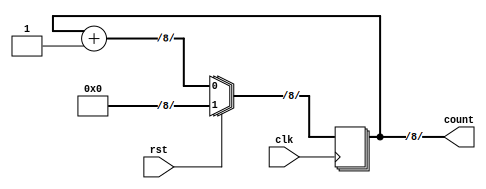

In [95]:
%%print_verilog -n counter.v
module counter(
    input clk, rst,
    output reg [7:0] count);

    always@(posedge clk)
      if (rst)
        count = 'b0;
      else
        count = count + 1;
endmodule

VCD info: dumpfile dump.vcd opened for output.



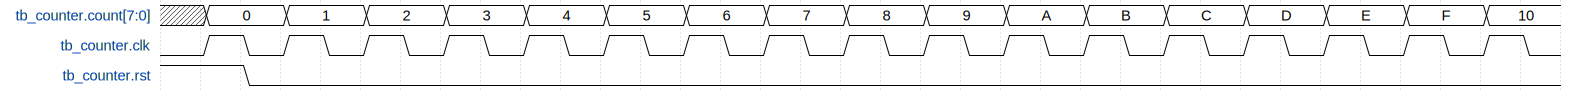

In [96]:
%%wavedrom
`include "counter.v"

module tb_counter;
  reg clk, rst;
  wire [7:0] count;

  counter dut(clk, rst, count);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    clk = 0; rst = 1;
    #10 rst = 0;
    #160 $finish;
  end
endmodule

Agora vamos construir um contador mais sofisticado, de largura parametriz√°vel, capaz de carregar um valor inicial informado e que possa incrementar e decrementar. A porta de reset se chama `arst_n`, o prefixo **a** indica que √© ass√≠ncrona e o sufixo **n** que √© *active low*. Al√©m da contagem, ele tamb√©m possuiu uma sa√≠da que indica quando o limite da contagem foi atingido e o contador dar√° a volta (`wraparound`).

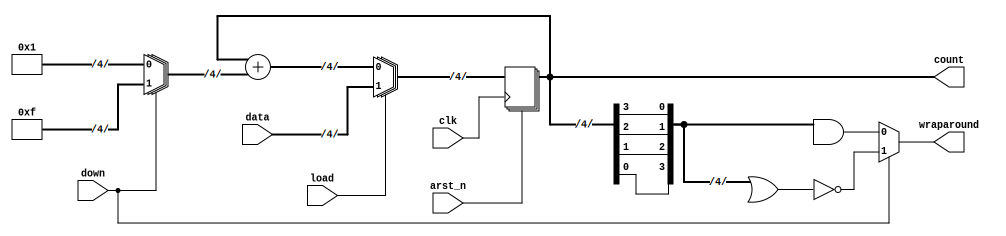

In [97]:
%%print_verilog -n updown_load_counter.v
module updown_load_counter
  #(parameter N = 4)(
  input clk, arst_n,
  input [N-1:0] data,
  input load, down,
  output reg [N-1:0] count,
  output wraparound);

  always @(posedge clk or negedge arst_n)
    if (!arst_n)
      count <= 'b0;
    else
      if (load)
        count <= data;
      else
        count <= count + (down ? -1 : +1);

  assign wraparound = down ? ~|count : &count;
endmodule

## Deslocadores

Fazer o deslocamento de bits √© uma opera√ß√£o muito comum em circuitos digitais. Existem v√°rios protocolos de comunica√ß√£o que transmitem dados serialmente e, portanto, estes precisam ser enfileirados bit a bit. J√° quando representamos n√∫meros, deslocar o valor um bit para a esquerda significa multiplic√°-lo por dois. Da mesma forma, deslocar o valor um bit para a direita significa dividi-lo por dois.

Vejamos a seguir um m√≥dulo que recebe os bits de um _nibble_ serialmente e permite sua leitura tanto serialmente quanto em paralelo ao final. Note que ele √© carregado a partir do MSB e lido (serialmente) a partir do LSB.



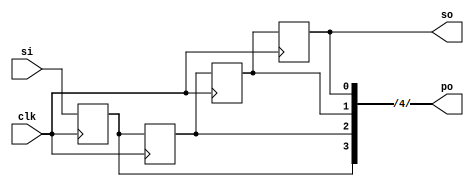

In [98]:
%%print_verilog -n shift_nibble.v
`include "FFD.v"

module shift_nibble(
    input clk, si,    // entrada serial
    output so,        // sa√≠da serial
    output [3:0] po); // sa√≠da paralela

    FFD b3(clk,    si, po[3]);
    FFD b2(clk, po[3], po[2]);
    FFD b1(clk, po[2], po[1]);
    FFD b0(clk, po[1], po[0]);

    assign so = po[0];
endmodule

Observe sua simula√ß√£o:

VCD info: dumpfile dump.vcd opened for output.
s      s
i  po  o
1 xxxx x
1 1xxx x
1 11xx x
1 111x x
1 1111 1
0 1111 1
0 0111 1
0 0011 1
0 0001 1
0 0000 0



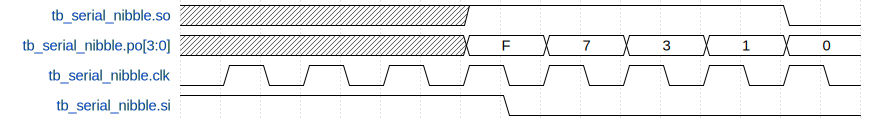

In [99]:
%%wavedrom
`include "shift_nibble.v"

module tb_serial_nibble;
  reg clk, si;
  wire so;
  wire [3:0] po;

  shift_nibble dut(clk, si, so, po);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    $display("s      s");
    $display("i  po  o");
    $monitor("%0b %4b %0b", si, po, so);
    clk = 0; si = 1;
    #40 si = 0;
    #40 $finish;
  end
endmodule

Vamos agora usar Verilog comportamental para especificar um deslocador mais vers√°til. Ele permite a carga de um valor arbitr√°rio a partir da porta `i_data` e o sinal de controle `load`, o que pode substituir a necessidade de um reset. O circuito possui uma entrada serial `si` e √© capaz de deslocar para a direita e para a esquerda.

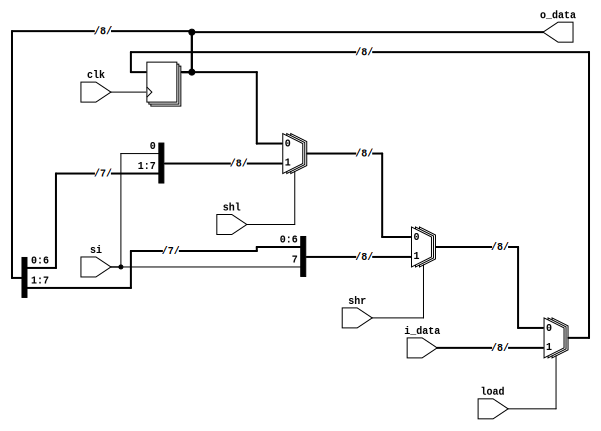

In [100]:
%%print_verilog -n shifter.v
module shifter #(parameter N = 8)(
    input clk, load, shl, shr,
    input si, input [N-1:0] i_data,
    output reg [N-1:0] o_data);

    always@(posedge clk)
      if (load)
        o_data <= i_data;
      else
        if (shr)
          o_data <= {si, o_data[N-1:1]};
        else
          if (shl)
            o_data <= {o_data, si};
endmodule

VCD info: dumpfile dump.vcd opened for output.
xxxxxxxxxxxxxxxx
load...
1100101011111110
>>
1110010101111111
1111001010111111
1111100101011111
1111110010101111
<<
1111100101011111
1111001010111111
1110010101111111
1100101011111110



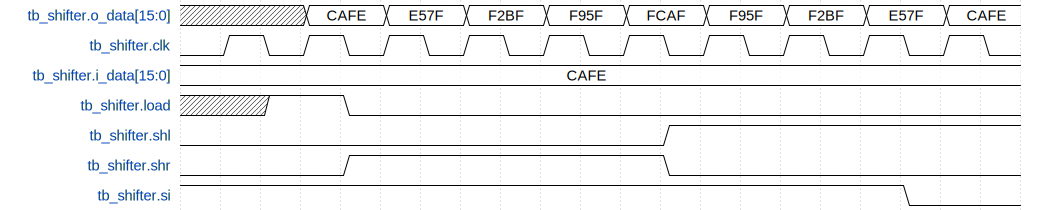

In [101]:
%%wavedrom
`include "shifter.v"

module tb_shifter;
    reg clk, load, shl, shr, si;
    reg [15:0] i_data;
    wire [15:0] o_data;

    shifter #(16) dut(clk, load, shl, shr, si, i_data, o_data);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    $monitor("%8b", o_data);
    clk = 0; si = 1; shl = 0; shr = 0; i_data = 16'hCAFE;
    #10 load = 1;
    $display("load...");
    #10 load = 0; shr = 1;
    $display(">>");
    #40  shl = 1; shr = 0;
    $display("<<");
    #30 si = 0;
    #10 $finish;
  end
endmodule

## Problemas

Antes de introduzirmos as m√°quinas de estados finitos, usadas para modelar cicuitos mais complexos, vejamos dois √∫ltimos exemplos de circuitos sequenciais com problemas reais.

O cicuito especificado a seguir calcula o **m√≠nimo m√∫ltiplo comum** entre dois n√∫meros por um m√©todo simples que consiste em acumular o menor deles interativamente at√© que os dois sejam iguais. Na tabela a seguir demostramos sua execu√ß√£o, destacando o menor em negrito a cada passo:

a|b
-:|-:
**3**|4
6|**4**
**6**|8
9|**8**
**9**|12
12|12

Sua implementa√ß√£o foi descrita em Verilog comportamental:

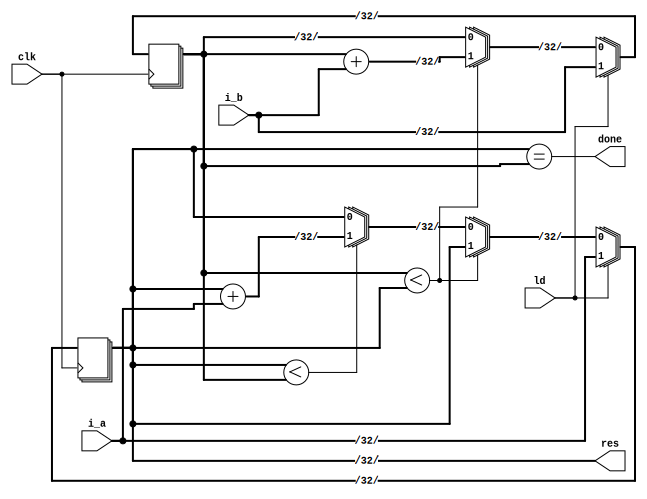

In [102]:
%%print_verilog -n mmc.v

module mmc_b( //comportamental
  input clk, ld,
  input [31:0] i_a, i_b,
  output [31:0] res, //resultado
  output done); //pronto

  reg [31:0] a, b;

  always @(posedge clk)
    if (ld) begin // carrega
      a <= i_a;   // valores
      b <= i_b;   // iniciais
    end
    else // acumula o menor
      if (b < a)
        b <= b + i_b;
      else
        if (a < b)
          a <= a + i_a;
  // ao final, os dois serao iguais
  assign res = a;
  assign done = (a == b);
endmodule

Note que o circuito obtido possui apenas os dois registradores declarados, multiplexadores, comparadores e somadores. Em seu teste abaixo, usando os mesmos valores j√° demonstrados, vamos uma um novo recurso, a clausul√° `wait`. Como o n√∫mero de ciclos depende dos valores computados, fazemos a carga inicial dos valores e aguardamos o sinal `done` que indica o t√©rmino da computa√ß√£o (linha 21).

VCD info: dumpfile dump.vcd opened for output.



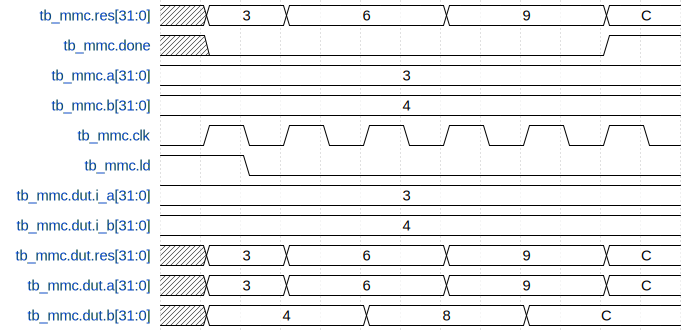

In [103]:
%%wavedrom
`include "mmc.v"

module tb_mmc;
  reg clk, ld;
  reg [31:0] a, b;
  wire [31:0] res;
  wire done;

  mmc_b dut(clk, ld, a, b, res, done);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(0);
    clk = 0; ld = 1;
    a = 3; b = 4; // experimente com outros valores
    #10 ld = 0;
    wait (done==1);
    #5 $finish;
  end
endmodule


O pr√≥ximo circuito, apresentado a seguir, calcula o **m√°ximo divisor comum** entre dois n√∫meros. O algoritmo usado √© bastante parecido com o anterior, mas desta vez vamos subtrair o menor do maior at√© que um deles seja zero, o restante ser√° o resultado. Veja a tabela a seguir, destacando o menor a cada passo:

a|b
-:|-:
**18**|60
**18**|42
**18**|24
18|**6**
12|**6**
**6**|6
0|6

Desta vez, vamos usar Verilog estrutural e funcional para construir o circuito a partir de registradores e de atribui√ß√µes cont√≠nuas. Note que sua descri√ß√£o fica bastante diferente da anterior, apesar da semelhan√ßa entre os circuitos gerados.

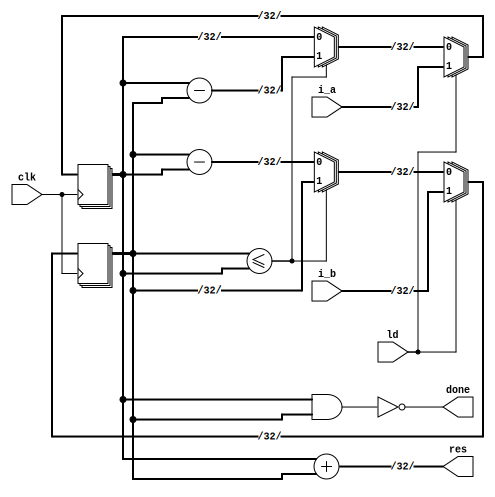

In [104]:
%%print_verilog -n mdc.v
module mdc_s( //estrutural
  input clk, ld,
  input [31:0] i_a, i_b,
  output [31:0] res, //resultado
  output done); //pronto

  wire [31:0] a, b, a_i_b, b_i_a;
  wire en;
  // subtrai o menor do maior
  assign a_i_b = a - b;
  assign b_i_a = b - a;
  assign en = b <= a;

  reg32 ra(ld, clk, en, i_a, a_i_b, a);
  reg32 rb(ld, clk, !en, i_b, b_i_a, b);
  // ao final, um deles sera zero
  assign res  = a + b;
  assign done = !(a && b);
endmodule

module reg32(
  input ld, clk, en,
  input [31:0] data_l, data_i,
  output reg [31:0] data_o);
  always @(posedge clk)
    if (ld) data_o  = data_l;
    else if (en) data_o = data_i;
endmodule

Usamos praticamente o mesmo teste para este novo problema, mas note que √© poss√≠vel incluir no `$monitor` valores que est√£o no m√≥dulo instanciado (linha 18):



VCD info: dumpfile dump.vcd opened for output.
         x         x
        18        60
        18        42
        18        24
        18         6
        12         6
         6         6
         0         6



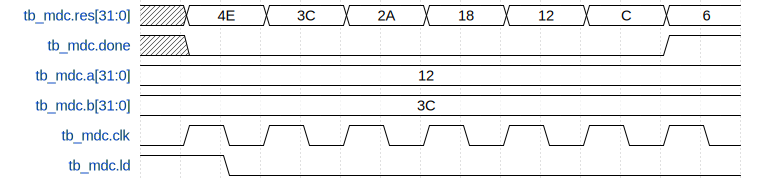

In [105]:
%%wavedrom
`include "mdc.v"

module tb_mdc;
  reg clk, ld;
  reg [31:0] a, b;
  wire [31:0] res;
  wire done;

  mdc_s dut(clk, ld, a, b, res, done);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    $monitor(dut.a, dut.b);
    clk = 0; ld = 1;
    a = 18; b = 60;
    #10 ld = 0;
    wait (done==1);
    #5 $finish;
  end
endmodule

<h3>Exerc√≠cio</h3>

Tente implementar os dois algoritmos da outra forma, ou seja, o MMC na forma estrutural e o MDC na forma comportamental. Teste para ver se eles s√£o equivalentes √†s implementa√ß√µes fornecidas.

# M√°quinas de estados finitos (FSM)

Vimos at√© agora alguns circutos sequenciais simples, que possuem alguns poucos registradores e sinais de controle. Quando √© necess√°rio sincronizar muitas opera√ß√µes e sinais de controle, precisamos de uma metodologia que permita desenvolver o circuito de maneira mais organizada e sistem√°tica. As m√°quinas de estados finitos permitem implementar adequadamente circuitos mais complexos. A seguir veremos como elas funcionam e como desenvolver circuitos baseados nelas. Na figura a seguir est√° uma representa√ß√£o de como as FSM funcionam. A partir do estado atual e das entradas, um novo estado √© calculado. A sa√≠da depende apenas do estado atual no modelo de Moore mas tamb√©m das entradas no modelo de Mealy (linha azul). Em ambos modelos, temos  um √∫nico estado ativo por vez.



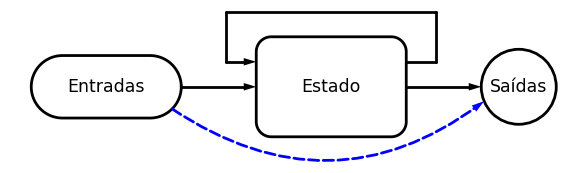

In [106]:
# @title
# import matplotlib.pyplot as plt
# plt.xkcd()
# plt.rcdefaults()
d = schemdraw.Drawing()
d.add(inicio := flow.Terminal().label('Entradas').drop('E'))
d += elm.Line(arrow='->').right(d.unit/2)
d.add(estado := flow.RoundBox(label='Estado'))
d += elm.Line(arrow='->').right(d.unit/2)
d.add(fim := flow.Connect().label('Sa√≠das'))
#feedback
#d.add(flow.Arrow().at(estado.E).right(d.unit/4))
#d.add(flow.Line(arrow='->').up(d.unit/2))
#d.add(flow.Wire('c', k=-4.5, arrow='->').to(estado.W))
d += elm.Line(arrow='-').at(estado.ENE).right(d.unit/5)
d += elm.Line(arrow='-').up(d.unit/3)
d += elm.Line(arrow='-').left(d.unit*1.4)
d += elm.Line(arrow='-').down(d.unit/3)
d += elm.Line(arrow='->').right(d.unit/5)
#forward
d += elm.Arc2(arrow='->', color='blue', k=-0.35, ls='--').at(inicio.SE).to(fim.WSW)
d.draw()

## Modelo de Moore

Vamos come√ßar com o modelo de Moore, no qual as sa√≠das dependem apenas do estado atual. No exemplo a seguir, maquina de estados finitos controla uma luz (L) a partir de um bot√£o (B), como em um controle remoto em que o mesmo bot√£o serve tanto para ligar quanto para desligar um aparelho.

No modelo de Moore, as sa√≠da s√£o anotadas nos estados, ent√£o temos $S_0$ com a luz apagada (L=0) e $S_1$ com a luz acesa (L=1). J√° as entradas, estas s√£o anotadas nas arestas, que representam as mudan√ßas de estado. Neste exemplo, quando o bot√£o est√° pressionado, ocorre a mudan√ßa no estado, caso cont√°rio, o estado permanece o mesmo. A aresta externa apontando para $S_0$ indica que ele √© o estado inicial quando o circuito √© inicializado. A FSM obtida a partir do enunciado √© a seguinte:



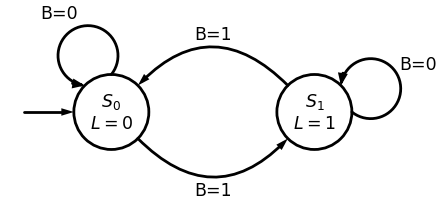

In [107]:
# @title
with schemdraw.Drawing() as d:
    d += elm.Arrow().length(1)
    d += (s1 := flow.State().anchor('W').label('$S_0$\n$L=0$'))
    d += elm.Arc2(arrow='<-').at(s1.NE).label('B=1')
    d += (s2 := flow.State().anchor('NW').label('$S_1$\n$L=1$'))
    d += elm.Arc2(arrow='<-').at(s2.SW).to(s1.SE).label('B=1')
    d += elm.ArcLoop(arrow='<-').at(s2.NE).to(s2.E).label('B=0')
    d += elm.ArcLoop(arrow='<-').at(s1.NW).to(s1.N).label('B=0')

J√° podemos perceber que um flip-flop do tipo T resolveria nosso problema, mas vamos seguir uma metodologia que poder√° ser usada posteriormente em problemas mais complexos.

O primeiro passo desta metodologia √©  construir uma tabela com as regras de transi√ß√£o e sa√≠das a partir da m√°quina de estados.

<table>
<thead>
  <tr>
    <th rowspan="2">Estado<br>Atual</th>
    <th colspan="2">Pr√≥ximo Estado</th>
    <th>Sa√≠da</th>
  </tr>
  <tr>
    <th>B=0</th>
    <th>B=1</th>
    <th>L</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>A</td>
    <td>A</td>
    <td>B</td>
    <td>0</td>
  </tr>
  <tr>
    <td>B</td>
    <td>B</td>
    <td>A</td>
    <td>1</td>
  </tr>
</tbody>
</table>

Depois, vamos definir quantos flip-flops precisamos para representar os estados e atribuir valores √∫nicos a eles em cada estado. No nosso exemplo, um √∫nico flip-flop pode mapear os dois estados poss√≠veis.

Vamos chamar sua sa√≠da de $E_0$ (mai√∫sculo) e de $e_0$ (min√∫sculo) a entrada deste flip-flop, ou seja, qual ser√° o pr√≥ximo estado. Nossa tabela de atribui√ß√£o de estados fica assim:

<table>
<thead>
  <tr>
    <th rowspan="2">Estado<br>Atual</th>
    <th colspan="2">Pr√≥ximo Estado</th>
    <th>Sa√≠da</th>
  </tr>
  <tr>
    <th>B=0</th>
    <th>B=1</th>
    <th>L</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>0</td>
    <td>0</td>
    <td>1</td>
    <td>0</td>
  </tr>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>0</td>
    <td>1</td>
  </tr>
</tbody>
</table>

Assim temos $L(E_0)=E_0$, ou seja, a sa√≠da L √© igual ao pr√≥prio estado $E_0$. J√° a fun√ß√£o de transi√ß√£o, que √© √∫nica, pois s√≥ temos um flip-flop fica $e_0(B, E_0)=B.\overline{ E_0}+\overline{ B}.E_0 = B \oplus E_0$. Conforme explicamos anteriormente, neste modelo a sa√≠da s√≥ depende do estado atual e o pr√≥ximo estado depende do estado atual e da entrada. Aqui temos uma implementa√ß√£o estrutural a partir de um √∫nico flip-flop D capaz de armazenar os dois estados da m√°quina (linha 7). A fun√ß√£o de sa√≠da s√≥ depende deste estado (linha 8) e finalmente a fun√ß√£o de transi√ß√£o depende do estado atual e da entrada (linha 9).


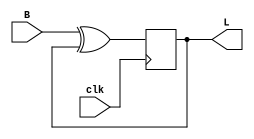

In [108]:
%%print_verilog
`include "FFD.v"

module fsm(
  input clk, B,
  output L);
  FFD E0(clk, e, E); //estado atual
  assign L = E;      //fun√ß√£o de sa√≠da
  xor (e, B, E);     //fun√ß√£o de transi√ß√£o
endmodule

Esta implementa√ß√£o √© v√°lida, porem o flip-flop D usado n√£o possui reset, ent√£o n√£o √© poss√≠vel saber o estado inicial do circuito e consequentemente simul√°-lo. A seguir est√° uma implementa√ß√£o comportamental do mesmo circuito, incluindo um reset ass√≠ncrono. Tamb√©m fizemos a sa√≠da `L` ser o pr√≥prio registrador de estado.

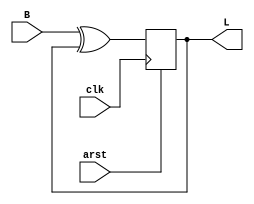

In [109]:
%%print_verilog -n BL.v
module BL(
  input clk, arst, B,
  output reg L);

  always@(posedge clk or posedge arst)
    if (arst)
      L = 0;
    else
      L = B ^ L;
endmodule

Na simula√ß√£o a seguir, podemos observar que:

*   O reset √© ass√≠ncrono e tem efeito imediatamente;
*   O circuito √© capaz de acender e depois de apagar a luz (L) a partir do pressionamento do bot√£o (B) durante a subida do rel√≥gio;
*   Se o bot√£o ficar acionado a l√¢mpada ir√° piscar a cada subida do clock.

Em termos pr√°ticos, este funcionamento √© inadequado, j√° que os circuitos costumam operar em frequ√™ncias na casa dos MHz e seria praticamente imposs√≠vel pressionar o bot√£o por uma √∫nica subida do rel√≥gio como vemos na parte central da simula√ß√£o.

VCD info: dumpfile dump.vcd opened for output.



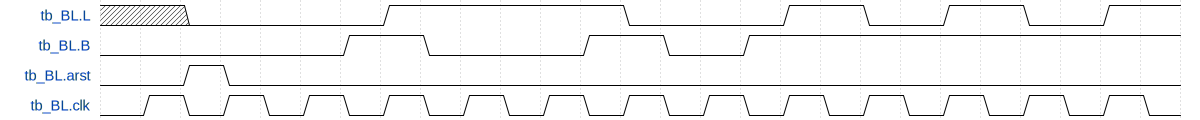

In [110]:
%%wavedrom
`include "BL.v"

module tb_BL;
  reg clk, arst, B;
  wire L;

  BL dut(clk, arst, B, L);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    clk = 0; arst = 0; B = 0;
    #10 arst = 1;
    #5 arst = 0;
    #15 B = 1; #10 B = 0;
    #20 B = 1; #10 B = 0;
    #10 B = 1;
    #50 $finish;
  end
endmodule

Para que o circuito funcione adequadamente, mesmo com um rel√≥gio em alta frequ√™ncia, vamos reestruturar nossa FSM conforme o diagrama a seguir. Aqui a linha dupla indica que $S_0$ √© o estado inicial, embora esta nota√ß√£o seja usada para indicar tamb√©m estados finais. Quando o bot√£o √© pressionado, passamos ao estado $S_1$ no qual a luz √© acesa e ficamos neste estado enquanto o bot√£o permanecer pressionado. Passamos de $S_1$ para $S_2$ quando o bot√£o √© solto, mas a luz permanece acesa. Um novo pressionamento do bot√£o nos leva para o estado $S_3$ quando a luz √© apagada e voltamos para $S_0$ quando o bot√£o √© solto. Desta forma o pressionamento do bot√£o n√£o causa v√°rias mudan√ßas de estado, independentemente de quantos ciclos de rel√≥gio ele permanecer pressionado.

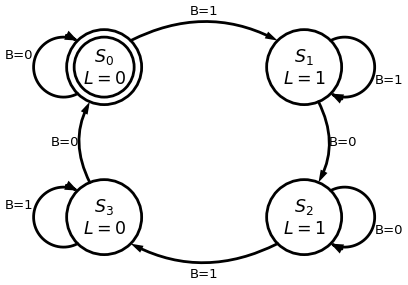

In [111]:
# @title
with schemdraw.Drawing() as d:
    d += (s0 := flow.StateEnd().at((0,3)).label('$S_0$\n$L=0$'))
    d += (s1 := flow.State().at(   (4,3)).label('$S_1$\n$L=1$'))
    d += (s2 := flow.State().at(   (4,0)).label('$S_2$\n$L=1$'))
    d += (s3 := flow.State().at(   (0,0)).label('$S_3$\n$L=0$'))

    d += elm.ArcLoop(arrow='->').at(s0.SW).to(s0.NW).label('B=0', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s1.NE).to(s1.SE).label('B=1', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s2.NE).to(s2.SE).label('B=0', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s3.SW).to(s3.NW).label('B=1', fontsize=11)

    d += elm.Arc2(k=.25, arrow='->').at(s0.NE).to(s1.NW).label('B=1', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s1.SSE).to(s2.NNE).label('B=0', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s2.SW).to(s3.SE).label('B=1', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s3.NNW).to(s0.SSW).label('B=0', fontsize=11)

Vamos aplicar novamente a mesma metodologia para desenvolver o circuito. Inicialmente construimos a **tabela de transi√ß√µes de estados** a partir da FSM:

<table>
<thead>
  <tr>
    <th rowspan="2">Estado<br>Atual</th>
    <th colspan="2">Pr√≥ximo Estado</th>
    <th>Sa√≠da</th>
  </tr>
  <tr>
    <th>B=0</th>
    <th>B=1</th>
    <th>L</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>S0</td>
    <td>S0</td>
    <td>S1</td>
    <td>0</td>
  </tr>
  <tr>
    <td>S1</td>
    <td>S2</td>
    <td>S1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>S2</td>
    <td>S2</td>
    <td>S3</td>
    <td>1</td>
  </tr>
  <tr>
    <td>S3</td>
    <td>S0</td>
    <td>S3</td>
    <td>0</td>
  </tr>
</tbody>
</table>

Agora construimos a **tabela de atribui√ß√£o de estados** e, novamente, faremos uma atribui√ß√£o sequencial dos valores.

<table>
<thead>
  <tr>
    <th rowspan="2">Estado<br>Atual</th>
    <th colspan="2">Pr√≥ximo Estado</th>
    <th>Sa√≠da</th>
  </tr>
  <tr>
    <th>B=0</th>
    <th>B=1</th>
    <th>L</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>00</td>
    <td>00</td>
    <td>01</td>
    <td>0</td>
  </tr>
  <tr>
    <td>01</td>
    <td>10</td>
    <td>01</td>
    <td>1</td>
  </tr>
  <tr>
    <td>10</td>
    <td>10</td>
    <td>11</td>
    <td>1</td>
  </tr>
  <tr>
    <td>11</td>
    <td>00</td>
    <td>11</td>
    <td>0</td>
  </tr>
</tbody>
</table>

Para guardar os quatro estados listados na tabela precisamos de exatamente dois flip-flop, que vamos chamar de $E_1$ (MSB) e $E_0$ (LSB). Em FSMs mais complexas podemos fazer um Mapa de Karnaugh para cada express√£o, usando *don't care* para as sa√≠das que n√£o representam nenhum estado. Aqui conseguimos inferi-las facilmente, apenas observando a tabela:

* $e_1(B, E_1, E_0)  = \overline{B}.(E_1 \oplus E_0) + B.E_1$
* $e_0(B, E_1, E_0) = B$
* $L(E_1, E_0) = E_1 \oplus E_0$

Seguindo as express√µes para implementar o Verilog estrutural temos o seguinte:

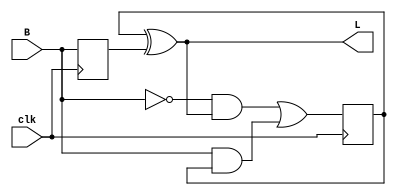

In [112]:
%%print_verilog -n fsm4.v
`include "FFD.v"

module fsm4(
  input clk, B,
  output L);
  wire [1:0] e, E;
  FFD E1(clk, e[1], E[1]); //estado atual
  FFD E0(clk, e[0], E[0]); //estado atual
  xor (L, E[1], E[0]);     //fun√ß√£o de sa√≠da
  assign e[0] = B;         //fun√ß√µes de transi√ß√£o
  assign e[1] = ~B & L | B & E[1];
endmodule

Novamente, vamos fazer uma implementa√ß√£o com Verilog comportamental e incluir um reset ass√≠ncrono para poder simular.

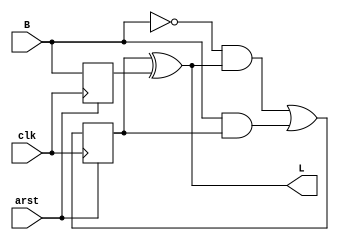

In [113]:
%%print_verilog -n BL2.v
module BL2(
  input clk, arst, B,
  output L);

  reg E1, E0;

  always@(posedge clk or posedge arst)
    if (arst)
    begin
      E1 <= 1'b0;
      E0 <= 1'b0;
    end
    else
    begin
      E1 <= ~B & L | B & E1;
      E0 <= B;
    end
  assign L = E1 ^ E0;
endmodule

Note que o circuito obtido √© exatamente igual ao anterior, exceto pelo reset. Na simula√ß√£o a seguir podemos observar que o pressionamento do bot√£o por mais de um ciclo s√≥ causa uma transi√ß√£o de estado, o que evita que a luz pisque quando ele estiver acionado. Incluimos a entrada, o estado interno e a sa√≠da no monitor do console para facilitar a compreens√£o.

B Sn L
VCD info: dumpfile dump.vcd opened for output.
0 00 0
1 00 0
1 01 1
0 01 1
0 10 1
1 10 1
1 11 0
0 11 0
0 00 0
1 00 0
1 01 1
0 01 1
0 10 1



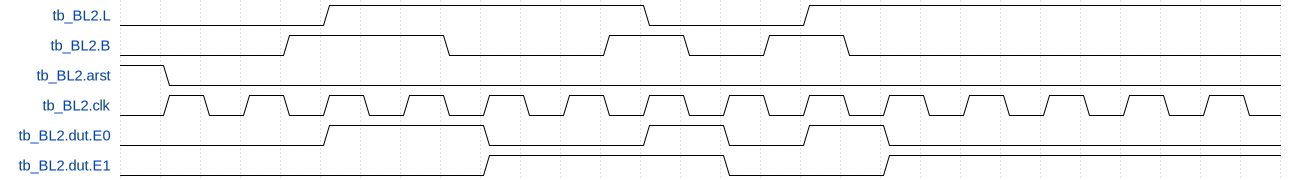

In [114]:
%%wavedrom
`include "BL2.v"

module tb_BL2;
  reg clk, arst, B;
  wire L;
  wire [1:0] S;

  BL2 dut(clk, arst, B, L);

  always
    #5 clk = ~clk;

  initial
  begin
    $display("B Sn L");
    $monitor("%b %b%b %b", B, dut.E1, dut.E0, L);
    $dumpvars(0);
    clk = 0; arst = 1; B = 0;
    #5 arst = 0;
    #15 B = 1; #20 B = 0;
    #20 B = 1; #10 B = 0;
    #10 B = 1; #10 B = 0;
    #50 $finish;
  end
endmodule

A atribui√ß√£o sequencial que fizemos aos estados n√£o √© obrigat√≥ria e a escolha deles tem influ√™ncia direta na complexidade do circuito. Para exemplificar, vamos fazer uma atribui√ß√£o alternativa aos bits dos estados, trocando apenas $S_2$ para `11` e $S_3$ para `10`. Nossa tabela de atribui√ß√£o de estados ficaria assim:

<table>
<thead>
  <tr>
    <th rowspan="2">Estado<br>Atual</th>
    <th colspan="2">Pr√≥ximo Estado</th>
    <th>Sa√≠da</th>
  </tr>
  <tr>
    <th>B=0</th>
    <th>B=1</th>
    <th>L</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>00</td>
    <td>00</td>
    <td>01</td>
    <td>0</td>
  </tr>
  <tr>
    <td>01</td>
    <td>11</td>
    <td>01</td>
    <td>1</td>
  </tr>
  <tr>
    <td>11</td>
    <td>11</td>
    <td>10</td>
    <td>1</td>
  </tr>
  <tr>
    <td>10</td>
    <td>00</td>
    <td>10</td>
    <td>0</td>
  </tr>
</tbody>
</table>

As novas express√µes seriam:

* $e_1(B, E_1, E_0) = \overline{B}.E_0 + B.E_1$
* $e_0(B, E_1, E_0)  = \overline{B}.E_0 + B.\overline{E_1}$
* $L(E_1, E_0) = E_0$

Note que o circuito resultante √© diferente do anterior, como √© de se esperar, mas a simula√ß√£o funciona exatamente igual. Em alguns casos, certas atribui√ß√µes de estado podem resultar em circuitos muito mais simples do que outro. N√£o e possivel encontrar a melhor solu√ß√£o (mais otimizada) sem testar todas as possibilidades, o que torna este um problema NP-completo. As ferramentas de s√≠ntese usam heur√≠sticas para resolve-lo e h√° parametros espec√≠ficos para favorecer solu√ß√µes com determinadas caracter√≠sticas, por exemplo, menor √°rea, maior frequ√™ncia, etc. Voc√™ pode usar o mesmo *test bench* do c√≥digo anterior, pois estamos salvando a implementa√ß√£o com o mesmo nome.

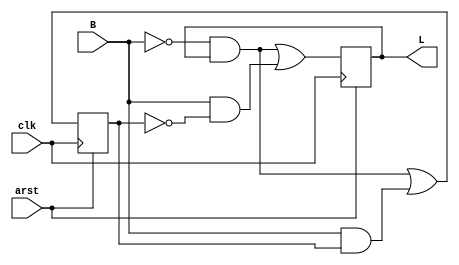

In [115]:
%%print_verilog -n BL2.v
module BL2(
  input clk, arst, B,
  output L);

  reg E1, E0;

  always@(posedge clk or posedge arst)
    if (arst)
    begin
      E1 <= 1'b0;
      E0 <= 1'b0;
    end
    else
    begin
      E1 <= ~B & E0 | B & E1;
      E0 <= ~B & E0 | B & ~E1;
    end
  assign L = E0;
endmodule

A metodologia usada aqui parte da especifica√ß√£o inicial da FSM e chega at√© as express√µes de cada bit usado para guardar os estados. Al√©m de termos que escolher uma codifica√ß√£o para os estados que n√£o sabemos ser a mais adequada, temos que espeficiar manualmente cada express√£o do circuito. Alternativamente, podemos construir o Verilog comportamental a partir da FSM, o que elimina a necessidade de descrever as express√µes. Al√©m de ser um processo mais simples, algumas ferramentas de s√≠ntese s√£o capazes de alterar a codifica√ß√£o da FSM automaticamente para otimizar o circuito. A seguir est√° uma implementa√ß√£o da mesma FSM usando Verilog comportamental para a FSM (e n√£o para os registradores como fizemos antes):

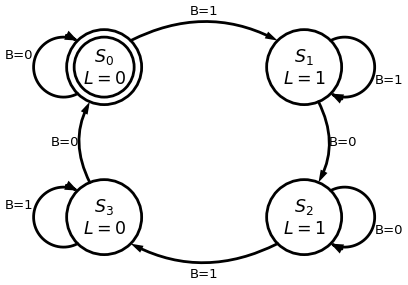

In [116]:
# @title
with schemdraw.Drawing() as d:
    d += (s0 := flow.StateEnd().at((0,3)).label('$S_0$\n$L=0$'))
    d += (s1 := flow.State().at(   (4,3)).label('$S_1$\n$L=1$'))
    d += (s2 := flow.State().at(   (4,0)).label('$S_2$\n$L=1$'))
    d += (s3 := flow.State().at(   (0,0)).label('$S_3$\n$L=0$'))

    d += elm.ArcLoop(arrow='->').at(s0.SW).to(s0.NW).label('B=0', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s1.NE).to(s1.SE).label('B=1', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s2.NE).to(s2.SE).label('B=0', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s3.SW).to(s3.NW).label('B=1', fontsize=11)

    d += elm.Arc2(k=.25, arrow='->').at(s0.NE).to(s1.NW).label('B=1', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s1.SSE).to(s2.NNE).label('B=0', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s2.SW).to(s3.SE).label('B=1', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s3.NNW).to(s0.SSW).label('B=0', fontsize=11)

Repetimos a figura da FSM para facilitar a escrita do c√≥digo. Apesar de ser mais extenso, n√£o precisamos nos preocupar com a codifica√ß√£o dos estados e as express√µes decorrentes disso. Podemos definir como ser√° a transi√ß√£o dos estados apenas observando a FSM e depois definir como ser√° a sa√≠da. Alguns aspectos importantes do c√≥digo a seguir:

* Cuidar para que os par√¢metros definidos para cada estado n√£o se repitam (linhas 7-10);
* Certificar-se de que as vari√°veis de estado (linha 13) t√™m a mesma largura dos par√¢metros (lembre-se de que atribui√ß√µes para espa√ßos menores s√£o permitidas);
* Listar todas as entradas e o estado atual na lista sensitiva do bloco que define o pr√≥ximo estado (linha 16);
* Atribuir o pr√≥ximo estado para `e` a partir do estado atual e das entradas;
* Incluir a op√ß√£o `default` no `case` para as codifi√ß√µes que n√£o ser√£o usadas;
* Atribuir o estado inicial ou o pr√≥ximo estado no bloco sequencial que funciona no reset ou na subida do rel√≥gio (linhas 30-32);
* Definir as sa√≠das a partir dos estados desenhados (linha 35).

Note que declaramos `e` do tipo `reg` para poder atribu√≠-lo dentro de um bloco `always`, mas como ele n√£o depende do rel√≥gio, n√£o gera flip-flops, diferentemente de `E`.

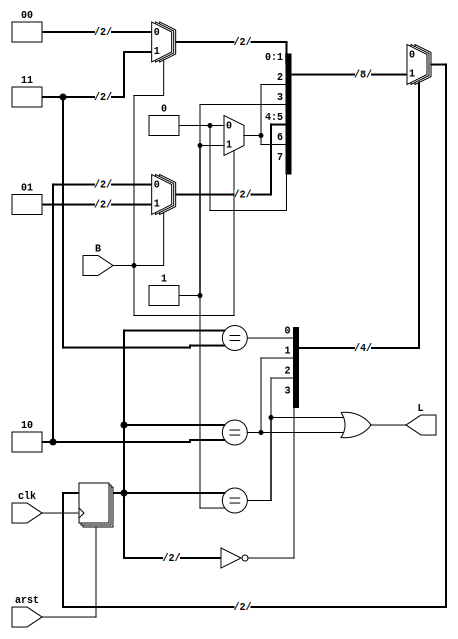

In [164]:
%%print_verilog -n BL4.v
module BL4(
  input clk, arst, B,
  output L);

  //Codifica√ß√£o dos estados
  parameter [1:0] S0 = 2'b00,
                  S1 = 2'b01,
                  S2 = 2'b10,
                  S3 = 2'b11;

  //Estado atual e pr√≥ximo estado
  reg [1:0] E, e;

  // Bloco combinacional (calcula pr√≥ximo estado)
  always @(B, E)
    case (E)
      S0: if (B) e = S1;
       else      e = S0;
      S1: if (B) e = S1;
       else      e = S2;
      S2: if (B) e = S3;
       else      e = S2;
      S3: if (B) e = S3;
       else      e = S0;
      default:   e = 'bx;
    endcase

  // Bloco sequencial (ativa pr√≥ximo estado)
  always @(posedge arst or posedge clk)
    if (arst) E <= S0;
    else      E <= e;

  // Define a sa√≠da a partir dos estados
  assign L = (E == S1 | E == S2);
endmodule

O teste a seguir possui exatamente os mesmos est√≠mulos do anterior, mas incluimos o estado atual e o pr√≥ximo estado no monitor na console e na simula√ß√£o. Note que o pr√≥ximo estado `e` muda imediatamente com a mudan√ßa da entrada `B`, mas a sa√≠da `L` s√≥ muda efetivamente com a mudan√ßa para o pr√≥ximo estado `E`.

B  E L
VCD info: dumpfile dump.vcd opened for output.
0 00 0
1 00 0
1 01 1
0 01 1
0 10 1
1 10 1
1 11 0
0 11 0
0 00 0
1 00 0
1 01 1
0 01 1
0 10 1



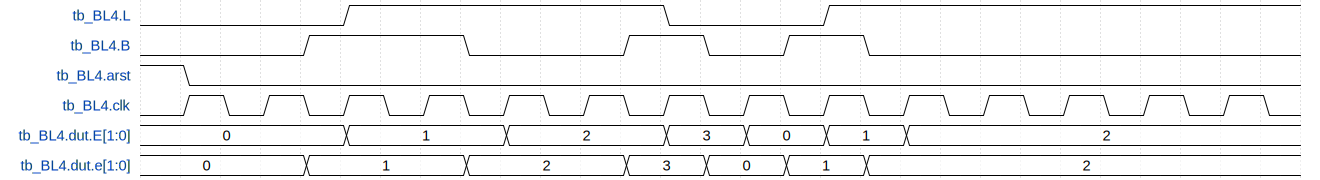

In [165]:
%%wavedrom
`include "BL4.v"

module tb_BL4;
  reg clk, arst, B;
  wire L;
  wire [1:0] S;

  BL4 dut(clk, arst, B, L);

  always
    #5 clk = ~clk;

  initial
  begin
    $display("B  E L");
    $monitor("%b %b %b", B, dut.E, L);
    $dumpvars(0);
    clk = 0; arst = 1; B = 0;
    #5 arst = 0;
    #15 B = 1; #20 B = 0;
    #20 B = 1; #10 B = 0;
    #10 B = 1; #10 B = 0;
    #50 $finish;
  end
endmodule

A seguir est√° uma implementa√ß√£o mais compacta, em que declaramos apenas o estado atual e fazemos a atribui√ß√£o direta do pr√≥ximo estado nesta mesma vari√°vel. Note que o circuito resultante √© exatamente o mesmo. Voc√™ pode test√°-lo usando o *test bench* anterior.

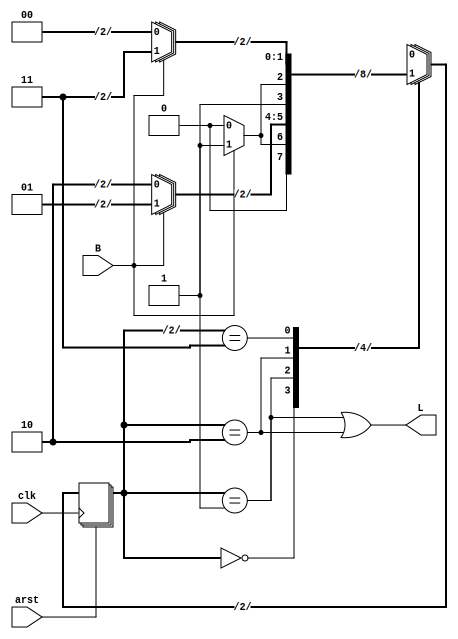

In [160]:
%%print_verilog -n BL4.v
module BL4(
  input clk, arst, B,
  output L);

  parameter [1:0] S0 = 2'b00, S1 = 2'b01, S2 = 2'b10, S3 = 2'b11;
  reg [1:0] E;

  always @(posedge arst or posedge clk)
    if (arst) E <= S0;
    else
      case (E)
        S0: if (B) E = S1;
         else      E = S0;
        S1: if (B) E = S1;
         else      E = S2;
        S2: if (B) E = S3;
         else      E = S2;
        S3: if (B) E = S3;
         else      E = S0;
        default:   E = 'bx;
      endcase

  assign L = (E == S1 | E == S2);
endmodule

Antes de seguir para o pr√≥ximo modelo, vamos implementar ainda mais uma vers√£o do mesmo problema. No exemplo abaixo, estamos usando uma codifica√ß√£o chamada *one-hot*, na qual temos um bit para cada estado e apenas um deles fica acionado em cada estado. Aqui estamos atribuindo cada bit de estado individualmente, como no primeiro m√©todo que usamos (com as tabelas), mas note que as express√µes ficam muito mais simples usando esta codifica√ß√£o. Este circuito tamb√©m pode ser testado com o *test bench* anterior.

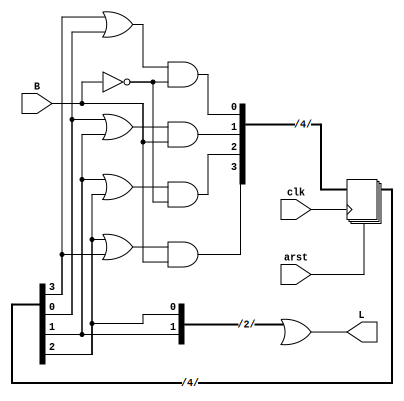

In [166]:
%%print_verilog -n BL4.v
module BL4(
  input clk, arst, B,
  output L);

  reg [3:0] E;

  always @(posedge arst or posedge clk)
    if (arst) E <= 4'b0001; //S0
    else
    begin
      E[0] <= (E[3] | E[0]) & ~B; //S0 = 0001
      E[1] <= (E[0] | E[1]) &  B; //S1 = 0010
      E[2] <= (E[1] | E[2]) & ~B; //S2 = 0100
      E[3] <= (E[2] | E[3]) &  B; //S3 = 1000
    end

  assign L = |E[2:1];
endmodule

## Modelo de Mealy

No modelo de Mealy, as sa√≠das de uma FSM dependem do estado atual e das entradas, ent√£o anotamos as sa√≠das nas transi√ß√µes e n√£o nos estados. Considerando nosso problema anterior, j√° corrigido a quest√£o da repeti√ß√£o da entrada do bot√£o, teriamos a seguinte FSM:

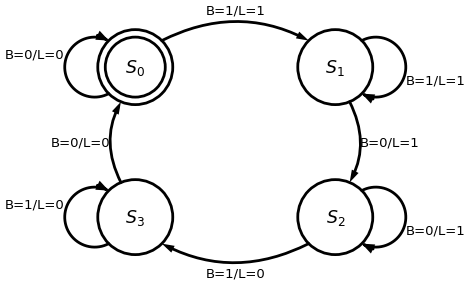

In [120]:
# @title
with schemdraw.Drawing() as d:
    d += (s0 := flow.StateEnd().at((0,3)).label('$S_0$'))
    d += (s1 := flow.State().at(   (4,3)).label('$S_1$'))
    d += (s2 := flow.State().at(   (4,0)).label('$S_2$'))
    d += (s3 := flow.State().at(   (0,0)).label('$S_3$'))

    d += elm.ArcLoop(arrow='->').at(s0.SW).to(s0.NW).label('B=0/L=0', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s1.NE).to(s1.SE).label('B=1/L=1', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s2.NE).to(s2.SE).label('B=0/L=1', fontsize=11)
    d += elm.ArcLoop(arrow='->').at(s3.SW).to(s3.NW).label('B=1/L=0', fontsize=11)

    d += elm.Arc2(k=.25, arrow='->').at( s0.NE).to(s1.NW ).label('B=1/L=1', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s1.SSE).to(s2.NNE).label('B=0/L=1', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at( s2.SW).to(s3.SE ).label('B=1/L=0', fontsize=11)
    d += elm.Arc2(k=.25, arrow='->').at(s3.NNW).to(s0.SSW).label('B=0/L=0', fontsize=11)

Nossa tabela de transi√ß√µes de estados agora tem uma coluna a mais, pois a sa√≠da tamb√©m depende da entrada.

<table>
<thead>
  <tr>
    <th rowspan="2">Estado<br>Atual</th>
    <th colspan="2">Pr√≥ximo Estado</th>
    <th colspan="2">Sa√≠da L</th>
  </tr>
  <tr>
    <th>B=0</th>
    <th>B=1</th>
    <th>B=0</th>
    <th>B=1</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>S0</td>
    <td>S0</td>
    <td>S1</td>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <td>S1</td>
    <td>S2</td>
    <td>S1</td>
    <td>1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>S2</td>
    <td>S2</td>
    <td>S3</td>
    <td>1</td>
    <td>0</td>
  </tr>
  <tr>
    <td>S3</td>
    <td>S0</td>
    <td>S3</td>
    <td>0</td>
    <td>0</td>
  </tr>
</tbody>
</table>

O mesmo acontece na tabela de atribui√ß√£o de estados:

<table>
<thead>
  <tr>
    <th rowspan="2">Estado<br>Atual</th>
    <th colspan="2">Pr√≥ximo Estado</th>
    <th colspan="2">Sa√≠da L</th>
  </tr>
  <tr>
    <th>B=0</th>
    <th>B=1</th>
    <th>B=0</th>
    <th>B=1</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>00</td>
    <td>00</td>
    <td>01</td>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <td>01</td>
    <td>10</td>
    <td>01</td>
    <td>1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>10</td>
    <td>10</td>
    <td>11</td>
    <td>1</td>
    <td>0</td>
  </tr>
  <tr>
    <td>11</td>
    <td>00</td>
    <td>11</td>
    <td>0</td>
    <td>0</td>
  </tr>
</tbody>
</table>

Nossa fun√ß√£o de sa√≠da $L$ agora tamb√©m tem $B$ como vari√°vel de entrada:

* $e_1(B, E_1, E_0)  = \overline{B}.(E_1 \oplus E_0) + B.E_1$
* $e_0(B, E_1, E_0) = B$
* $L(B, E_1, E_0) = \overline{B}.(E_1 \oplus E_0) + B.\overline{E_1}$

Se observarmos o circuito gerado a seguir, podemos notar que h√° um caminho que come√ßa na entrada $B$ e vai at√© a sa√≠da $L$, sem passar pelos elementos de estado:

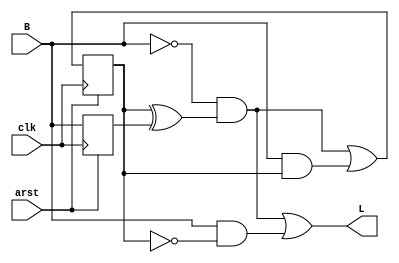

In [121]:
%%print_verilog -n BL2Mealy.v
module BL2Mealy(
  input clk, arst, B,
  output L);

  reg E1, E0;

  always@(posedge clk or posedge arst)
    if (arst)
    begin
      E1 <= 1'b0;
      E0 <= 1'b0;
    end
    else
    begin
      E1 <= ~B & (E1 ^ E0) | B & E1;
      E0 <= B;
    end
  assign L = ~B & (E1 ^ E0) | B & ~E1;
endmodule

O efeito disso pode ser notado na simula√ß√£o. A transi√ß√£o dos estados ocorre exatamente como no modelo de Moore, mas a sa√≠da √© modificada antes, j√° no acionamento do bot√£o. Em certos casos, esta possibilidade permite resolver o mesmo problema com um n√∫mero menor de estados, como veremos a seguir.

B Sn L
VCD info: dumpfile dump.vcd opened for output.
0 00 0
1 00 1
1 01 1
0 01 1
0 10 1
1 10 0
1 11 0
0 11 0
0 00 0
1 00 1
1 01 1
0 01 1
0 10 1



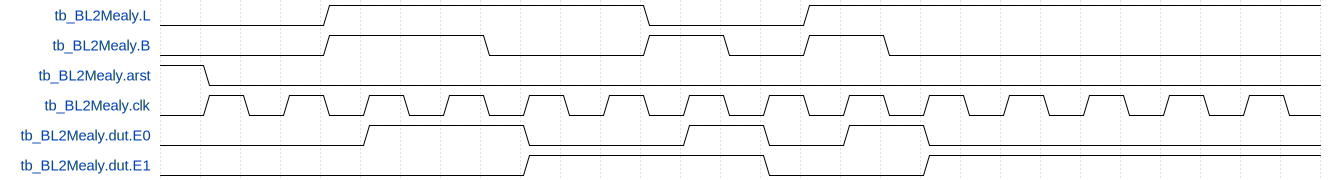

In [122]:
%%wavedrom
`include "BL2Mealy.v"

module tb_BL2Mealy;
  reg clk, arst, B;
  wire L;
  wire [1:0] S;

  BL2Mealy dut(clk, arst, B, L);

  always
    #5 clk = ~clk;

  initial
  begin
    $display("B Sn L");
    $monitor("%b %b%b %b", B, dut.E1, dut.E0, L);
    $dumpvars(0);
    clk = 0; arst = 1; B = 0;
    #5 arst = 0;
    #15 B = 1; #20 B = 0;
    #20 B = 1; #10 B = 0;
    #10 B = 1; #10 B = 0;
    #50 $finish;
  end
endmodule

# Mem√≥rias

A evolu√ß√£o natural dos registradores que vimos na segunda parte deste livro s√£o as mem√≥rias. Elas consistem em um conjunto de registradores acess√≠veis por um determinado endere√ßo, usado tanto para ler quanto para escrever. Na descri√ß√£o a seguir, espeficicamos uma mem√≥ria de 256 palavras, cada uma delas com 4 bytes (32 bits).


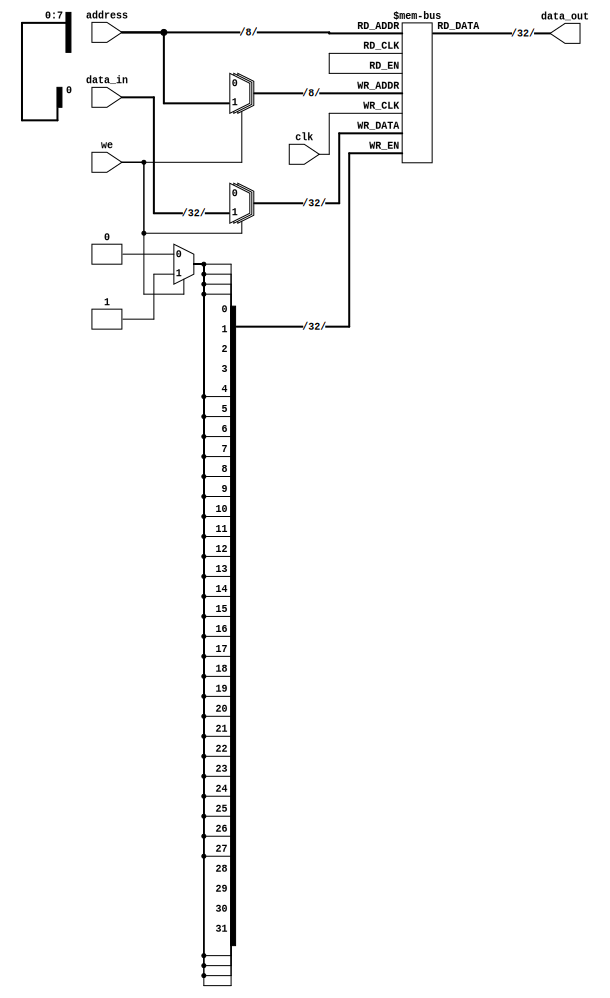

In [171]:
%%print_verilog -n mem.v
module mem (
  input clk, we,
  input [7:0] address,
  input [31:0] data_in,
  output [31:0] data_out);

  reg [31:0] RAM [255:0];

  assign data_out = RAM[address];

  always @(posedge clk)
    if (we) RAM[address] <= data_in;
endmodule

In [ ]:
%%wavedrom
`include "mem.v"

module tb_mem;
  reg clk, we;
  reg [7:0] address;
  reg [31:0] data_in;
  wire [31:0] data_out;

  mem dut(clk, we, address, data_in, data_out);

  always
    #5 clk = ~clk;

  initial
  begin
    $dumpvars(1);
    clk = 1; we = 0; address = 0; data_in = 0;
    #5 we = 1;
    #10 address = 1; data_in = 2;
    #10 address = 2; data_in = 4;
    #5 we = 0; address = 0;
    #10 address = 1;
    #10 address = 2;
    #10 $finish;
  end
endmodule

# Barramentos

At√© agora, nossos circuitos possuiam fios dedicados para conectar a sa√≠da de um componente at√© uma ou mais entradas de outros componentes. Em alguns casos, ter liga√ß√µes dedicadas pode ser muito custoso e precisamos usar barramentos compartilhados. Para isso, precisamos usar *buffers* que permitem deixar sa√≠das com **alta imped√¢ncia** como se estivessem desconectadas. Em Verilog, as primitivas b√°sicas para construir estes barramentos, chamados *tristate*, s√£o as seguintes:

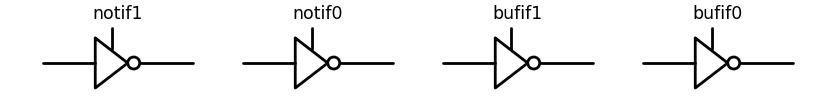

In [124]:
%load_ext autoreload
%autoreload 2

import schemdraw
from schemdraw import logic

with schemdraw.Drawing() as d:
    d += logic.Tristate().label('notif1')
    d += elm.Gap().length(1)
    d += logic.Tristate(controlnot = True).label('notif0')
    d += elm.Gap().length(1)
    d += logic.Tristate(outputnot = False).label('bufif1')
    d += elm.Gap().length(1)
    d += logic.Tristate(outputnot = False, controlnot = True).label('bufif0')


Ao inv√©s de instanciar estas primitivas b√°sicas, podemos simplesmente atribuir um valor `z` a um fio ou barramento para coloc√°-lo no estado de alta imped√¢ncia, por exemplo:
```verilog
parameter N = 8;
wire [N-1:0] notif1bus, notif0bus, bufif1bus, bufif0bus, in;
assign notif1bus =  control ? ~in : 'bz;
assign notif0bus = ~control ? ~in : 'bz;
assign bufif1bus =  control ?  in : 'bz;
assign bufif0bus = ~control ?  in : 'bz;
```

In [170]:
%%verilog
module t_fibo;
  wire [31:0] bus;
  reg clk, rst, ec;

  fibo #(1) a(clk, rst,  ec, bus);
  fibo #(1) b(clk, rst, ~ec, bus);

  initial begin
    $dumpfile("dump.vcd");
    $display("a  bus    b");
    $monitor("%d %d %d", a.value, bus, b.value);
    rst = 1; ec = 0;
    #10 rst = 0;
    #120 $finish;
  end

  always begin
    clk = 0; #5; clk = 1; #5;
  end

  always @(negedge clk)
    ec = ~ec;
endmodule

module fibo #(parameter resetval = 0)(
  input clk, rst, enable,
  inout tri [31:0] bus);
  integer value;
  always @(posedge clk)
    if (rst)
      value = resetval;
    else
      if (enable)
        value = value + bus;
  assign bus = enable ? 'bz : value;
endmodule

a  bus    b
          x          x           x
          1          1           1
          1          1           1
          2          1           1
          2          2           1
          2          2           3
          2          3           3
          5          3           3
          5          5           3
          5          5           8
          5          8           8
         13          8           8
         13         13           8
         13         13          21
         13         21          21
         34         21          21
         34         34          21
         34         34          55
         34         55          55
         89         55          55
         89         89          55
         89         89         144
         89        144         144
        233        144         144
        233        233         144
        233        233         377
        233        377         377

